In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys

sys.path.append("../")

import CoolProp.CoolProp as CP
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt  # noqa: E402
from matplotlib import rcParams  # noqa: E402
from matplotlib import font_manager  # noqa: E402
import pandas as pd  # noqa: E402

from pathlib import Path

import scipy.constants as const  # noqa: E402


from src.WellClass.libs.well_pressure.Pressure import Pressure  # noqa: E402
from src.WellClass.libs.plotting import plot_pressure  # noqa: E402
from src.WellClass.libs.pvt.pvt import (  # noqa: E402
    load_pvt_data,
    get_mixture_info,
)

In [5]:
# resource configuration
rcParams["figure.dpi"] = 150

# fount information
rcParams["font.family"] = "Equinor"
rcParams["font.size"] = 9

# font location
font_path = r"Equinor_regular"
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [ ]:
pvt_path = Path(r"../src/WellClass/libs/pvt/pvt_constants")

co2_path_name = "pure_co2"
mix1_path_name = "mixture1"
mix2_path_name = "mixture2"

co2_path = pvt_path / co2_path_name
mix1_path = pvt_path / mix1_path_name
mix2_path = pvt_path / mix2_path_name


co2_mixture_info = get_mixture_info(co2_path)
co2_mixture_name = co2_mixture_info["name"]
co2_mixture_composition = co2_mixture_info["composition"]


mix1_mixture_info = get_mixture_info(mix1_path)
mix1_mixture_name = mix1_mixture_info["name"]
mix1_mixture_composition = mix1_mixture_info["composition"]

mix2_mixture_info = get_mixture_info(mix2_path)
mix2_mixture_name = mix2_mixture_info["name"]
mix2_mixture_composition = mix2_mixture_info["composition"]

print(f"Computing pressures for {co2_mixture_name} ({co2_mixture_composition})")
print(f"Computing pressures for {mix1_mixture_name} ({mix1_mixture_composition})")
print(f"Computing pressures for {mix2_mixture_name} ({mix2_mixture_composition})")


co2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=co2_path_name)
mix1_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix1_path_name)
mix2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix2_path_name)


Computing pressures for pure CO2 (100% CO2)
Computing pressures for mixture1 (96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4)
Computing pressures for mixture2 (95% CO2, 5% CH4)


# Tables comparison

In [7]:
olga_pure_co2_122 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=0)
olga_pure_co2_94 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=1)
olga_pure_co2_75 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=2)
olga_pure_co2_47 = pd.read_excel(r"./olga_ref_runs/PureCO2.xlsx", sheet_name=3)

olga_mix1_122 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=0)
olga_mix1_94 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=1)
olga_mix1_75 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=2)
olga_mix1_47 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=3)

olga_mix2_122 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=0)
olga_mix2_94 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=1)
olga_mix2_75 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=2)
olga_mix2_47 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=3)


In [8]:
mix2_mixture_composition


'95% CO2, 5% CH4'

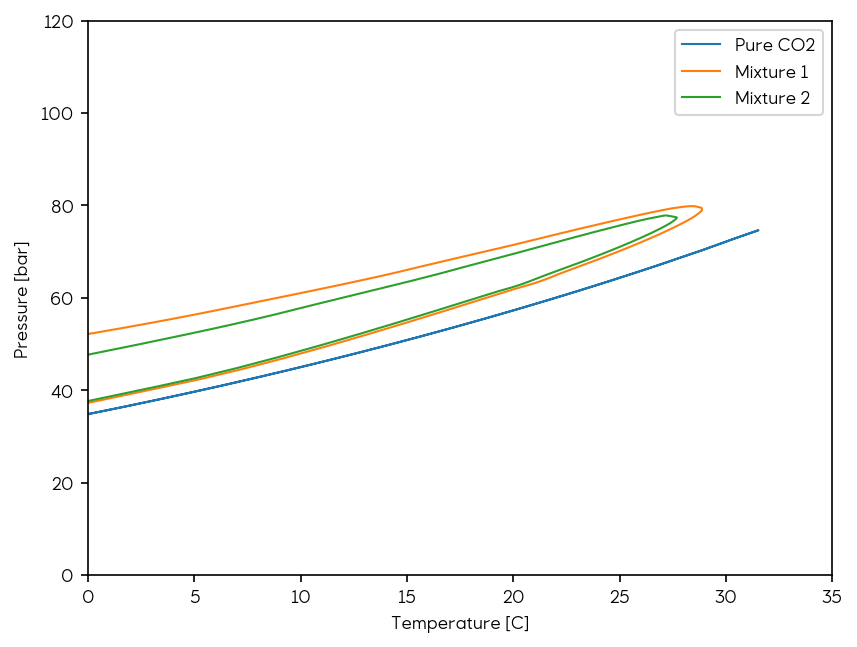

In [9]:
from scipy.interpolate import Akima1DInterpolator

def refine_envelope(envelope, k=3):
    x = np.array(envelope.T)-273.15
    y = np.array(envelope.p)/1e5

    param = np.linspace(0,1, x.size)

    spl = Akima1DInterpolator(param, np.c_[x,y])
    x_smooth, y_smooth = spl(np.linspace(0, 1, x.size * 10)).T
    return x_smooth, y_smooth

# Pure CO2
pure_co2_component = ['CO2']
pure_co2_mole_fraction = [1.0]

pure_co2_state = CP.AbstractState("HEOS", "&".join(pure_co2_component))
pure_co2_state.set_mole_fractions(pure_co2_mole_fraction)

pure_co2_state.build_phase_envelope("dummy")
pure_co2_PE = pure_co2_state.get_phase_envelope_data()

pure_co2_T, pure_co2_P = refine_envelope(pure_co2_PE)

# Mixture 1
mix1_components = ["CO2", "H2", "Argon", "Nitrogen", "Methane"]
mix1_mole_fractions = [0.96, 0.004, 0.01, 0.0082, 0.0178]

mix1_state = CP.AbstractState("HEOS", "&".join(mix1_components))
mix1_state.set_mole_fractions(mix1_mole_fractions)

mix1_state.build_phase_envelope("dummy")
mix1_PE = mix1_state.get_phase_envelope_data()

mix1_T, mix1_P = refine_envelope(mix1_PE)

# Mixture 2
mix2_components = ["CO2", "Methane"]
mix2_mole_fractions = [0.95, 0.05]

mix2_state = CP.AbstractState("HEOS", "&".join(mix2_components))
mix2_state.set_mole_fractions(mix2_mole_fractions)

mix2_state.build_phase_envelope("dummy")
mix2_PE = mix2_state.get_phase_envelope_data()

mix2_T, mix2_P = refine_envelope(mix2_PE)

fig, ax = plt.subplots()

ax.plot(pure_co2_T, pure_co2_P, "-", label="Pure CO2", lw=1)
# ax.scatter(np.array(pure_co2_PE.T)-273.15, np.array(pure_co2_PE.p)/1e5, label="Mixture 1")

ax.plot(mix1_T, mix1_P, "-", label="Mixture 1", lw=1)
# ax.scatter(np.array(mix1_PE.T)-273.15, np.array(mix1_PE.p)/1e5, label="Mixture 1")

ax.plot(mix2_T, mix2_P, "-", label="Mixture 2", lw=1)
# ax.scatter(np.array(mix2_PE.T)-273.15, np.array(mix2_PE.p)/1e5, label="Mixture 2")



ax.set_xlabel("Temperature [C]")
ax.set_ylabel("Pressure [bar]")

ax.set_xlim(0, 35)
ax.set_ylim(0, 120)
ax.legend()

In [10]:
mix1_mixture_info

{'name': 'mixture1',
 'composition': '96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4'}

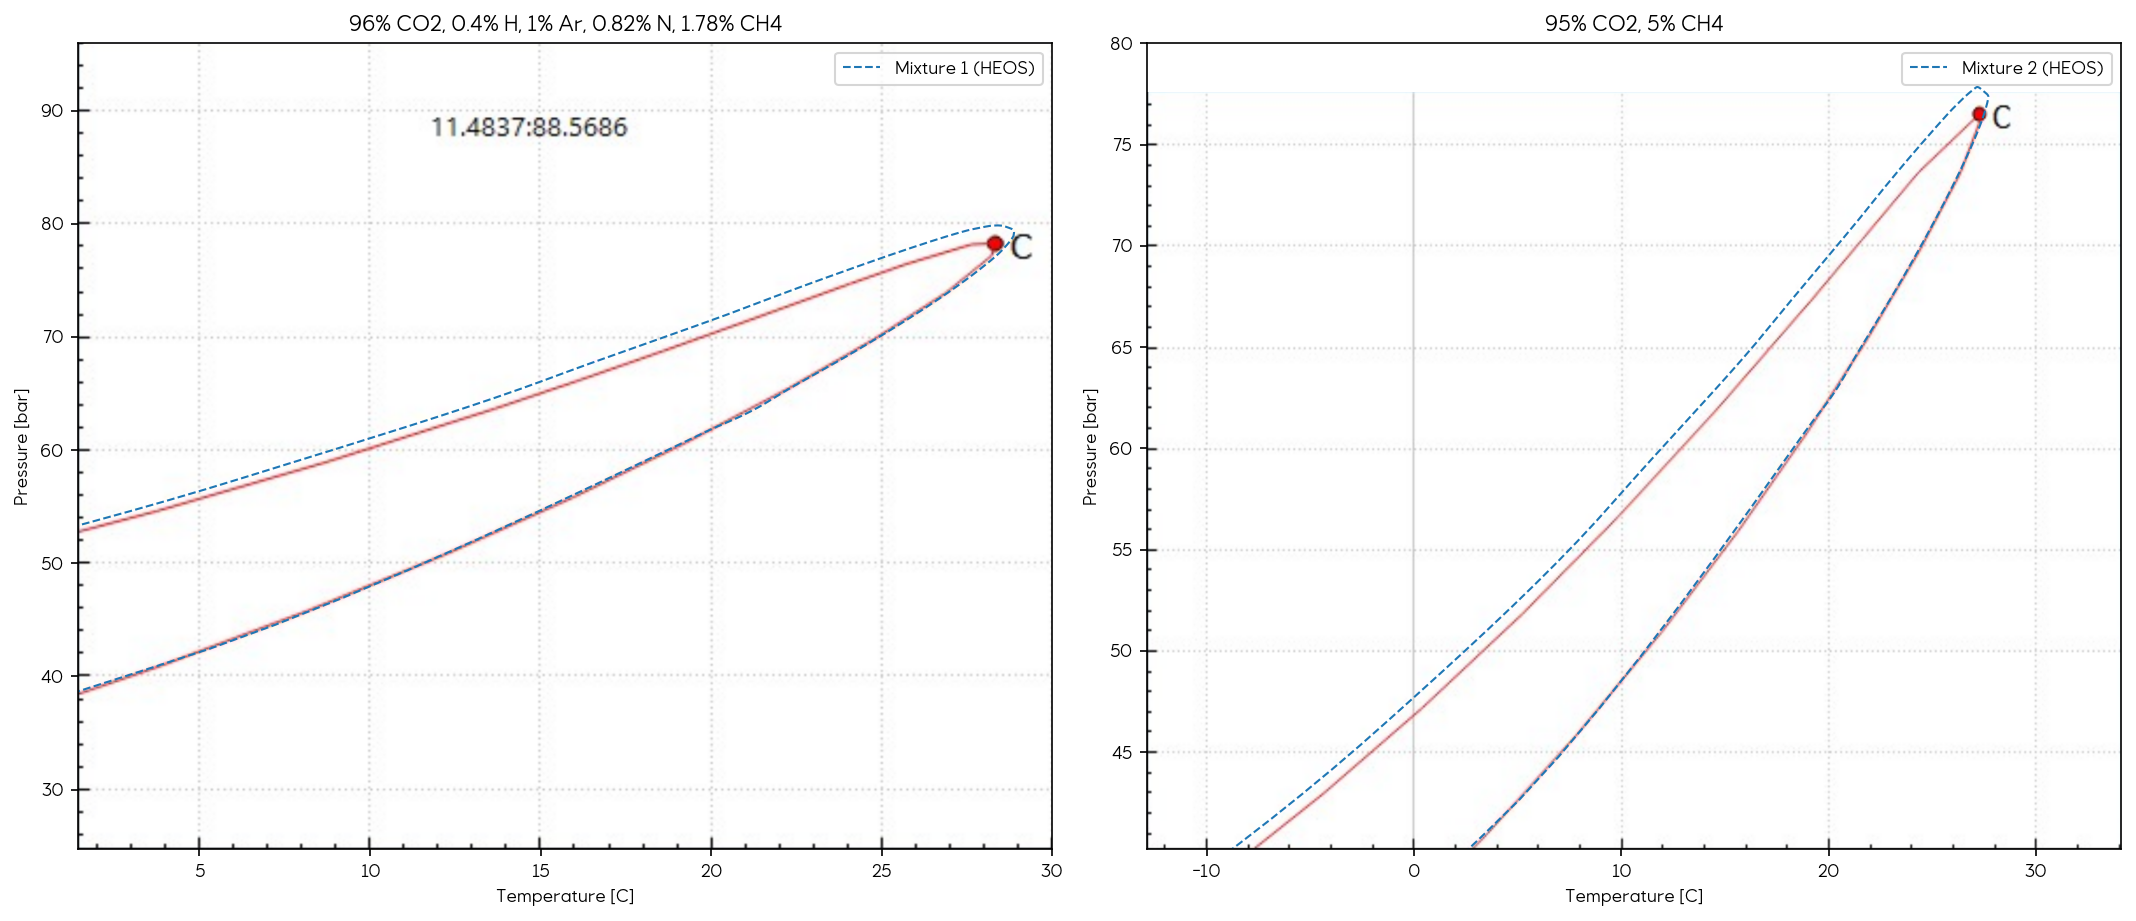

In [11]:

# Load the image
img_mix1 = Image.open(r"./olga_ref_runs/mix_1_olga_envelope.png")

# Load the image
img_mix2 = Image.open(r"./olga_ref_runs/mix_2_olga_envelope.png")


# Get image dimensions
width_pt, height_pt = img_mix1.size

# Display the image
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize=(2*width_pt / 200, height_pt / 200))

img_mix1_extents = [1.453, 30, 24.737, 95.95]

img_mix2_extents = [-12.879, 34.09403077,40.21068011, 77.574]


ax1.imshow(img_mix1, extent=img_mix1_extents, aspect='auto')


ax2.imshow(img_mix2, extent=img_mix2_extents, aspect='auto')


# ax.scatter(np.array(mix1_PE.T)-273.15, np.array(mix1_PE.p)/1e5, label="Mixture 1")
ax1.plot(mix1_T, mix1_P, "--", label="Mixture 1 (HEOS)", lw = 1)
ax2.plot(mix2_T, mix2_P, "--", label="Mixture 2 (HEOS)", lw = 1)

# # Set axis limits to match the chart's axis values
ax1.set_xlim(img_mix1_extents[0], img_mix1_extents[1])
ax1.set_ylim(img_mix1_extents[2], img_mix1_extents[3])

ax2.set_xlim(img_mix2_extents[0], img_mix2_extents[1])
ax2.set_ylim(img_mix2_extents[2], 80)

ax1.set_xlabel('Temperature [C]')
ax1.set_ylabel('Pressure [bar]')

ax1.set_title(f'{mix1_mixture_info['composition']}')


ax2.set_xlabel('Temperature [C]')
ax2.set_ylabel('Pressure [bar]')

ax2.set_title(f'{mix2_mixture_info['composition']}')

ax1.legend()
ax2.legend()


fig.tight_layout()


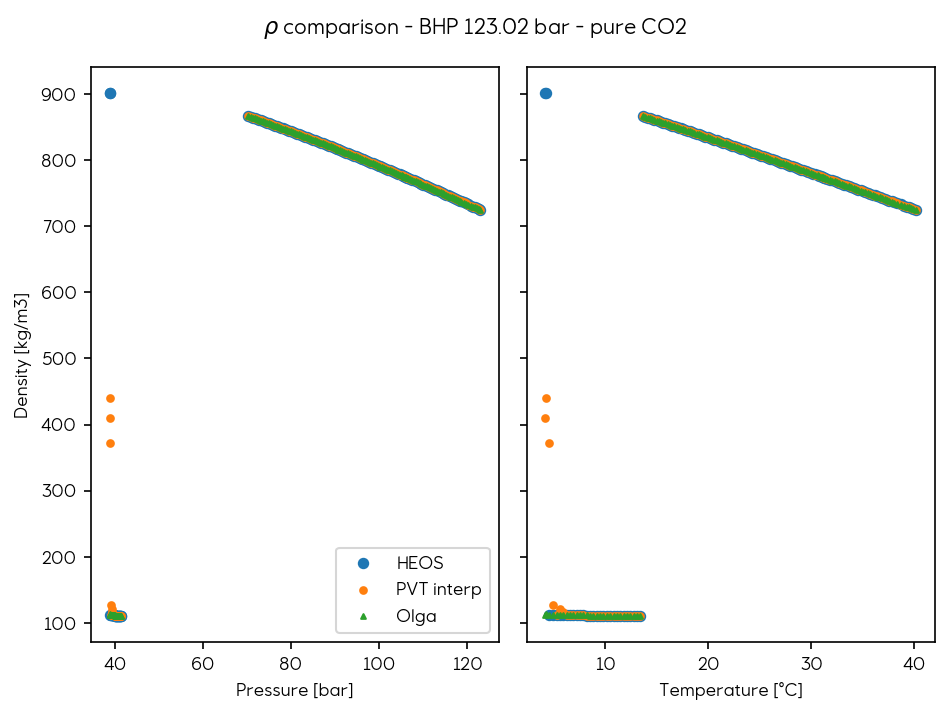

In [12]:
table = olga_pure_co2_122

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = co2_pvt_data["pressure"]
y = co2_pvt_data["temperature"]
z = co2_pvt_data[co2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - pure CO2")

ax1.legend()

fig.tight_layout()

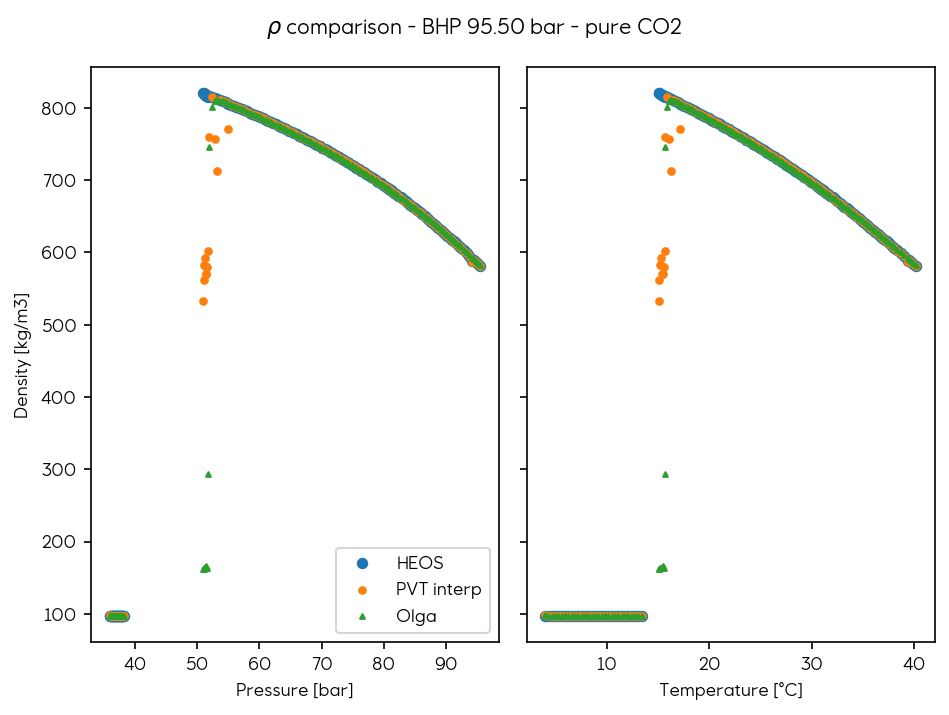

In [13]:
table = olga_pure_co2_94

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = co2_pvt_data["pressure"]
y = co2_pvt_data["temperature"]
z = co2_pvt_data[co2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - pure CO2")


fig.tight_layout()

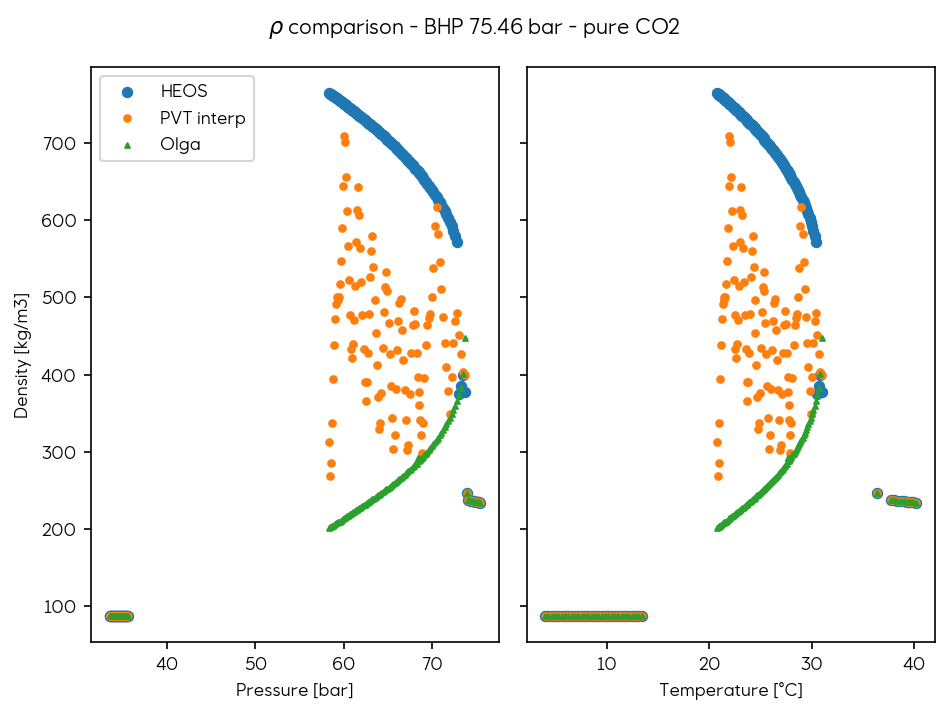

In [14]:
table = olga_pure_co2_75

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = co2_pvt_data["pressure"]
y = co2_pvt_data["temperature"]
z = co2_pvt_data[co2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - pure CO2")


fig.tight_layout()

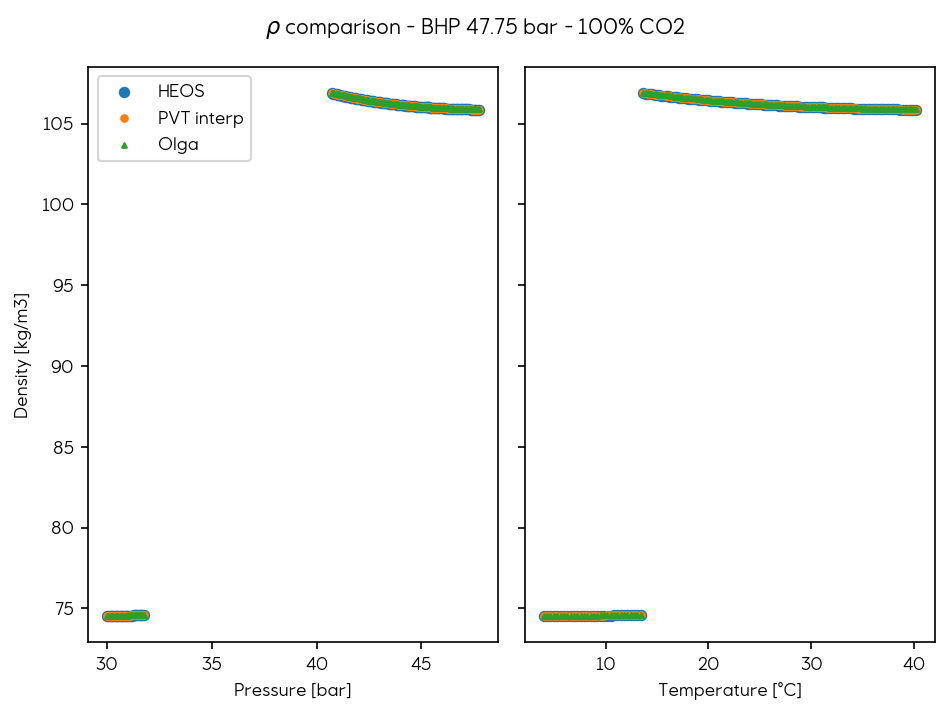

In [15]:
table = olga_pure_co2_47

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = co2_pvt_data["pressure"]
y = co2_pvt_data["temperature"]
z = co2_pvt_data[co2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {co2_mixture_composition}")


fig.tight_layout()

In [16]:
olga_mix1_122

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                             0.000070                             
1                                             0.001209                             
2                                             0.000128                             
3                                             0.001992                             
4                                             0.000177                             
..                                                 ...                             
147                                           1.000000                             
148                                           1.000000                             
149                                           1.000000                             
150                                           1.000000                             
151                                           1.000000                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              45.046581   
1                12.400000                              45.148140   
2                20.666666                              45.250332   
3                28.933332                              45.353180   
4                37.200001                              45.456680   
..                     ...                                    ...   
147             900.625000                             121.299896   
148             906.625000                             121.644600   
149             912.625000                             121.988899   
150             918.625000                             122.332298   
151             924.812500                             122.685600   

     Pipeline length [m].2  TM [C] (CHANNEL  PACTH) "Fluid temperature"  \
0                 4.133333                                     4.007951   
1                12.400000                                     4.335018   
2                20.666666                                     4.664342   
3                28.933332                                     4.994618   
4                37.200001                                     5.329660   
..                     ...                                          ...   
147             900.625000                                    39.301880   
148             906.625000                                    39.438061   
149             912.625000                                    39.673229   
150             918.625000                                    39.908340   
151             924.812500                                    40.150391   

     Pipeline length [m].3  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                           124.890800                                                                                          
1                                           126.471100                                                                                          
2                                           126.505302                                                                               

In [17]:
mix1_mixture_composition

'96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4'

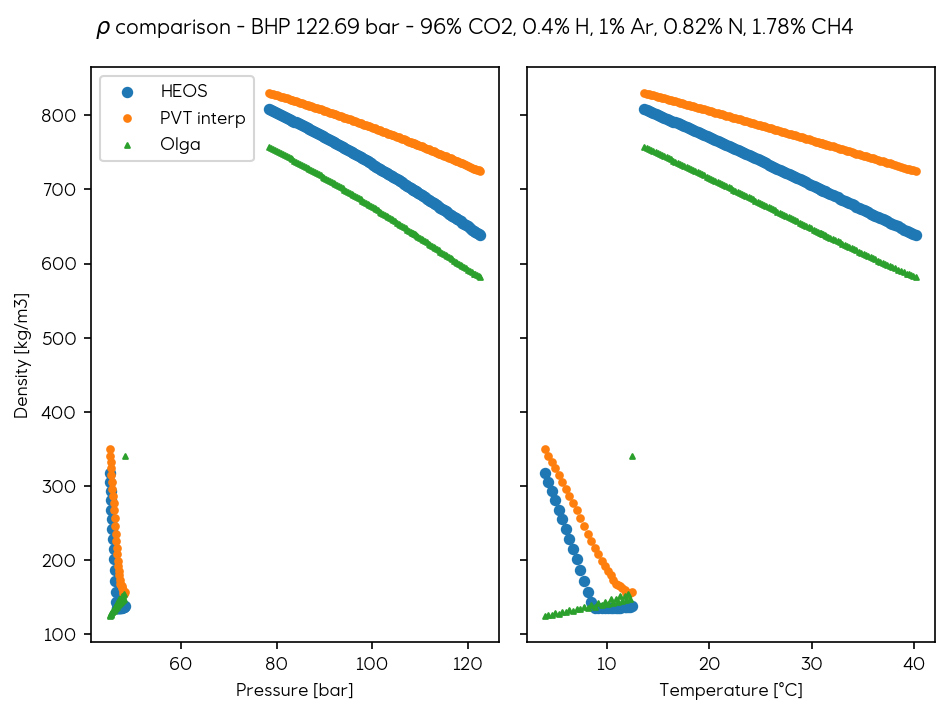

In [18]:
table = olga_mix1_122

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")


fig.tight_layout()

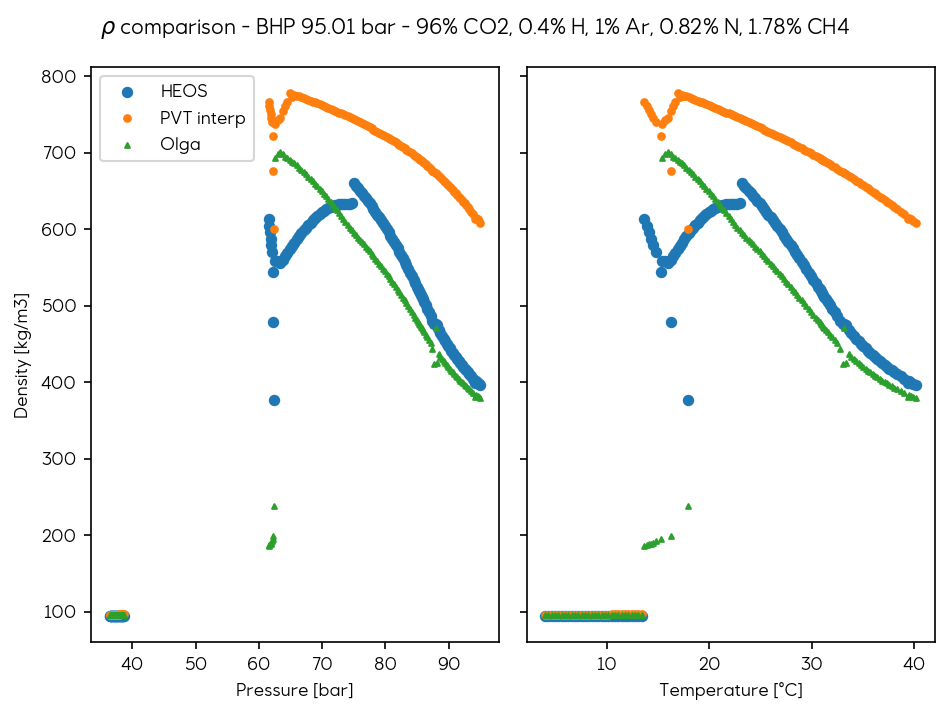

In [19]:
table = olga_mix1_94

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()
fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")


fig.tight_layout()

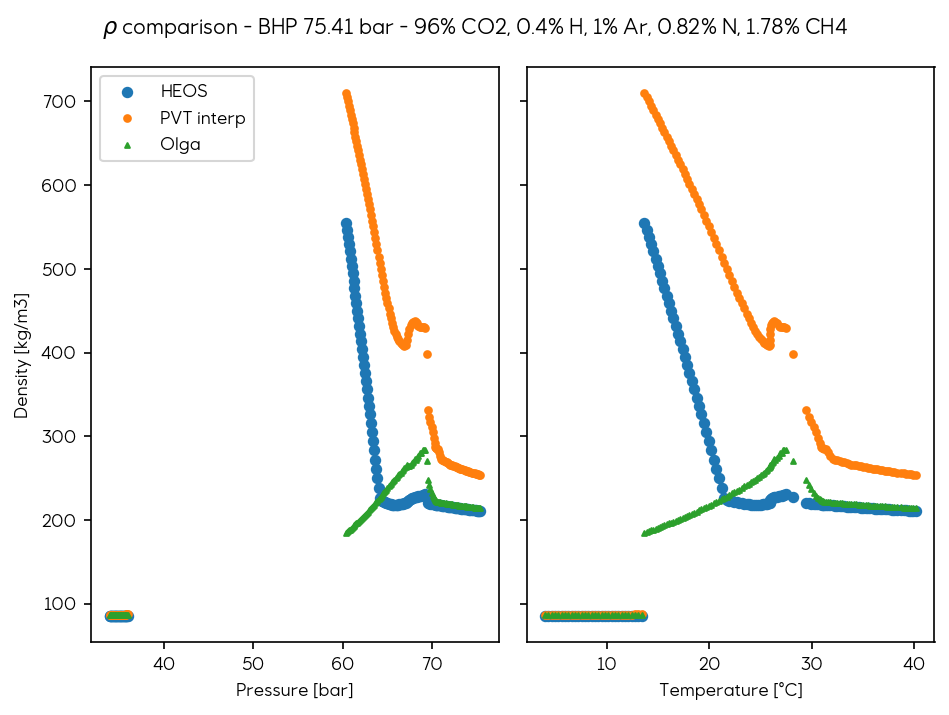

In [18]:
table = olga_mix1_75

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")

fig.tight_layout()

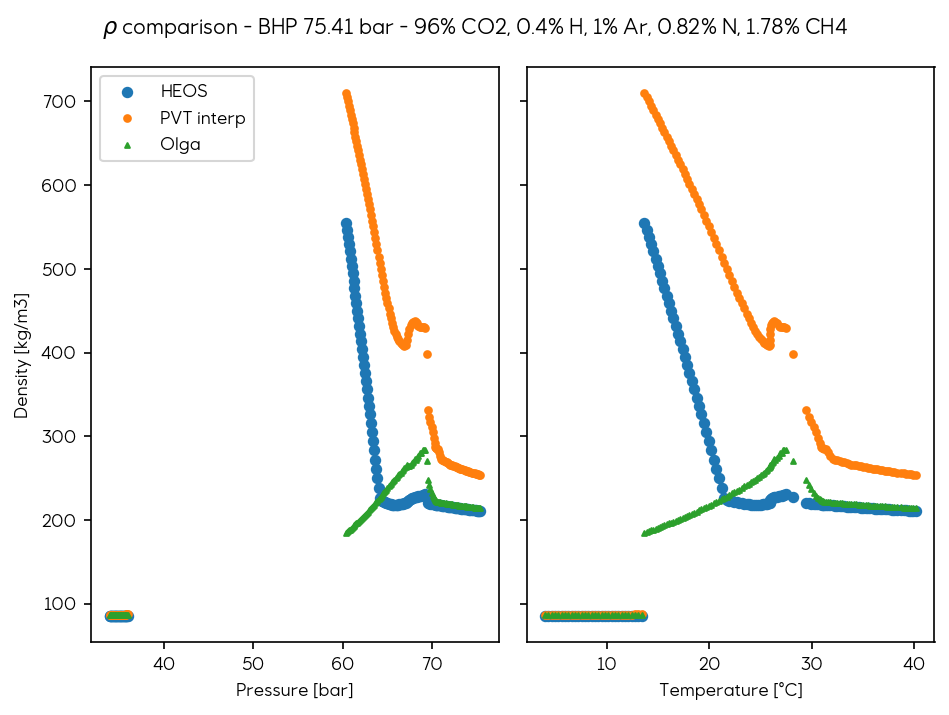

In [20]:
table = olga_mix1_75

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")

fig.tight_layout()

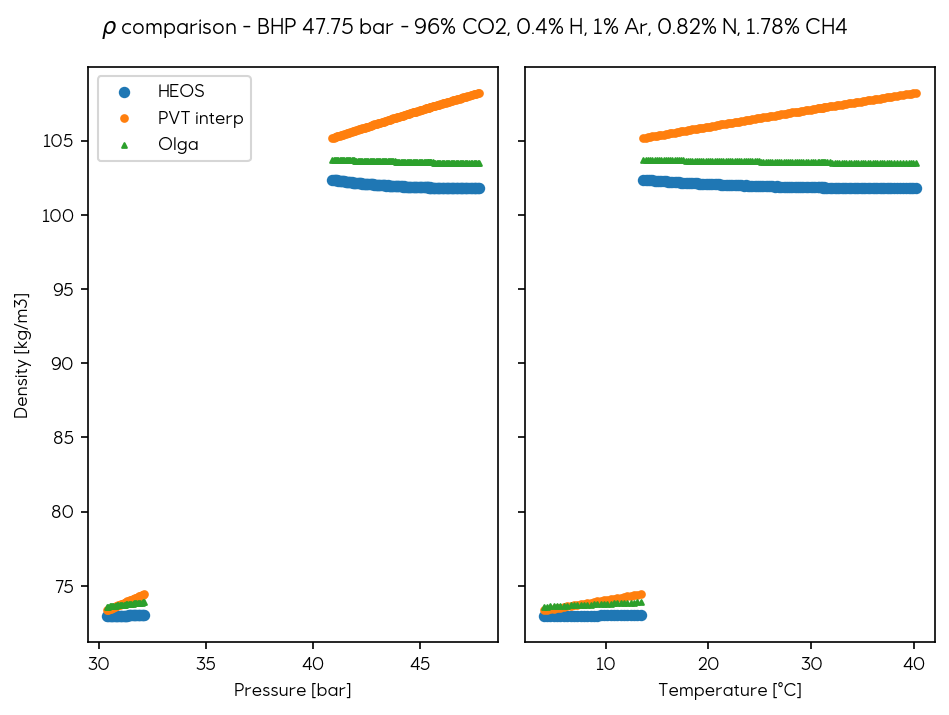

In [19]:
table = olga_mix1_47

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 5].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix1_state.update(CP.PT_INPUTS, P, T)
    rho = mix1_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals

# Interpolate from PVT tables
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 7], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 7],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix1_mixture_composition}")


fig.tight_layout()

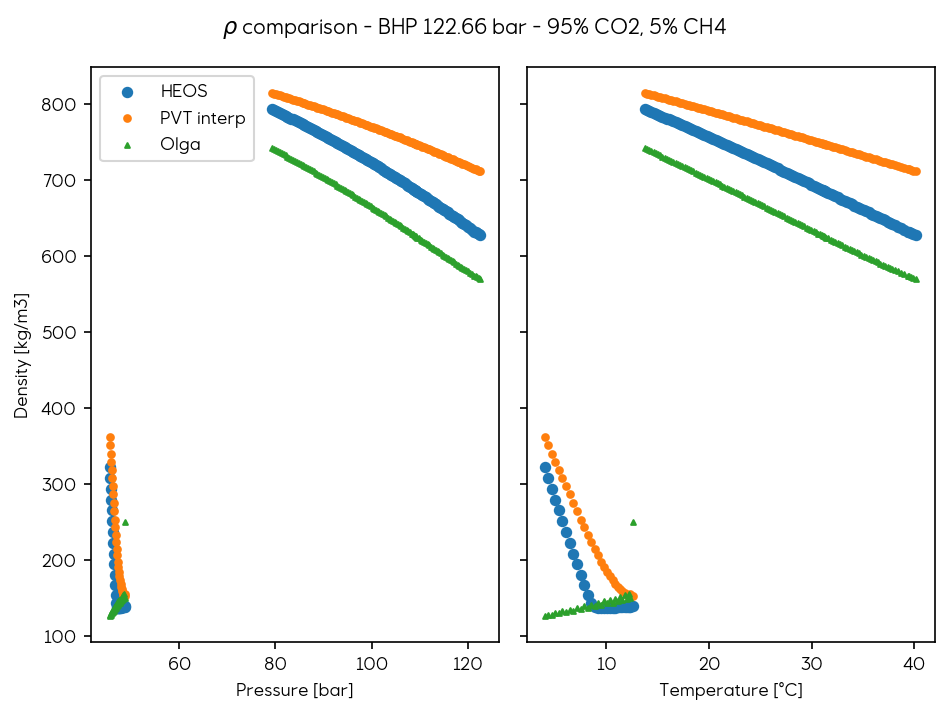

In [20]:
table = olga_mix2_122

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix2_state.update(CP.PT_INPUTS, P, T)
    rho = mix2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals



x = mix2_pvt_data["pressure"]
y = mix2_pvt_data["temperature"]
z = mix2_pvt_data[mix2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix2_mixture_composition}")


fig.tight_layout()

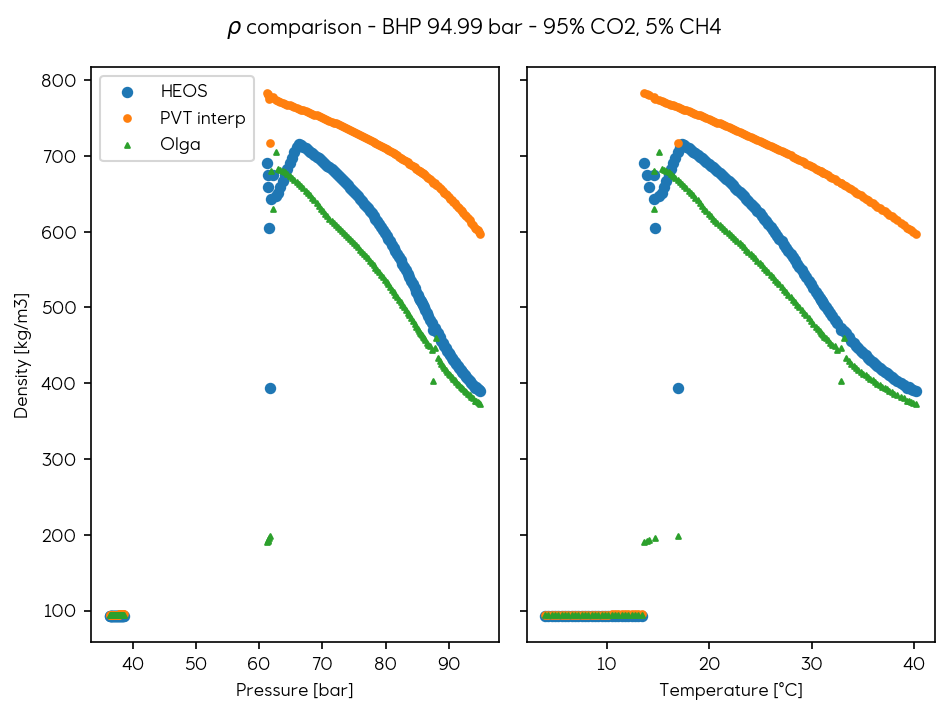

In [21]:
table = olga_mix2_94

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix2_state.update(CP.PT_INPUTS, P, T)
    rho = mix2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals



x = mix2_pvt_data["pressure"]
y = mix2_pvt_data["temperature"]
z = mix2_pvt_data[mix2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix2_mixture_composition}")


fig.tight_layout()

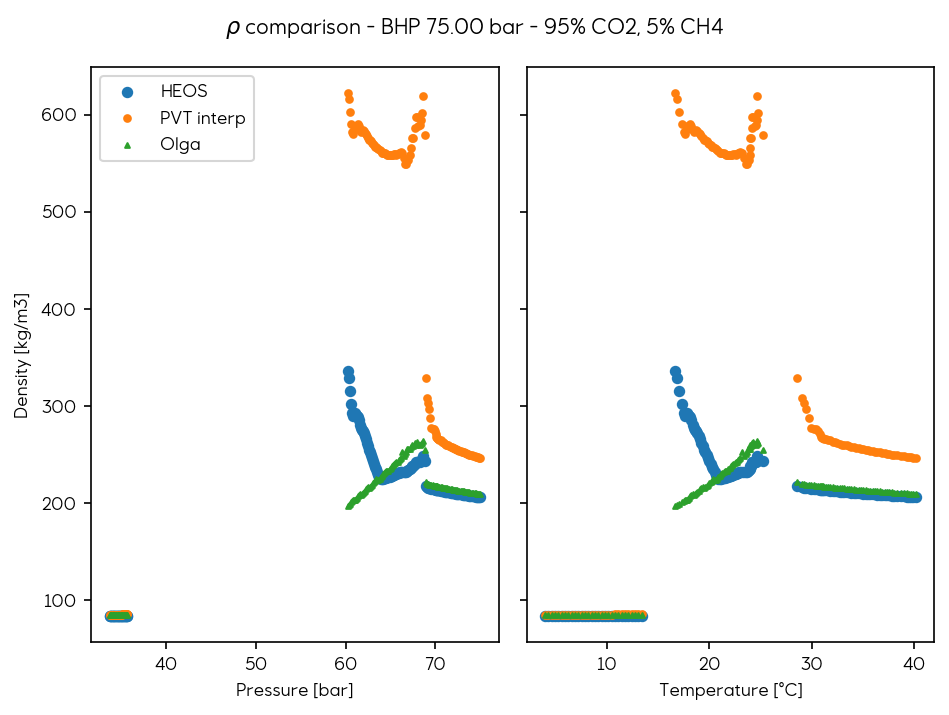

In [22]:
table = olga_mix2_75

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix2_state.update(CP.PT_INPUTS, P, T)
    rho = mix2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals



x = mix2_pvt_data["pressure"]
y = mix2_pvt_data["temperature"]
z = mix2_pvt_data[mix2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix2_mixture_composition}")


fig.tight_layout()

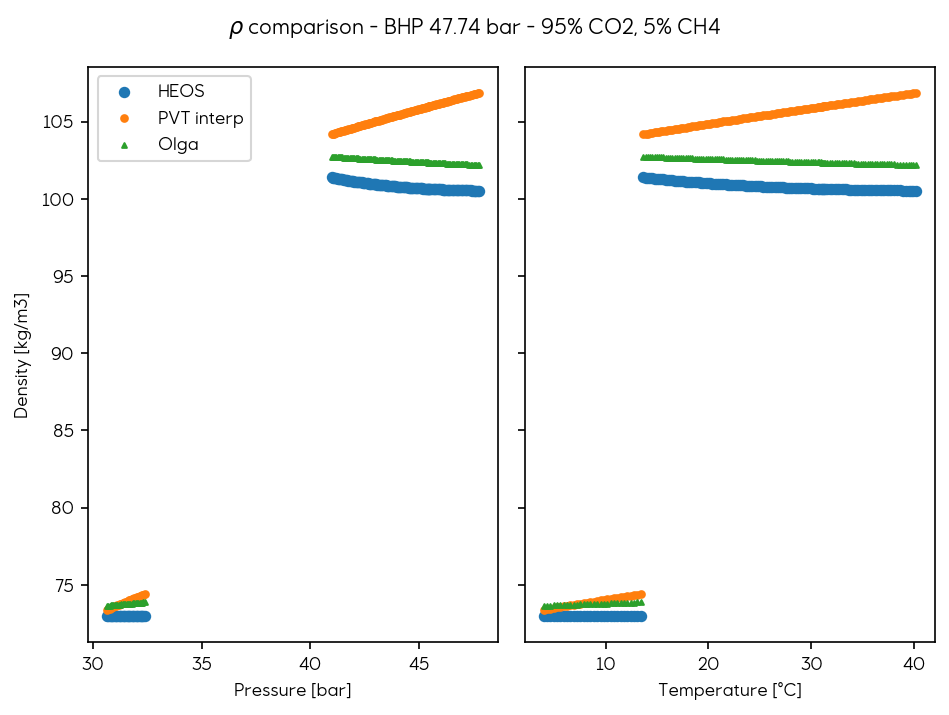

In [23]:
table = olga_mix2_47

P_vals = table.iloc[:, 3].values
T_vals = table.iloc[:, 7].values
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    mix2_state.update(CP.PT_INPUTS, P, T)
    rho = mix2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

table['HEOS_RHO'] = rho_vals



x = mix2_pvt_data["pressure"]
y = mix2_pvt_data["temperature"]
z = mix2_pvt_data[mix2_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)


table['interp_RHO'] = interpolator((P_vals, T_vals))

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(P_vals, table['HEOS_RHO'], label='HEOS', s=20)
ax1.scatter(P_vals, table['interp_RHO'], label='PVT interp', s=10)
ax1.scatter(P_vals, table.iloc[:, 5], label='Olga', marker='^', s=5)

ax2.scatter(T_vals, table['HEOS_RHO'],  s=20)
ax2.scatter(T_vals, table['interp_RHO'],  s=10)
ax2.scatter(T_vals, table.iloc[:, 5],  marker='^', s=5)

ax1.set_ylabel("Density [kg/m3]")
ax1.set_xlabel("Pressure [bar]")
ax2.set_xlabel("Temperature [°C]")


ax1.legend()

fig.suptitle(fr"$\rho$ comparison - BHP {table.iloc[-1, 3]:.2f} bar - {mix2_mixture_composition}")


fig.tight_layout()

In [24]:
olga_mix2_122

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                             0.000082                             
1                                             0.001615                             
2                                             0.000169                             
3                                             0.002341                             
4                                             0.000244                             
..                                                 ...                             
147                                           1.000000                             
148                                           1.000000                             
149                                           1.000000                             
150                                           1.000000                             
151                                           1.000000                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              45.499271   
1                12.400000                              45.601871   
2                20.666666                              45.705109   
3                28.933332                              45.809010   
4                37.200001                              45.913582   
..                     ...                                    ...   
147             900.625000                             121.299698   
148             906.625000                             121.637398   
149             912.625000                             121.974899   
150             918.625000                             122.311600   
151             924.812500                             122.657898   

     Pipeline length [m].2  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                           126.179802                                                                                          
1                                           128.014801                                                                                          
2                                           127.828903                                                                                          
3                                           130.115906                                                                                          
4                                           129.524796                                                                                          
..                                                 ...                                                                                          
147                                         573.506104                                                                                          
148                                         574.052612                                                                                          
149                                         572.676880                                                                                          
150                

## Pure CO2

Verification with OLGA simulations

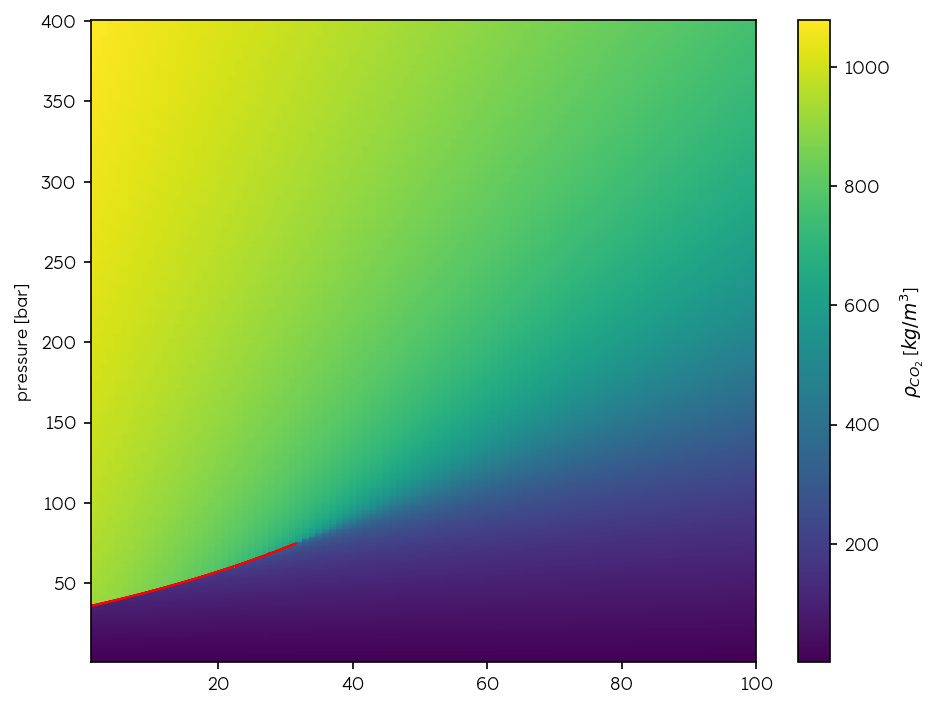

In [27]:
# Plot tables
fig, ax1 = plt.subplots()
# Plot density colormap
rho_pcm_co2 = ax1.pcolormesh(co2_pvt_data["temperature"], co2_pvt_data["pressure"], co2_pvt_data["pure_co2"]["rho"])


ax1.plot(pure_co2_T, pure_co2_P, c="r", lw=1)

ax1.set_ylabel("pressure [bar]")

ax1.set_xlim(1,100)

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")



fig.tight_layout()

In [28]:
length = 601

p = np.linspace(1, 400, length)
t = np.linspace(1, 400, length)

P_vals = p
T_vals = t
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

Tv, Pv = np.meshgrid(t, p)  #A 2D grid
Tv = Tv.flatten()           #The same grid flattened to a 1D vector
Pv = Pv.flatten()

Tv = Tv + 273.15
Pv = Pv*1e5


def retrieve_rho(state, p, t):
    # p and t are arrays, so we use np.vectorize to apply the function elementwise
    def _single(P, T):
        state.update(CP.PT_INPUTS, P, T)
        return state.keyed_output(CP.iDmass)
    vectorized = np.vectorize(_single)
    return vectorized(p, t)


rho_co2 = retrieve_rho(pure_co2_state, Pv, Tv)

rho_co2 = rho_co2.reshape((length, length))

# Update PVT tables

## pure CO2

In [ ]:
from pathlib import Path

new_pvt_path = Path('/workspaces/WINC_OnePager/src/WellClass/libs/pvt/pvt_constants')


length = 401

p = np.linspace(1, 400, length)
t = np.linspace(1, 400, length)



P_vals = p
T_vals = t
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

Tv, Pv = np.meshgrid(t, p)  #A 2D grid
Tv = Tv.flatten()           #The same grid flattened to a 1D vector
Pv = Pv.flatten()

Tv = Tv + 273.15
Pv = Pv*1e5


def retrieve_rho(state, p, t):
    # p and t are arrays, so we use np.vectorize to apply the function elementwise
    def _single(P, T):
        state.update(CP.PT_INPUTS, P, T)
        return state.keyed_output(CP.iDmass)
    vectorized = np.vectorize(_single)
    return vectorized(p, t)


rho_co2 = retrieve_rho(pure_co2_state, Pv, Tv)
rho_co2 = rho_co2.reshape((length, length))

rho_co2_path = new_pvt_path / 'pure_co2'
rho_co2_path.mkdir(parents=True, exist_ok=True)

np.savetxt(new_pvt_path / 'pressure.txt', p)
np.savetxt(new_pvt_path / 'temperature.txt', t)

np.savetxt(rho_co2_path / 'rho.txt', rho_co2)


# mixture 1

In [31]:
Pv.shape

(361201,)

In [ ]:

rho_mix1 = retrieve_rho(mix1_state, Pv, Tv)
rho_mix1 = rho_mix1.reshape((length, length))


rho_mix1_path = new_pvt_path / 'mix1'
rho_mix1_path.mkdir(parents=True, exist_ok=True)
np.savetxt(rho_mix1_path / 'rho.txt', rho_mix1)


# mixture 2

In [ ]:

rho_mix2 = retrieve_rho(mix2_state, Pv, Tv)
rho_mix2 = rho_mix2.reshape((length, length))


rho_mix2_path = new_pvt_path / 'mix2'
rho_mix2_path.mkdir(parents=True, exist_ok=True)
np.savetxt(rho_mix2_path / 'rho.txt', rho_mix2)


# water

In [ ]:
pure_h2o_component = ['H2O']
pure_h2o_mole_fraction = [1.0]

pure_h2o_state = CP.AbstractState("HEOS", "&".join(pure_h2o_component))
pure_h2o_state.set_mole_fractions(pure_h2o_mole_fraction)

pure_h2o_state.build_phase_envelope("dummy")
pure_h2o_PE = pure_h2o_state.get_phase_envelope_data()

pure_h2o_T, pure_h2o_P = refine_envelope(pure_h2o_PE)


rho_h2o = retrieve_rho(pure_h2o_state, Pv, Tv)
rho_h2o = rho_h2o.reshape((length, length))

rho_h2o_path = new_pvt_path / 'water'
rho_h2o_path.mkdir( parents=True, exist_ok=True)

np.savetxt(rho_h2o_path / 'rho.txt', rho_h2o)

/tmp/ipykernel_2309/3835437186.py:15: UserWarning: Adding colorbar to a different Figure <Figure size 960x720 with 8 Axes> than <Figure size 960x720 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(rho_pcm_h2o, label=r"$\rho_{H2O}$ [$kg/m^3$]")


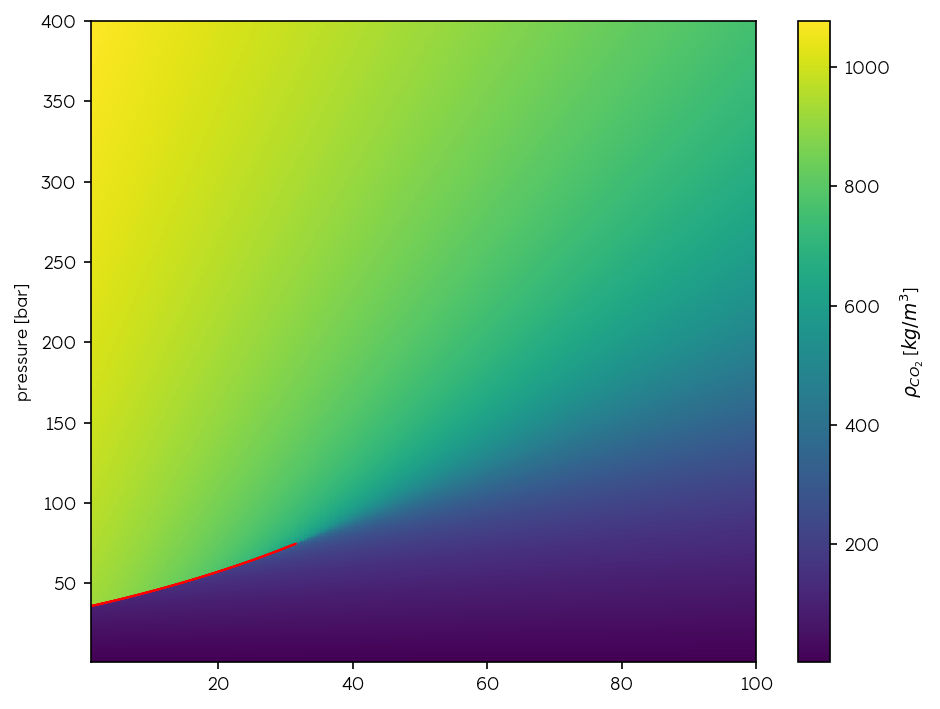

In [ ]:
# Plot tables
fig, ax1 = plt.subplots()
# Plot density colormap
rho_pcm_co2 = ax1.pcolormesh(t, p, rho_co2)


ax1.plot(pure_co2_T, pure_co2_P, c="r", lw=1)

ax1.set_ylabel("pressure [bar]")

ax1.set_xlim(1,100)

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")

fig.colorbar(rho_pcm_h2o, label=r"$\rho_{H2O}$ [$kg/m^3$]")


fig.tight_layout()

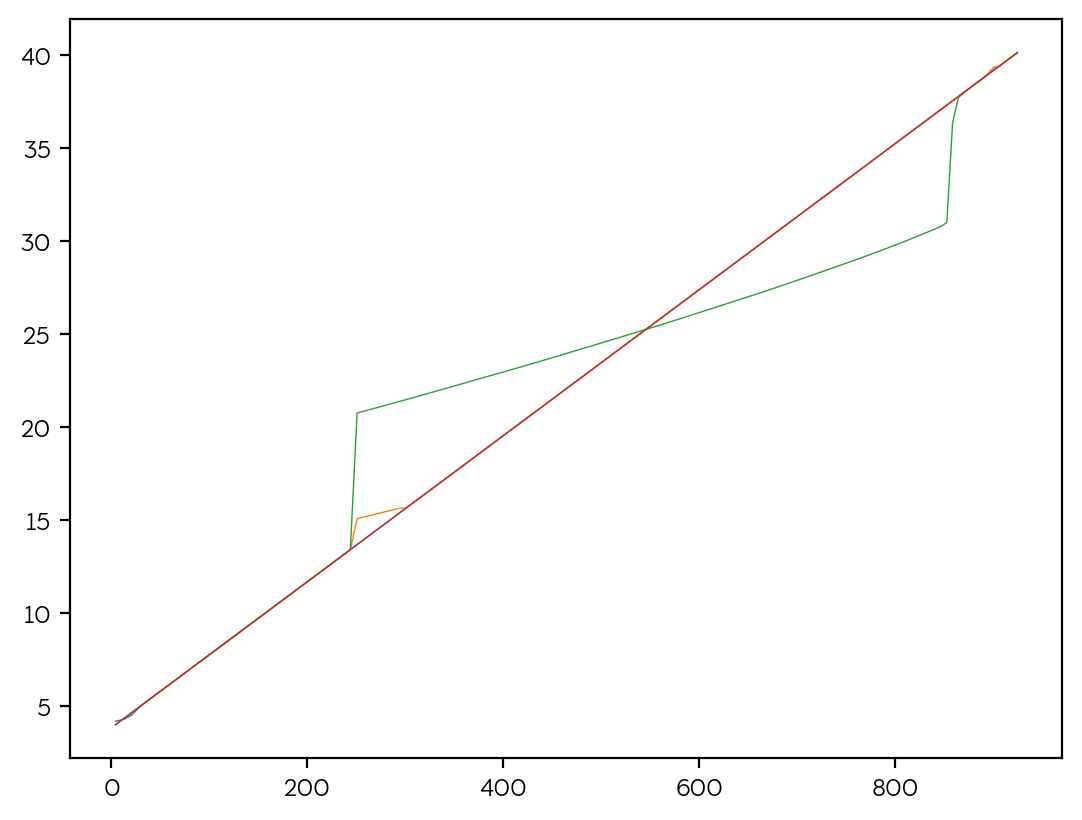

In [8]:
plt.plot(olga_pure_co2_122.iloc[:, 0], olga_pure_co2_122.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_94.iloc[:, 0], olga_pure_co2_94.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_75.iloc[:, 0], olga_pure_co2_75.iloc[:, 7], lw=0.5)
plt.plot(olga_pure_co2_47.iloc[:, 0], olga_pure_co2_47.iloc[:, 7], lw=0.5)

In [9]:
olga_pure_co2_75

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                         0.000000e+00                             
1                                         0.000000e+00                             
2                                         0.000000e+00                             
3                                         0.000000e+00                             
4                                         0.000000e+00                             
..                                                 ...                             
147                                       2.220446e-16                             
148                                       0.000000e+00                             
149                                       0.000000e+00                             
150                                       0.000000e+00                             
151                                       0.000000e+00                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              33.528831   
1                12.400000                              33.599892   
2                20.666666                              33.670959   
3                28.933332                              33.742008   
4                37.200001                              33.813049   
..                     ...                                    ...   
147             900.625000                              74.900139   
148             906.625000                              75.038681   
149             912.625000                              75.177063   
150             918.625000                              75.315308   
151             924.812500                              75.457687   

     Pipeline length [m].2  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                            87.640228                                                                                          
1                                            87.623428                                                                                          
2                                            87.635681                                                                                          
3                                            87.599068                                                                                          
4                                            87.591042                                                                                          
..                                                 ...                                                                                          
147                                         235.539597                                                                                          
148                                         235.230896                                                                                          
149                                         234.956802                                                                                          
150                

In [10]:
olga_pure_co2_94

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                                  0.0                             
1                                                  0.0                             
2                                                  0.0                             
3                                                  0.0                             
4                                                  0.0                             
..                                                 ...                             
147                                                1.0                             
148                                                1.0                             
149                                                1.0                             
150                                                1.0                             
151                                                1.0                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              35.946838   
1                12.400000                              36.026138   
2                20.666666                              36.105419   
3                28.933332                              36.184662   
4                37.200001                              36.263870   
..                     ...                                    ...   
147             900.625000                              94.100540   
148             906.625000                              94.448624   
149             912.625000                              94.795631   
150             918.625000                              95.141006   
151             924.812500                              95.495430   

     Pipeline length [m].2  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                            97.800659                                                                                          
1                                            97.767570                                                                                          
2                                            97.732582                                                                                          
3                                            97.697472                                                                                          
4                                            97.662231                                                                                          
..                                                 ...                                                                                          
147                                         591.750610                                                                                          
148                                         590.973694                                                                                          
149                                         588.153870                                                                                          
150                

In [11]:
olga_pure_co2_122.head(50)

Pipeline length [m]  \
0              4.133333   
1             12.400000   
2             20.666666   
3             28.933332   
4             37.200001   
5             45.466667   
6             53.733334   
7             62.000000   
8             70.266670   
9             78.533333   
10            86.800003   
11            95.066666   
12           103.333336   
13           111.599998   
14           119.866669   
15           128.133331   
16           136.399994   
17           144.666672   
18           152.933334   
19           161.199997   
20           169.466660   
21           177.733337   
22           186.000000   
23           194.266663   
24           202.533340   
25           210.800003   
26           219.066666   
27           227.333328   
28           235.600006   
29           243.866669   
30           250.750000   
31           256.250000   
32           261.750000   
33           267.250000   
34           272.750000   
35           278.250000   
36           283.750000   
37           289.250000   
38           294.750000   
39           300.250000   
40           305.750000   
41           311.250000   
42           316.750000   
43           322.250000   
44           327.750000   
45           333.250000   
46           338.750000   
47           344.250000   
48           349.750000   
49           355.250000   

    HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                        8.066597e-04                             
1                                        1.182885e-03                             
2                                        2.673091e-06                             
3                                        1.190479e-07                             
4                                        1.602940e-10                             
5                                        0.000000e+00                             
6                                        0.000000e+00                             
7                                        1.110223e-16                             
8                                        0.000000e+00                             
9                                        0.000000e+00                             
10                                       0.000000e+00                             
11                                       2.220446e-16                             
12                                       0.000000e+00                             
13                                       0.000000e+00                             
14                                       0.000000e+00                             
15                                       0.000000e+00                             
16                                       0.000000e+00                             
17                                       0.000000e+00                             
18                                       0.000000e+00                             
19                                       0.000000e+00                             
20                                       1.110223e-16                             
21                                       1.110223e-16                             
22                                       0.000000e+00                             
23                                       0.000000e+00                             
24                                       0.000000e+00                             
25                                       0.000000e+00                             
26                                       0.000000e+00                             
27                                       0.000000e+00                             
28                                       1.110223e-16                             
29                                       0.000000e+00                             
30                                       1.000000e+00

In [12]:
sf_depth_msl = 312  # Water depth [meters]
sf_temp_degc = 4  # temperature at sea floor [degC]
field_fluid_type = "pure_co2"

p_models = {}
olga_dict = {}

delta_z_cases = dict()

for olga_case in olga_tables:
    geo_tgrad = 1e3 * ((olga_case.iloc[-1, 7] - 4.000000) / (924.812500 - 4.133333))

    z_eq = ((olga_case.iloc[-1, 7] - sf_temp_degc) / (geo_tgrad / 1e3)) + sf_depth_msl

    delta_z = z_eq - olga_case.iloc[-1, 0]

    CO2_contact = z_eq  # CO2 water contact mTVDMSL
    press = olga_case.iloc[-1, 3]
    press_label = f"{press:.2f}"

    delta_z_cases[press_label] = delta_z

    print(f"{geo_tgrad=} {sf_temp_degc=} {CO2_contact=} {field_fluid_type=} {press=}")

    olga_dict[press_label] = olga_case
    # '''Constants'''

    # geo_tgrad = 40 #geothermal gradient [degc/km]
    p_models[press_label] = Pressure(
        # wellbore seafloor depth mTVD MSL.
        sf_depth_msl=sf_depth_msl,  # wellbore.water_depth,
        # wellbore total depth in mTVD RKB
        well_td_rkb=5e3,  # total_depth_rkb,
        # wellbore rkb in mTVD RKB
        well_rkb=0,
        # seafloor temperature in degC
        sf_temp=sf_temp_degc,  # DEFAULT_SEAFLOOR_TEMPERATURE,
        # geothermal gradient in degC/km
        geo_tgrad=geo_tgrad,  # DEFAULT_GEOTHERMAL_GRADIENT,
        fluid_type=field_fluid_type,  # type: ignore
        # path to the pvt constants folder
        pvt_path=pvt_path,
        z_fluid_contact=CO2_contact,  # wellbore_settings.pressure_datum_tvd_msl,  # type: ignore
        p_fluid_contact=press,  # wellbore_settings.reservoir_pressure_bar,  # type: ignore
        # specific_gravity=None,  # type: ignore
        # ip_shmin_data=shmin_data,
        shmin_gradient=0.3,
    )

geo_tgrad=np.float64(39.26466790918936) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(123.02449798584)
Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.26493722702677) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(95.4954299926758)
Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.26460161556778) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(75.4576873779297)
Computing pressure profile for scenario: hydrostatic
geo_tgrad=np.float64(39.264493888432796) sf_temp_degc=4 CO2_contact=np.float64(1232.679167) field_fluid_type='pure_co2' press=np.float64(47.751220703125)
Computing pressure profile for scenario: hydrostatic


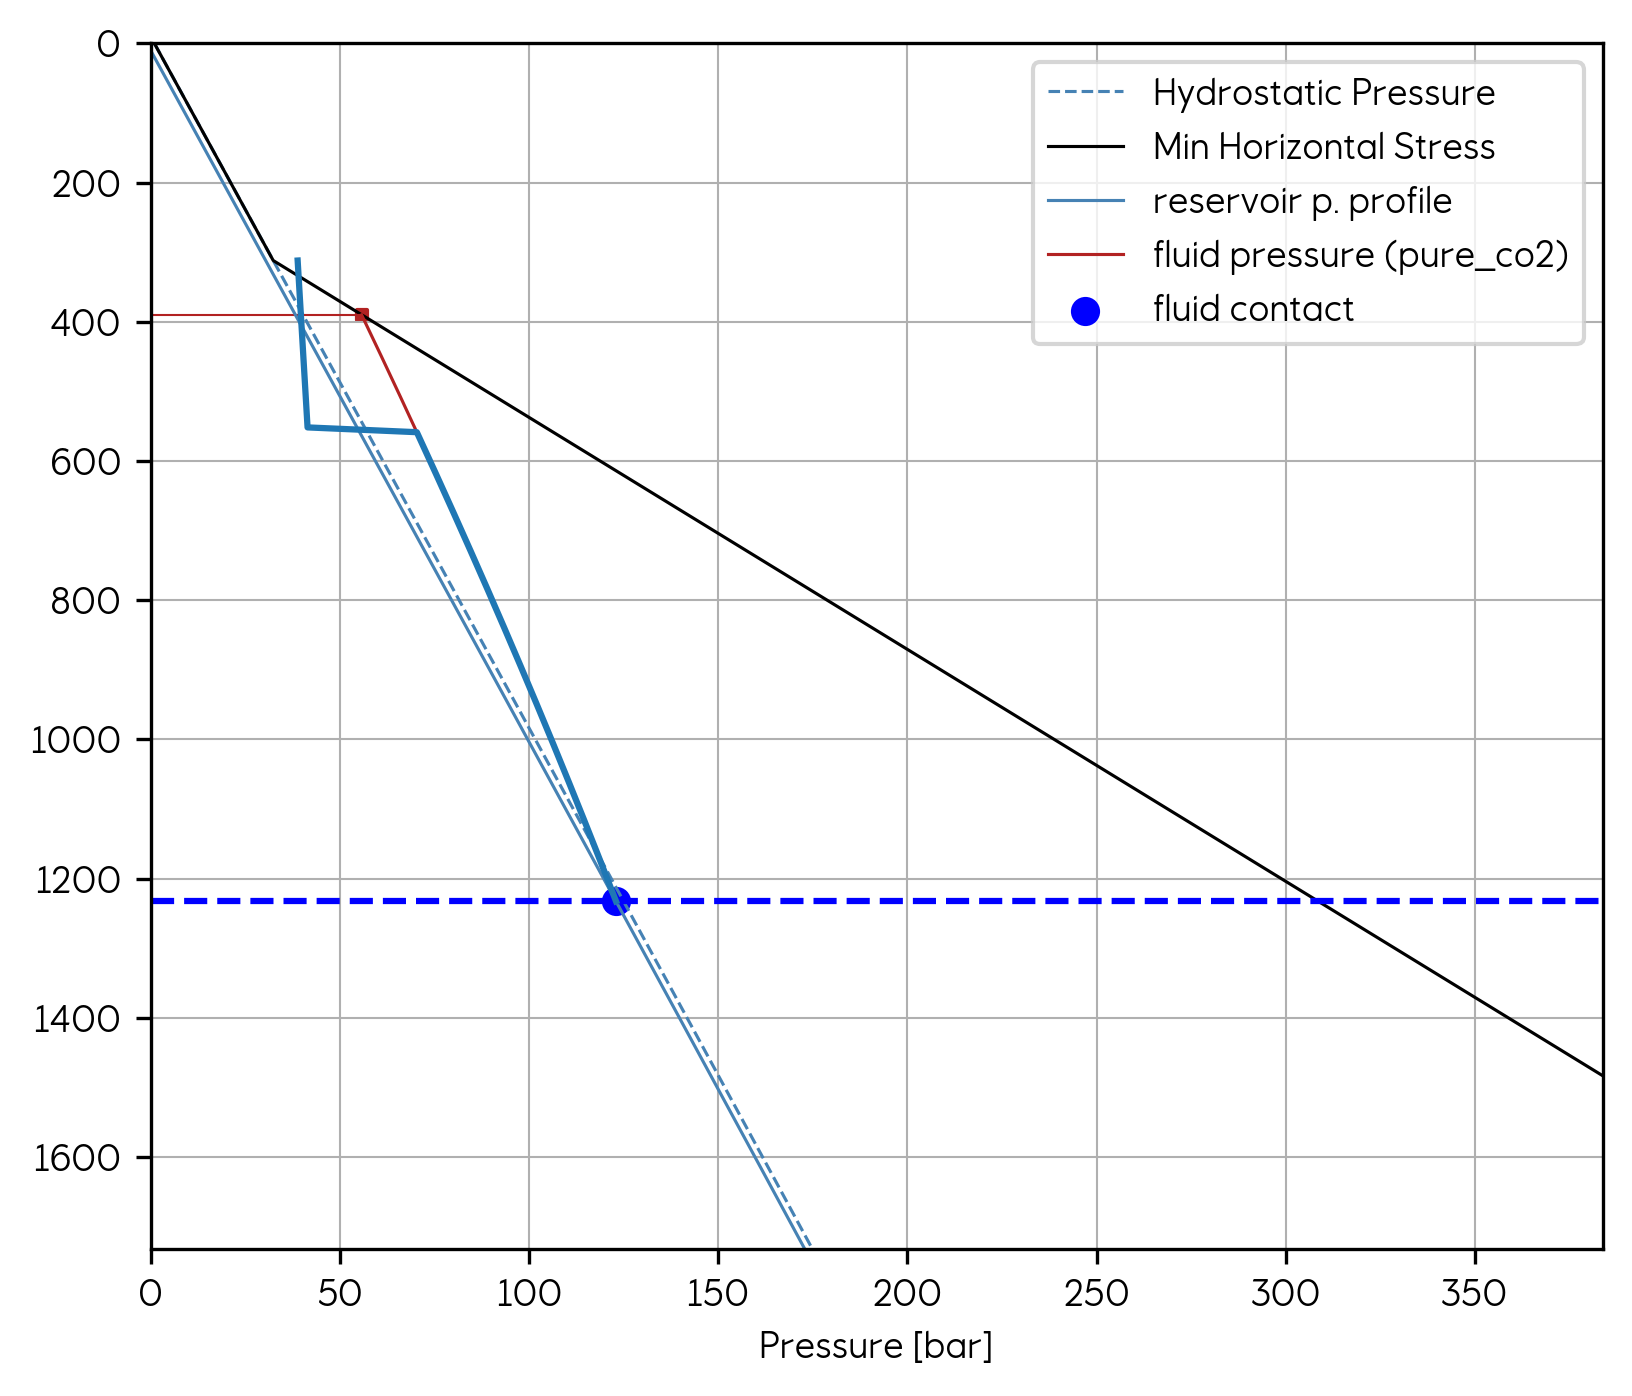

In [13]:
rcParams["figure.dpi"] = 300

width_cm = 14  # cm
height_cm = 12  # cm

width = width_cm / 2.54
height = height_cm / 2.54

fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = "123.02"

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

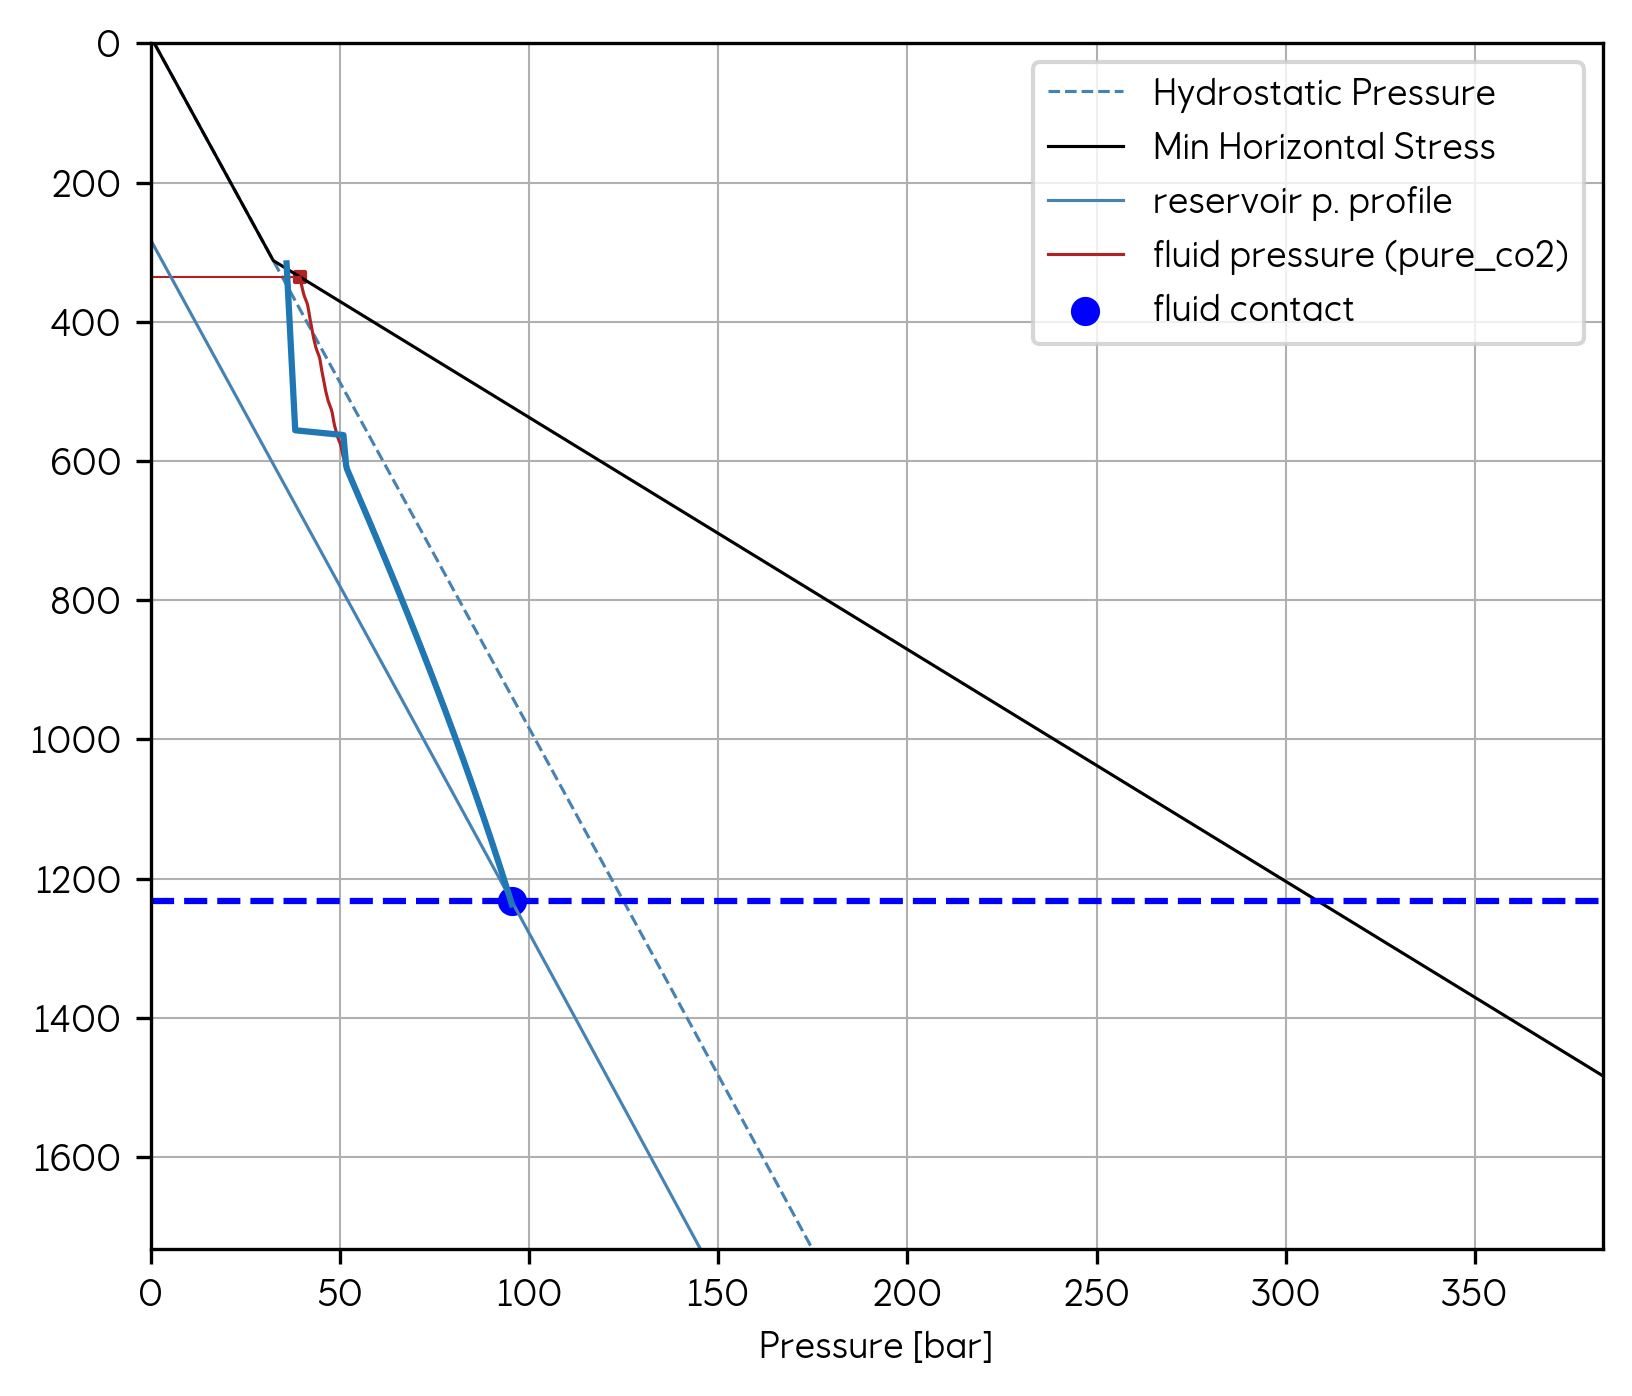

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[1]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

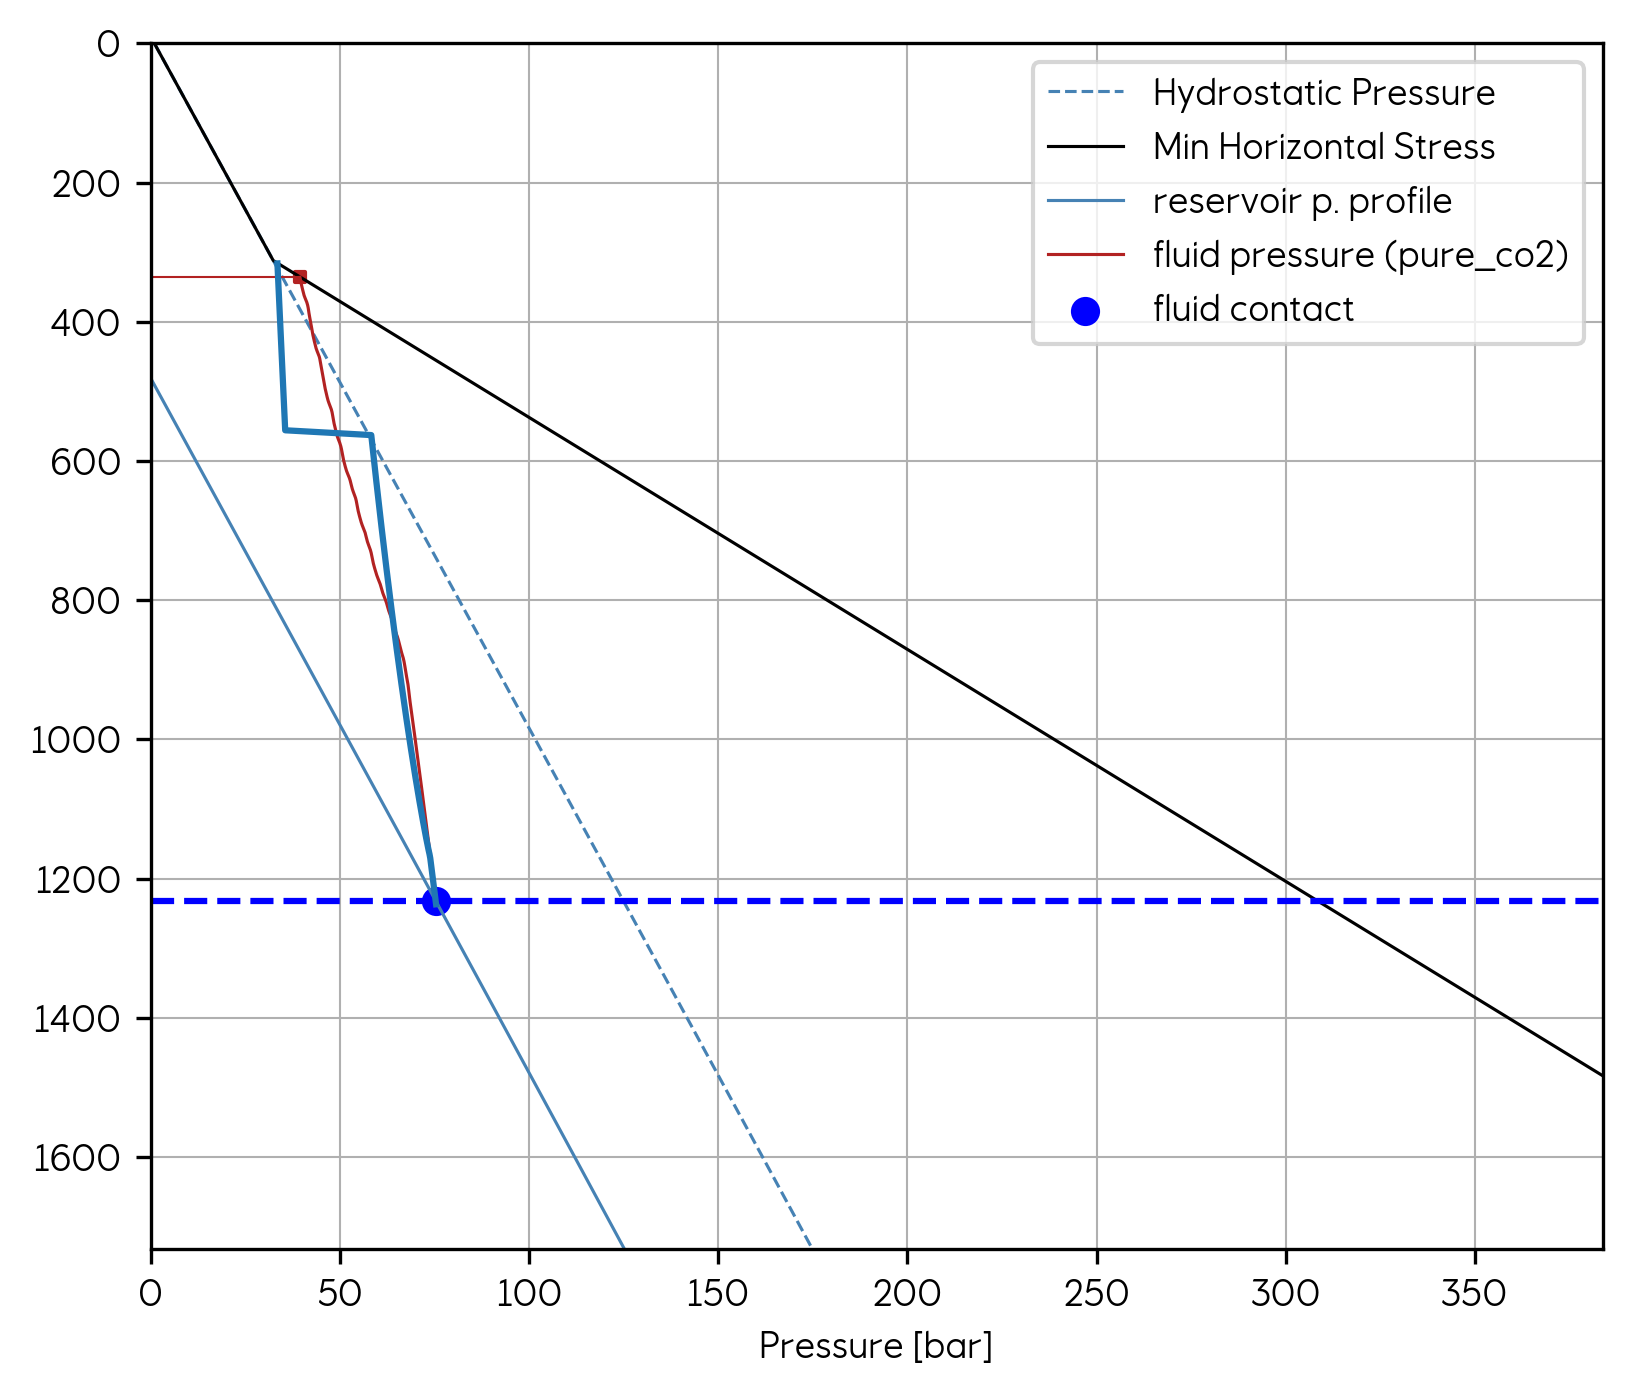

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[2]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

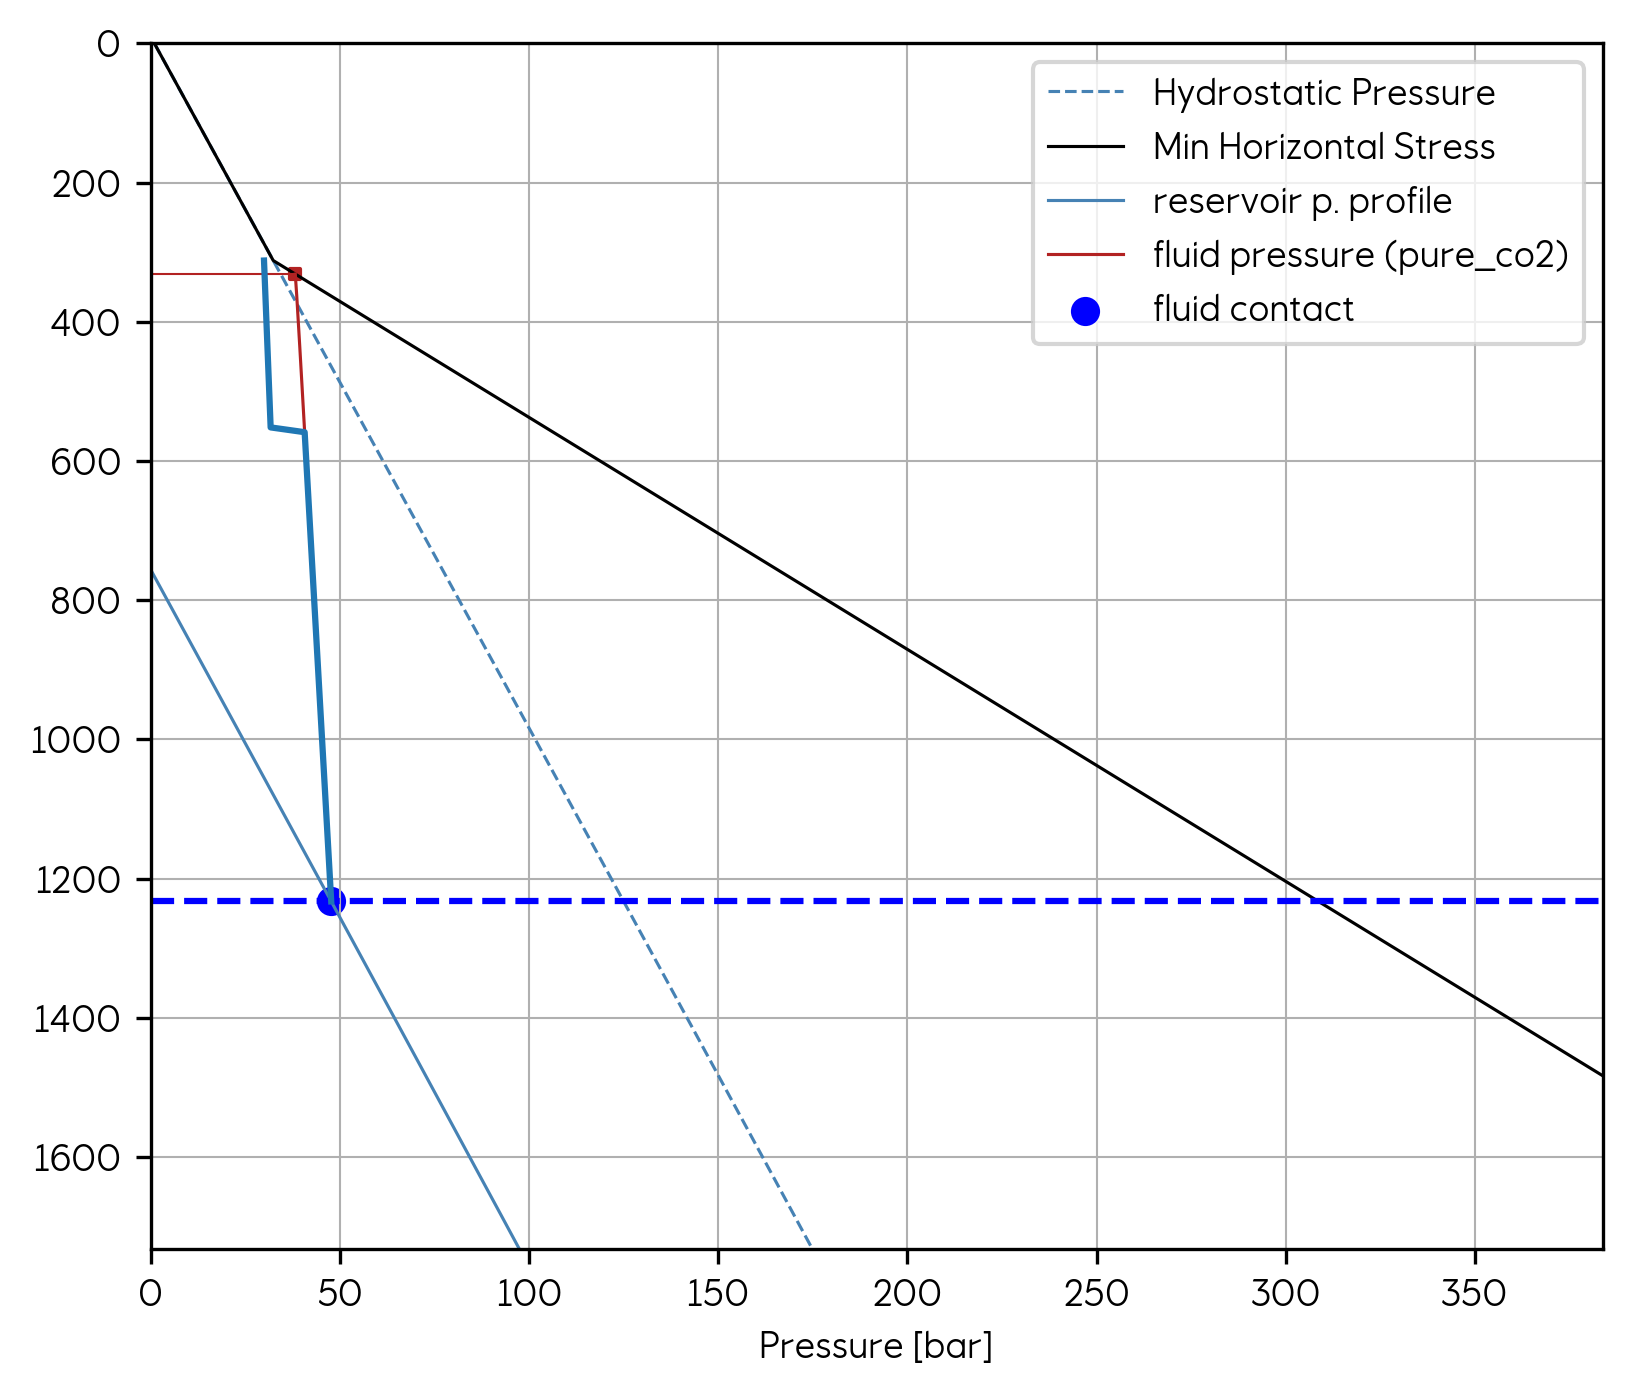

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[3]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

In [17]:
13.98 / (const.inch * 100)

5.503937007874016

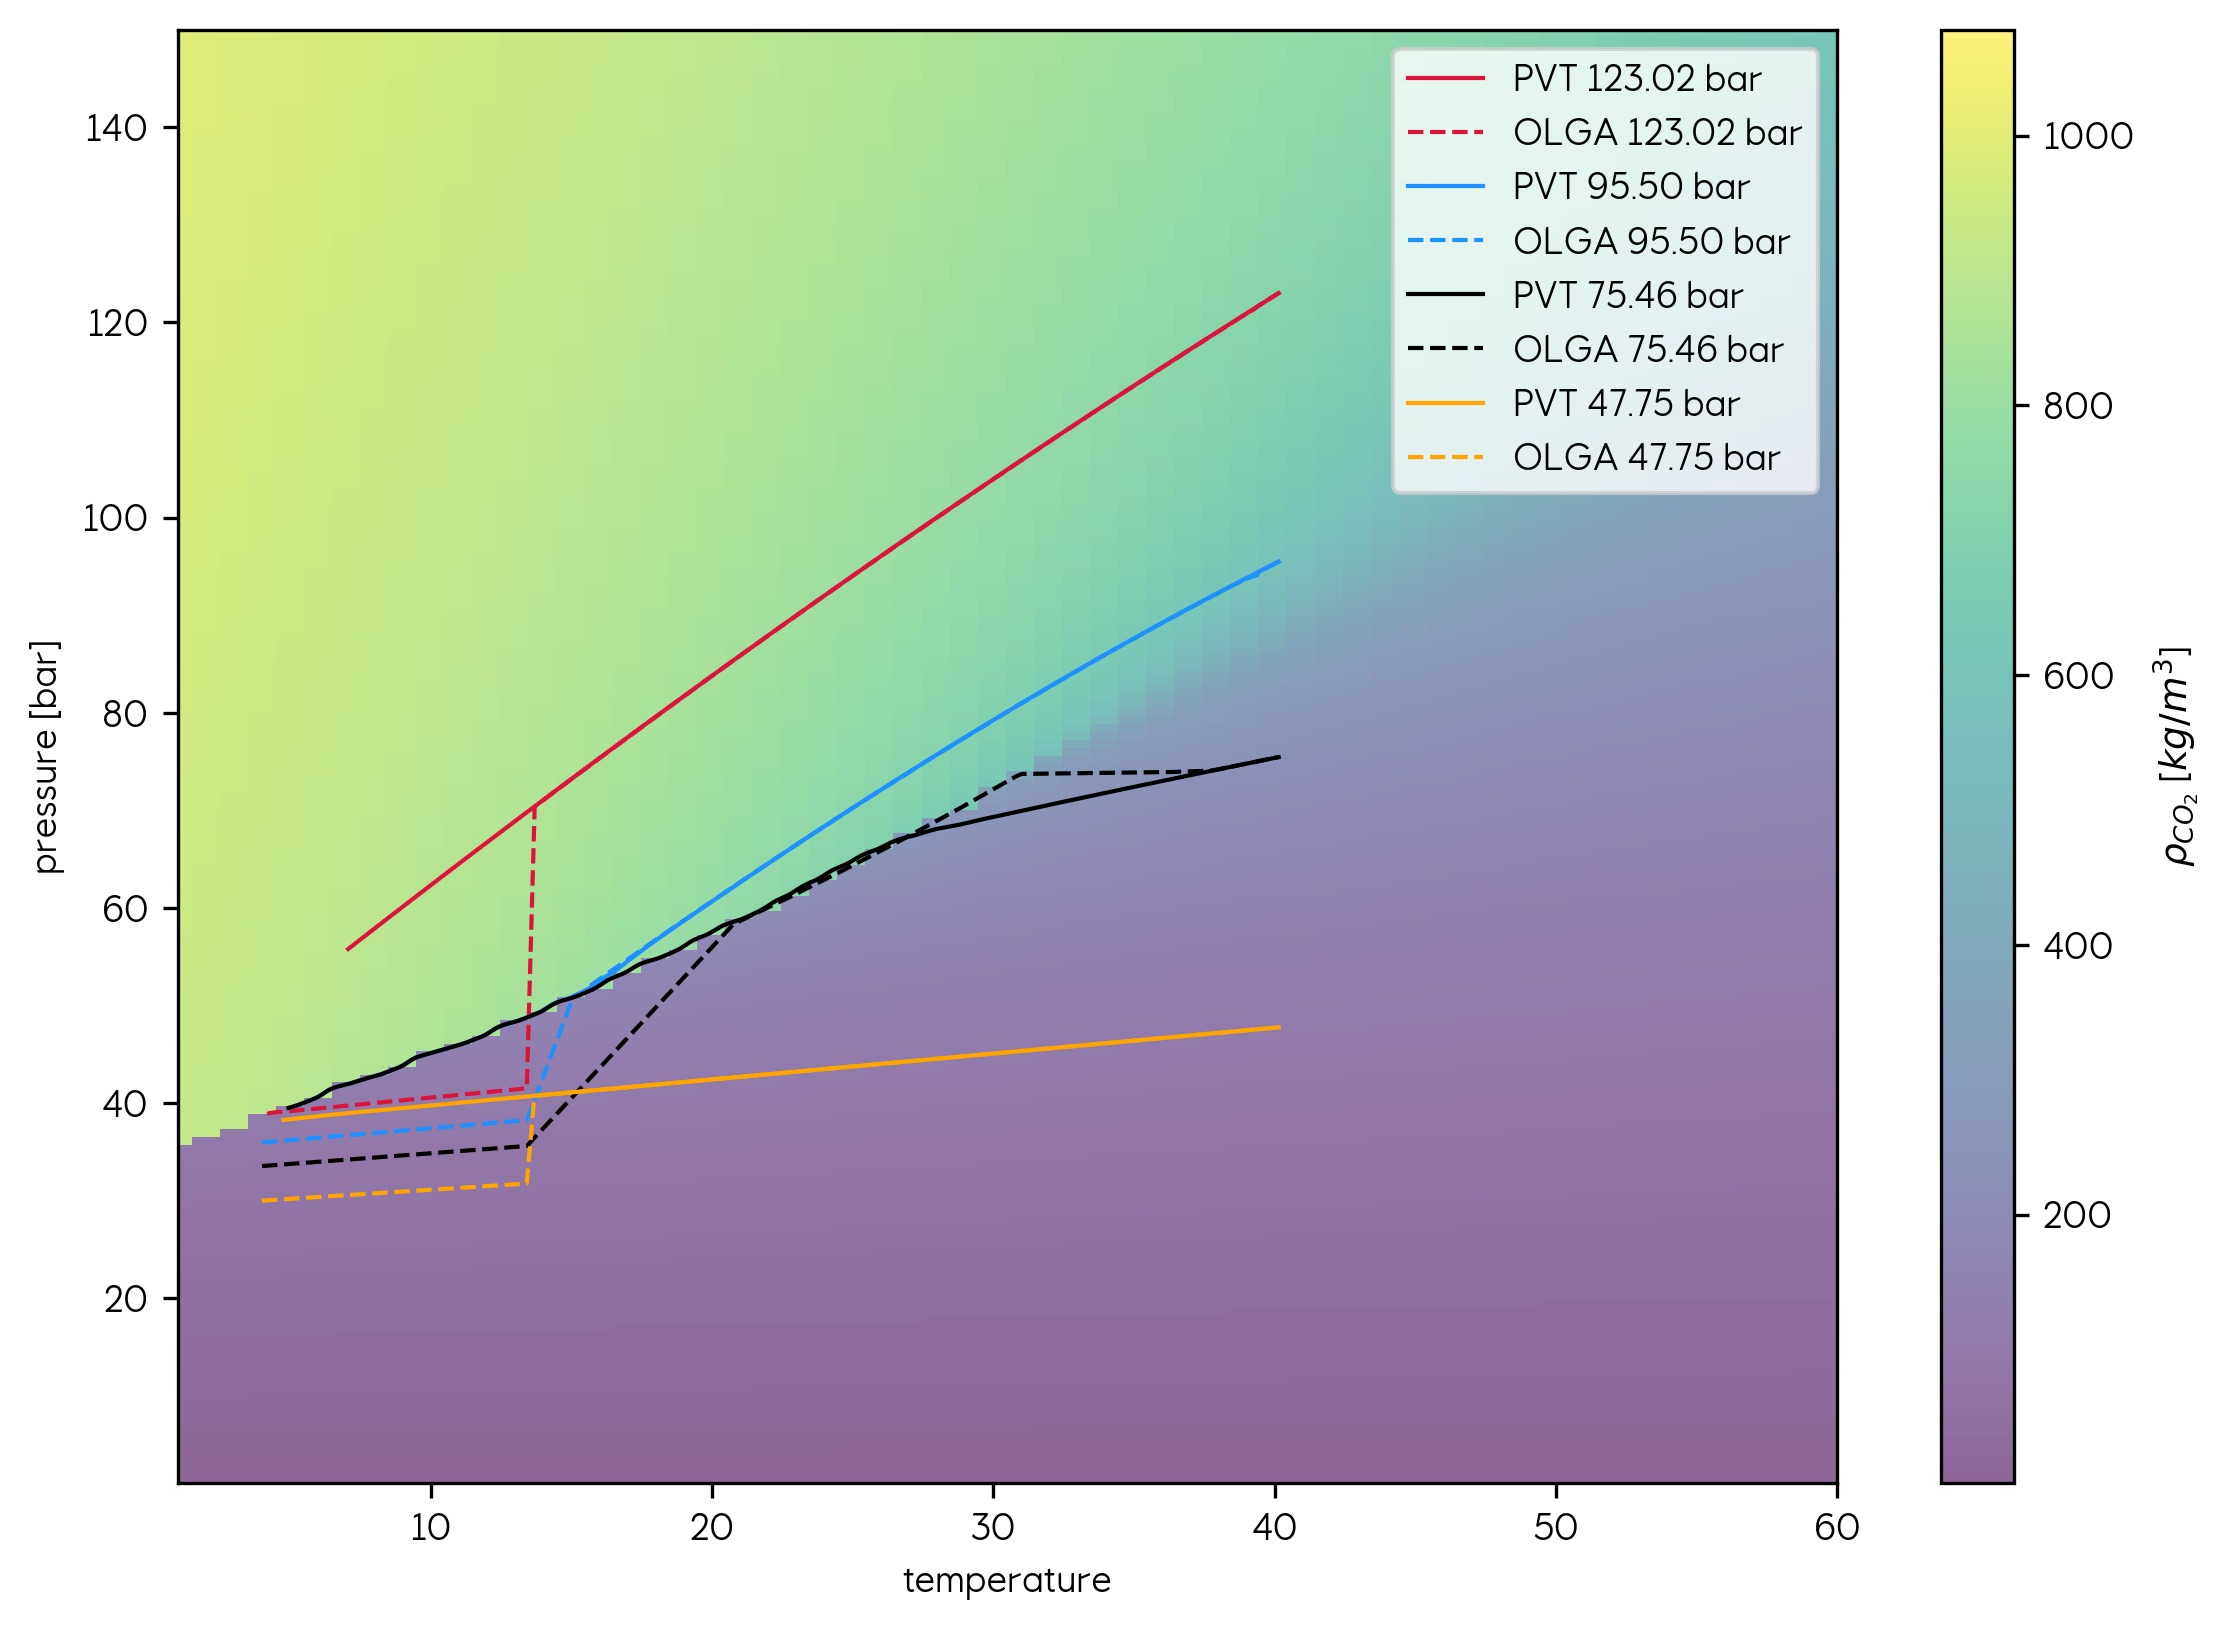

In [18]:
# Plot tables
from itertools import cycle

height = 13.98 / (const.inch * 100)
width = 19.5 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_co2 = ax.pcolormesh(co2_pvt_data["temperature"], co2_pvt_data["pressure"], co2_pvt_data["pure_co2"]["rho"], alpha=0.6)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")

color_cycle = cycle(["#DC143C", "#1E90FF", "k", "#FFA500"])


# ax.plot(olga_pure_co2_122.iloc[:,7], olga_pure_co2_122.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_94.iloc[:,7], olga_pure_co2_94.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_75.iloc[:,7], olga_pure_co2_75.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_47.iloc[:,7], olga_pure_co2_47.iloc[:,3], color=next(color_cycle))

for scenario, color in zip(p_models, color_cycle):
    p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
        "temperature", "fluid_pressure", ax=ax, color=color, label=f"PVT {scenario} bar", lw=1
    )

    ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

ax.set_xlim(1, 60)

ax.set_ylim(1, 150)
ax.legend()

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()

In [19]:
scenario = "95.50"
df = p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves

df[~df["fluid_pressure"].isna()]

depth  temperature  hydrostatic_pressure  \
336.000000    336.000000     4.942358             34.843219   
337.000000    337.000000     4.981623             34.943961   
338.000000    338.000000     5.020888             35.044704   
339.000000    339.000000     5.060153             35.145447   
340.000000    340.000000     5.099418             35.246190   
...                  ...          ...                   ...   
1229.000000  1229.000000    40.005947            124.664362   
1230.000000  1230.000000    40.045212            124.764579   
1231.000000  1231.000000    40.084477            124.864795   
1232.000000  1232.000000    40.123742            124.965010   
1232.679167  1232.679167    40.143375            125.015116   

             min_horizontal_stress  fluid_pressure  brine_pressure  
336.000000               39.625442       39.495647        5.428068  
337.000000               39.925442       39.526138        5.528674  
338.000000               40.225442       39.557208        5.629281  
339.000000               40.525442       39.589029        5.729887  
340.000000               40.825442       39.621771        5.830493  
...                            ...             ...             ...  
1229.000000             307.525442       95.285243       95.127189  
1230.000000             307.825442       95.342433       95.227279  
1231.000000             308.125442       95.399577       95.327367  
1232.000000             308.425442       95.456676       95.427455  
1232.679167             308.575442       95.485203       95.477498  

[898 rows x 6 columns]

In [20]:
olga_dict[scenario]["depth"] = olga_dict[scenario].iloc[:, 0] + sf_depth_msl
olga_dict[scenario]

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                                  0.0                             
1                                                  0.0                             
2                                                  0.0                             
3                                                  0.0                             
4                                                  0.0                             
..                                                 ...                             
147                                                1.0                             
148                                                1.0                             
149                                                1.0                             
150                                                1.0                             
151                                                1.0                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              35.946838   
1                12.400000                              36.026138   
2                20.666666                              36.105419   
3                28.933332                              36.184662   
4                37.200001                              36.263870   
..                     ...                                    ...   
147             900.625000                              94.100540   
148             906.625000                              94.448624   
149             912.625000                              94.795631   
150             918.625000                              95.141006   
151             924.812500                              95.495430   

     Pipeline length [m].2  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                            97.800659                                                                                          
1                                            97.767570                                                                                          
2                                            97.732582                                                                                          
3                                            97.697472                                                                                          
4                                            97.662231                                                                                          
..                                                 ...                                                                                          
147                                         591.750610                                                                                          
148                                         590.973694                                                                                          
149                                         588.153870                                                                                          
150                

# Mixture 1

In [21]:
mix1_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix1_path_name)

In [22]:
mix1_path_name

'mixture1'

In [23]:
mix1_mixture_info

{'name': 'mixture1',
 'composition': '96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4'}

In [ ]:
mix1_pvt_data['temperature'].shape

(501,)

In [ ]:
p = np.linspace(1, 400, 501)
t = np.linspace(1, 400, 501)

P_vals = p
T_vals = t
P_Pa = P_vals *1e5
T_Ke = T_vals + 273.15

rho_vals = []

Tv, Pv = np.meshgrid(t, p)  #A 2D grid
Tv = Tv.flatten()           #The same grid flattened to a 1D vector
Pv = Pv.flatten()

Tv = Tv + 273.15
Pv = Pv*1e5

# Retrieve mass density from CoolProp
for P, T in zip(P_Pa, T_Ke):
    pure_co2_state.update(CP.PT_INPUTS, P, T)
    rho = pure_co2_state.keyed_output(CP.iDmass)
    rho_vals.append(rho)


def retrieve_rho(state, p, t):
    # p and t are arrays, so we use np.vectorize to apply the function elementwise
    def _single(P, T):
        state.update(CP.PT_INPUTS, P, T)
        return state.keyed_output(CP.iDmass)
    vectorized = np.vectorize(_single)
    return vectorized(p, t)


rho_co2 = retrieve_rho(pure_co2_state, Pv, Tv)

rho_co2 = rho_co2.reshape((501, 501))


In [57]:
rho_co2

array([[1.94351648e+00, 1.93775315e+00, 1.93202472e+00, ...,
        7.88259069e-01, 7.87322255e-01, 7.86387668e-01],
       [3.51316181e+00, 3.50256110e+00, 3.49202689e+00, ...,
        1.41738539e+00, 1.41569910e+00, 1.41401683e+00],
       [5.09994491e+00, 5.08428280e+00, 5.06872248e+00, ...,
        2.04659497e+00, 2.04415752e+00, 2.04172590e+00],
       ...,
       [1.07804933e+03, 1.07563432e+03, 1.07321541e+03, ...,
        2.97924114e+02, 2.97489217e+02, 2.97055840e+02],
       [1.07824942e+03, 1.07583628e+03, 1.07341925e+03, ...,
        2.98443036e+02, 2.98007440e+02, 2.97573367e+02],
       [1.07844923e+03, 1.07603795e+03, 1.07362280e+03, ...,
        2.98961530e+02, 2.98525237e+02, 2.98090469e+02]], shape=(501, 501))

In [58]:
co2_pvt_data["pure_co2"]["rho"]

array([[1.94351648e+00, 1.93631419e+00, 1.92916635e+00, ...,
        6.86348517e-01, 6.85460682e-01, 6.84575143e-01],
       [3.51316181e+00, 3.49991473e+00, 3.48677140e+00, ...,
        1.23399285e+00, 1.23239555e+00, 1.23080239e+00],
       [5.09994491e+00, 5.08037345e+00, 5.06096079e+00, ...,
        1.78158139e+00, 1.77927377e+00, 1.77697214e+00],
       ...,
       [1.07804933e+03, 1.07502845e+03, 1.07200144e+03, ...,
        2.53177576e+02, 2.52807929e+02, 2.52439543e+02],
       [1.07824942e+03, 1.07523087e+03, 1.07220624e+03, ...,
        2.53623257e+02, 2.53252995e+02, 2.52883997e+02],
       [1.07844923e+03, 1.07543302e+03, 1.07241074e+03, ...,
        2.54068639e+02, 2.53697764e+02, 2.53328155e+02]], shape=(501, 501))

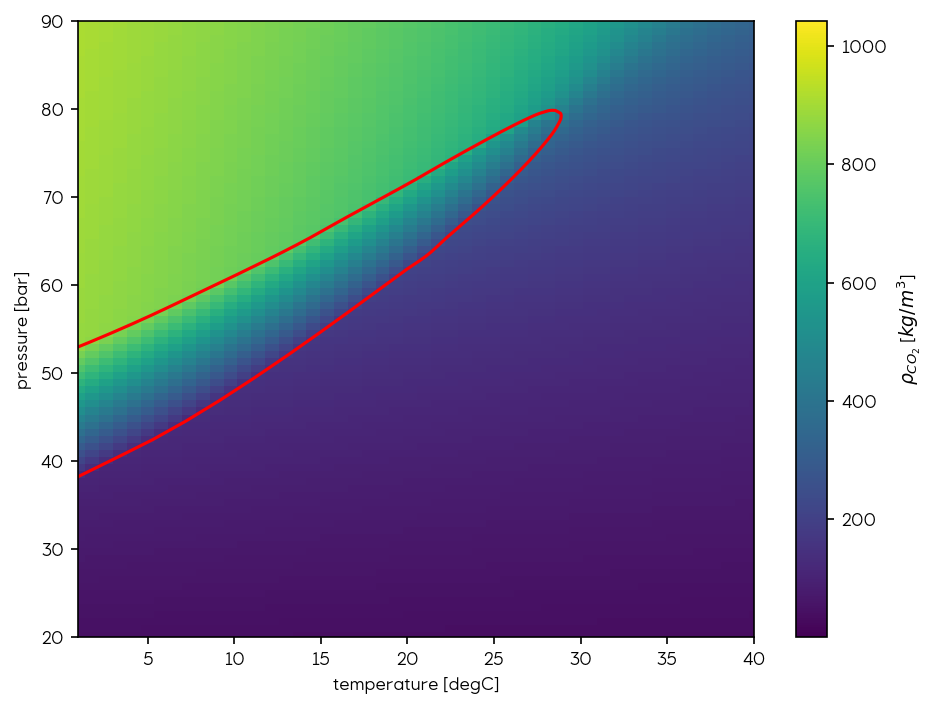

In [ ]:
# Plot tables
fig, ax = plt.subplots()
# Plot density colormap
rho_pcm_co2 = ax.pcolormesh(np.linspace(1,400, 501), np.linspace(1,400, 501), mix1_pvt_data[mix1_path_name]["rho"])

ax.plot(mix1_T, mix1_P, c='r')

ax.set_xlabel("temperature [degC]")

ax.set_ylabel("pressure [bar]")

ax.set_xlim(1,40)
ax.set_ylim(20,90)

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()

In [25]:
olga_mix1_122 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=0, usecols=range(8))
olga_mix1_94 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=1, usecols=range(8))
olga_mix1_75 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=2, usecols=range(8))
olga_mix1_47 = pd.read_excel(r"./olga_ref_runs/Mixture_1.xlsx", sheet_name=3, usecols=range(8))


olga_tables = [olga_mix1_122, olga_mix1_94, olga_mix1_75, olga_mix1_47]

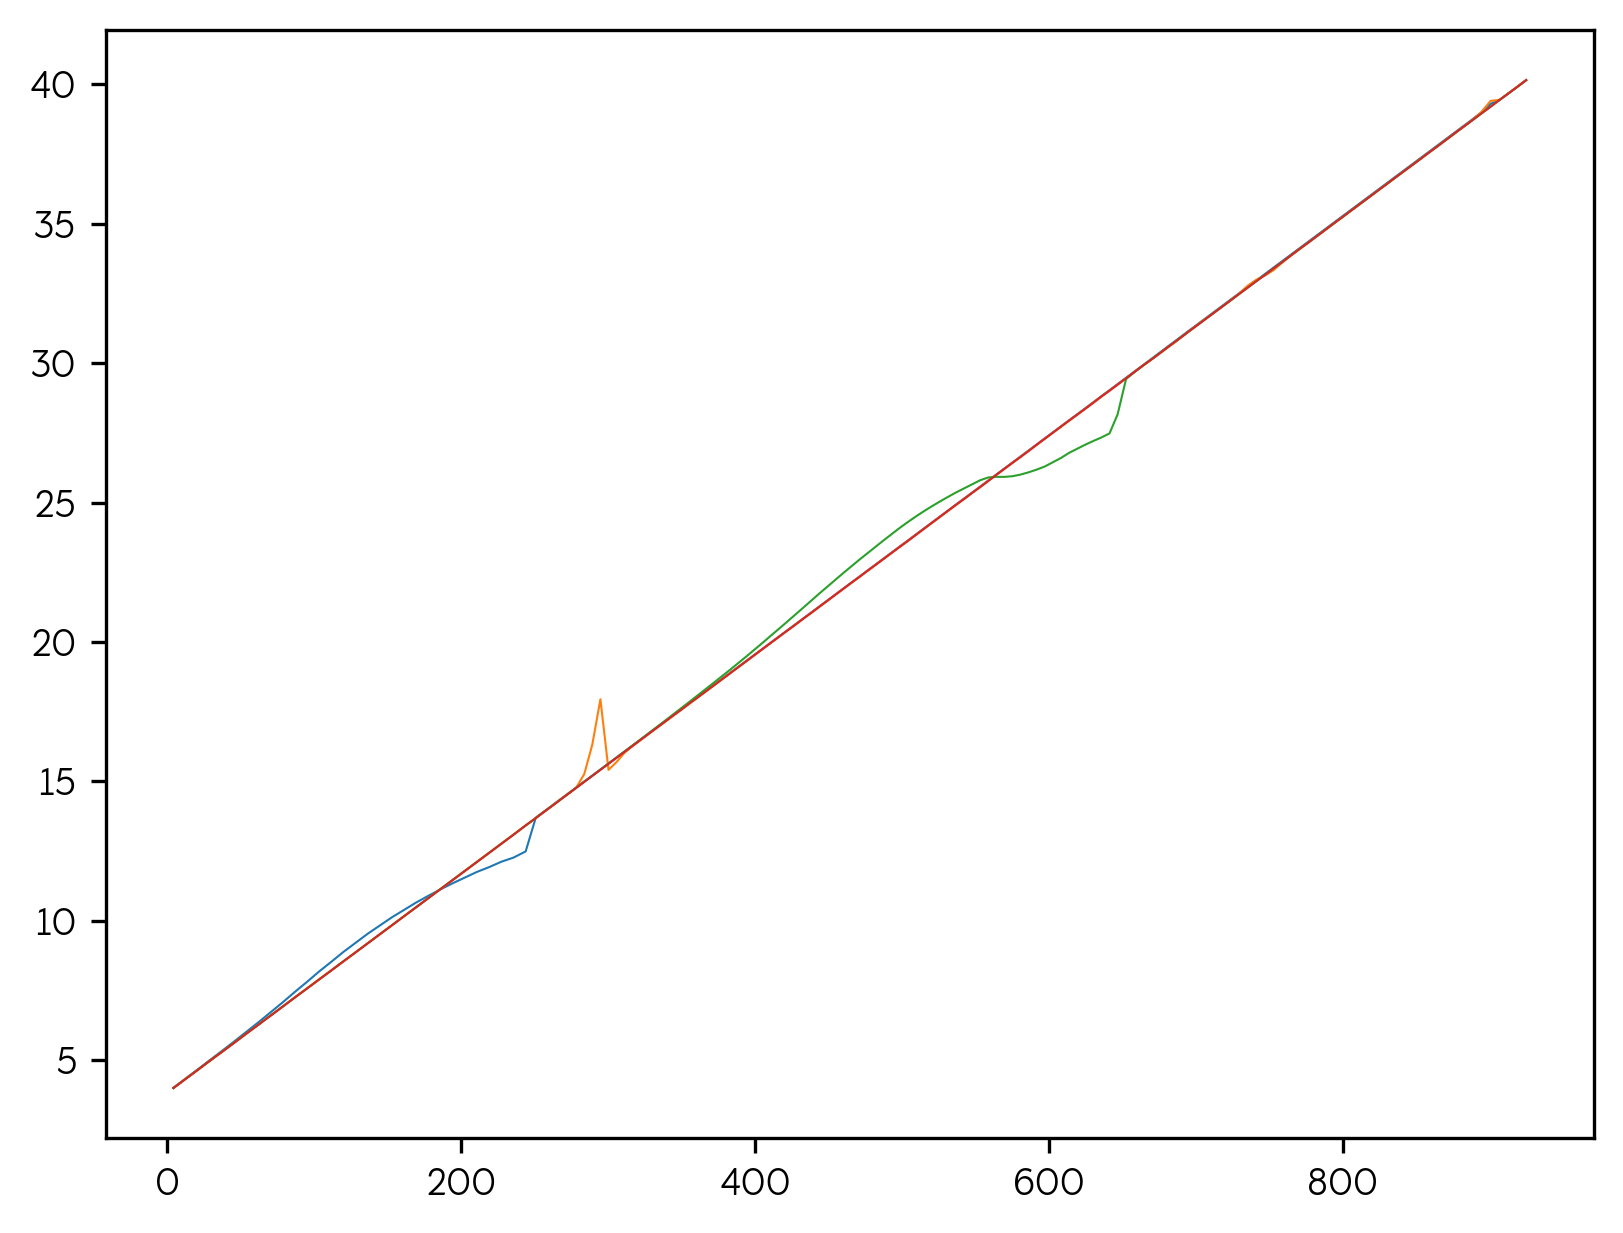

In [26]:
fig, ax = plt.subplots()

for table in olga_tables:
    ax.plot(table.iloc[:, 0], table.iloc[:, 5], lw=0.5)

# plt.plot(olga_pure_co2_122.iloc[:, 0], olga_pure_co2_122.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_94.iloc[:, 0], olga_pure_co2_94.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_75.iloc[:, 0], olga_pure_co2_75.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_47.iloc[:, 0], olga_pure_co2_47.iloc[:, 7], lw=0.5)

In [27]:
olga_mix1_122

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                             0.000070                             
1                                             0.001209                             
2                                             0.000128                             
3                                             0.001992                             
4                                             0.000177                             
..                                                 ...                             
147                                           1.000000                             
148                                           1.000000                             
149                                           1.000000                             
150                                           1.000000                             
151                                           1.000000                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              45.046581   
1                12.400000                              45.148140   
2                20.666666                              45.250332   
3                28.933332                              45.353180   
4                37.200001                              45.456680   
..                     ...                                    ...   
147             900.625000                             121.299896   
148             906.625000                             121.644600   
149             912.625000                             121.988899   
150             918.625000                             122.332298   
151             924.812500                             122.685600   

     Pipeline length [m].2  TM [C] (CHANNEL  PACTH) "Fluid temperature"  \
0                 4.133333                                     4.007951   
1                12.400000                                     4.335018   
2                20.666666                                     4.664342   
3                28.933332                                     4.994618   
4                37.200001                                     5.329660   
..                     ...                                          ...   
147             900.625000                                    39.301880   
148             906.625000                                    39.438061   
149             912.625000                                    39.673229   
150             918.625000                                    39.908340   
151             924.812500                                    40.150391   

     Pipeline length [m].3  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  
0                                           124.890800                                                                                         
1                                           126.471100                                                                                         
2                                           126.505302                                                                                  

In [28]:
sf_depth_msl = 312  # Water depth [meters]
sf_temp_degc = 4  # temperature at sea floor [degC]
field_fluid_type = "mixture1"

p_models = {}
olga_dict = {}

delta_z_cases = dict()

for olga_case in olga_tables:
    geo_tgrad = 1e3 * ((olga_case.iloc[-1, 5] - 4.000000) / (924.812500 - 4.133333))

    z_eq = ((olga_case.iloc[-1, 5] - sf_temp_degc) / (geo_tgrad / 1e3)) + sf_depth_msl

    delta_z = z_eq - olga_case.iloc[-1, 0]

    CO2_contact = z_eq  # CO2 water contact mTVDMSL
    press = olga_case.iloc[-1, 3]
    press_label = f"{press:.2f}"
    print(f"{press_label=}")
    delta_z_cases[press_label] = delta_z

    print(f"{geo_tgrad=} {sf_temp_degc:.2f} {CO2_contact=} {field_fluid_type=} {press=}")

    olga_dict[press_label] = olga_case
    # '''Constants'''

    # geo_tgrad = 40 #geothermal gradient [degc/km]
    p_models[press_label] = Pressure(
        # wellbore seafloor depth mTVD MSL.
        sf_depth_msl=sf_depth_msl,  # wellbore.water_depth,
        # wellbore total depth in mTVD RKB
        well_td_rkb=5e3,  # total_depth_rkb,
        # wellbore rkb in mTVD RKB
        well_rkb=0,
        # seafloor temperature in degC
        sf_temp=sf_temp_degc,  # DEFAULT_SEAFLOOR_TEMPERATURE,
        # geothermal gradient in degC/km
        geo_tgrad=geo_tgrad,  # DEFAULT_GEOTHERMAL_GRADIENT,
        fluid_type=field_fluid_type,  # type: ignore
        # path to the pvt constants folder
        pvt_path=pvt_path,
        z_fluid_contact=CO2_contact,  # wellbore_settings.pressure_datum_tvd_msl,  # type: ignore
        p_fluid_contact=press,  # wellbore_settings.reservoir_pressure_bar,  # type: ignore
        # specific_gravity=None,  # type: ignore
        # ip_shmin_data=shmin_data,
        shmin_gradient=0.3,
    )

press_label='122.69'
geo_tgrad=np.float64(39.264916510270076) 4.00 CO2_contact=np.float64(1232.679167) field_fluid_type='mixture1' press=np.float64(122.685600280762)


Computing pressure profile for scenario: hydrostatic
press_label='95.01'
geo_tgrad=np.float64(39.26904328821051) 4.00 CO2_contact=np.float64(1232.679167) field_fluid_type='mixture1' press=np.float64(95.0052337646484)
Computing pressure profile for scenario: hydrostatic
press_label='75.41'
geo_tgrad=np.float64(39.26653241729494) 4.00 CO2_contact=np.float64(1232.6791669999998) field_fluid_type='mixture1' press=np.float64(75.4081497192383)
Computing pressure profile for scenario: hydrostatic
press_label='47.75'
geo_tgrad=np.float64(39.2701744231279) 4.00 CO2_contact=np.float64(1232.679167) field_fluid_type='mixture1' press=np.float64(47.7455406188965)
Computing pressure profile for scenario: hydrostatic


In [29]:
p_models[press_label].fluid_type

'mixture1'

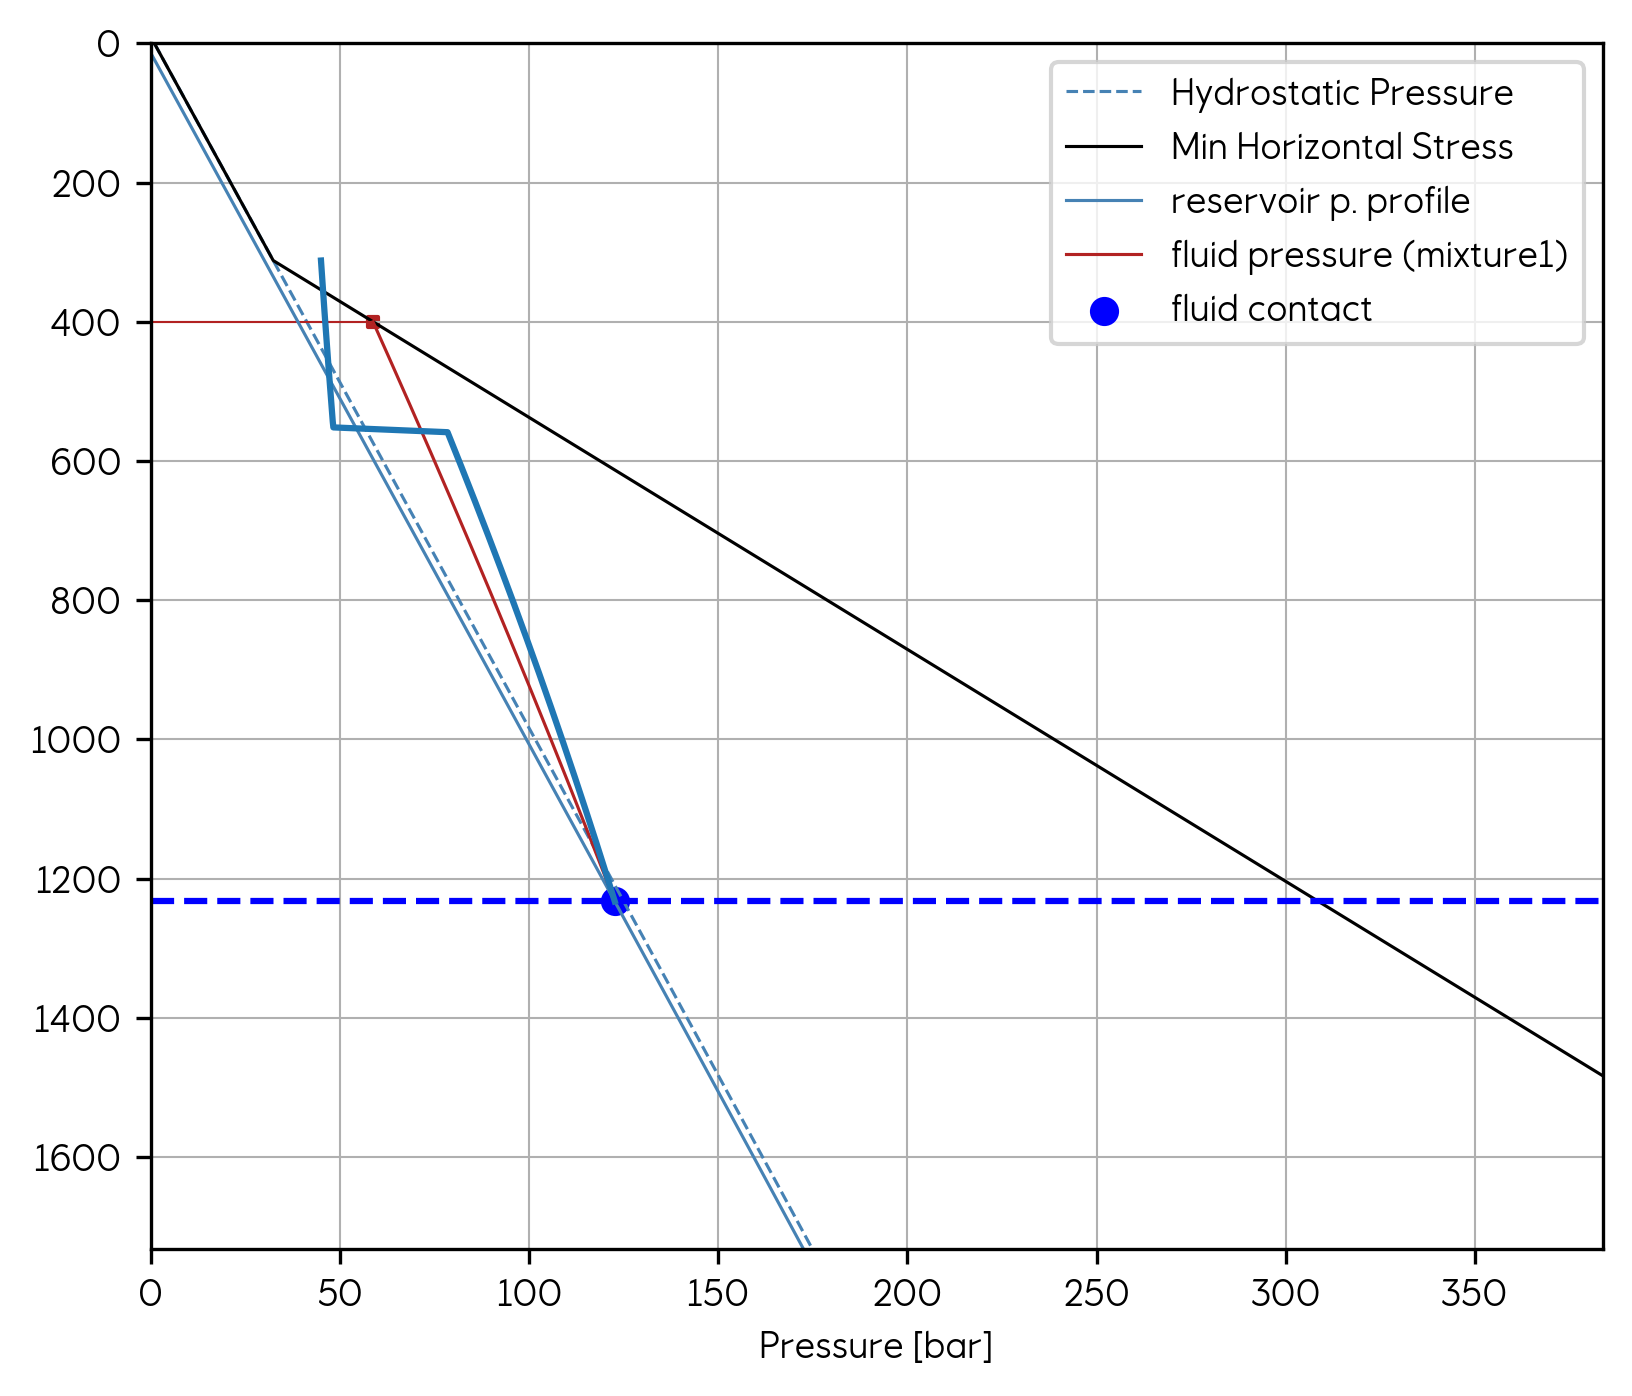

In [30]:
rcParams["figure.dpi"] = 300

width_cm = 14  # cm
height_cm = 12  # cm

width = width_cm / 2.54
height = height_cm / 2.54

fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(olga_dict.keys())[0]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

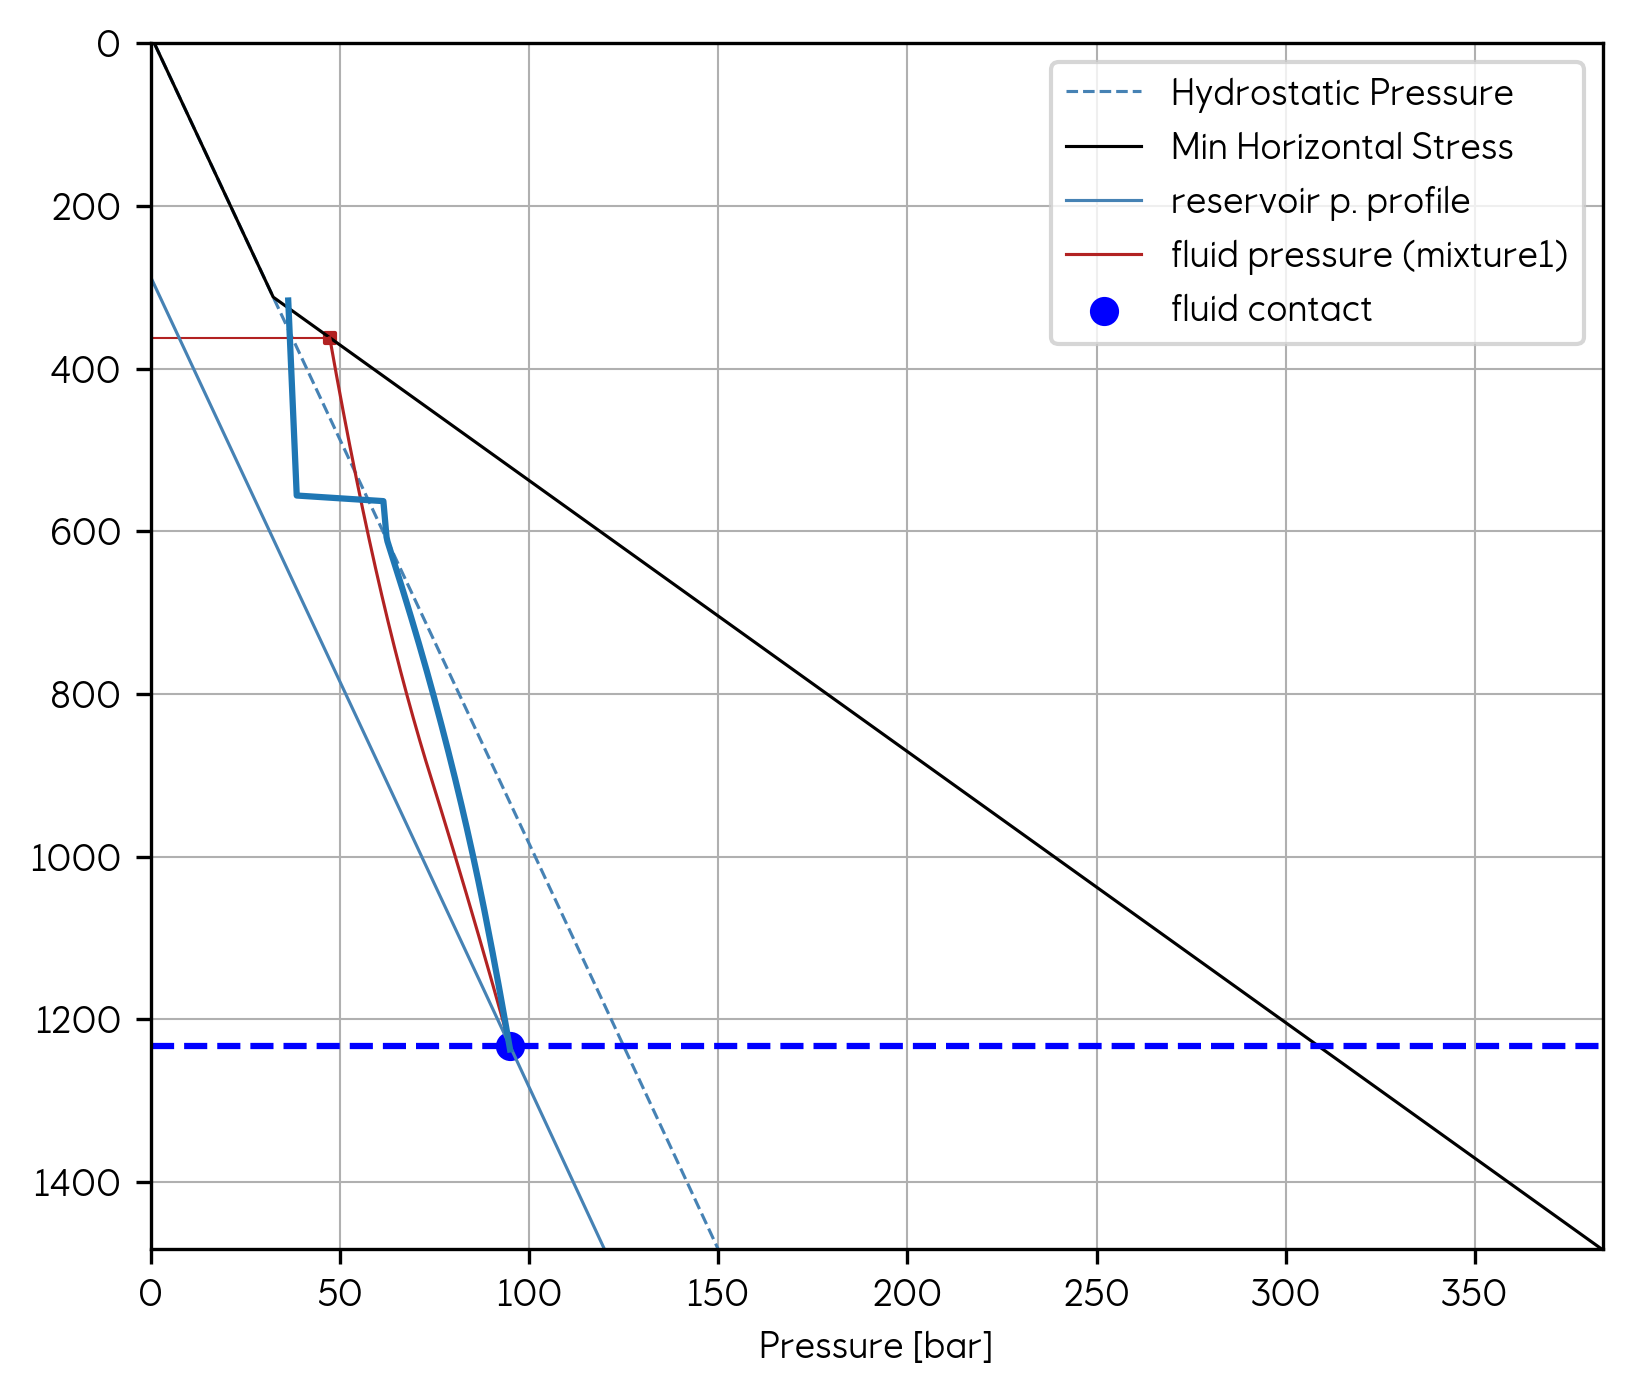

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[1]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 250)
fig.tight_layout()

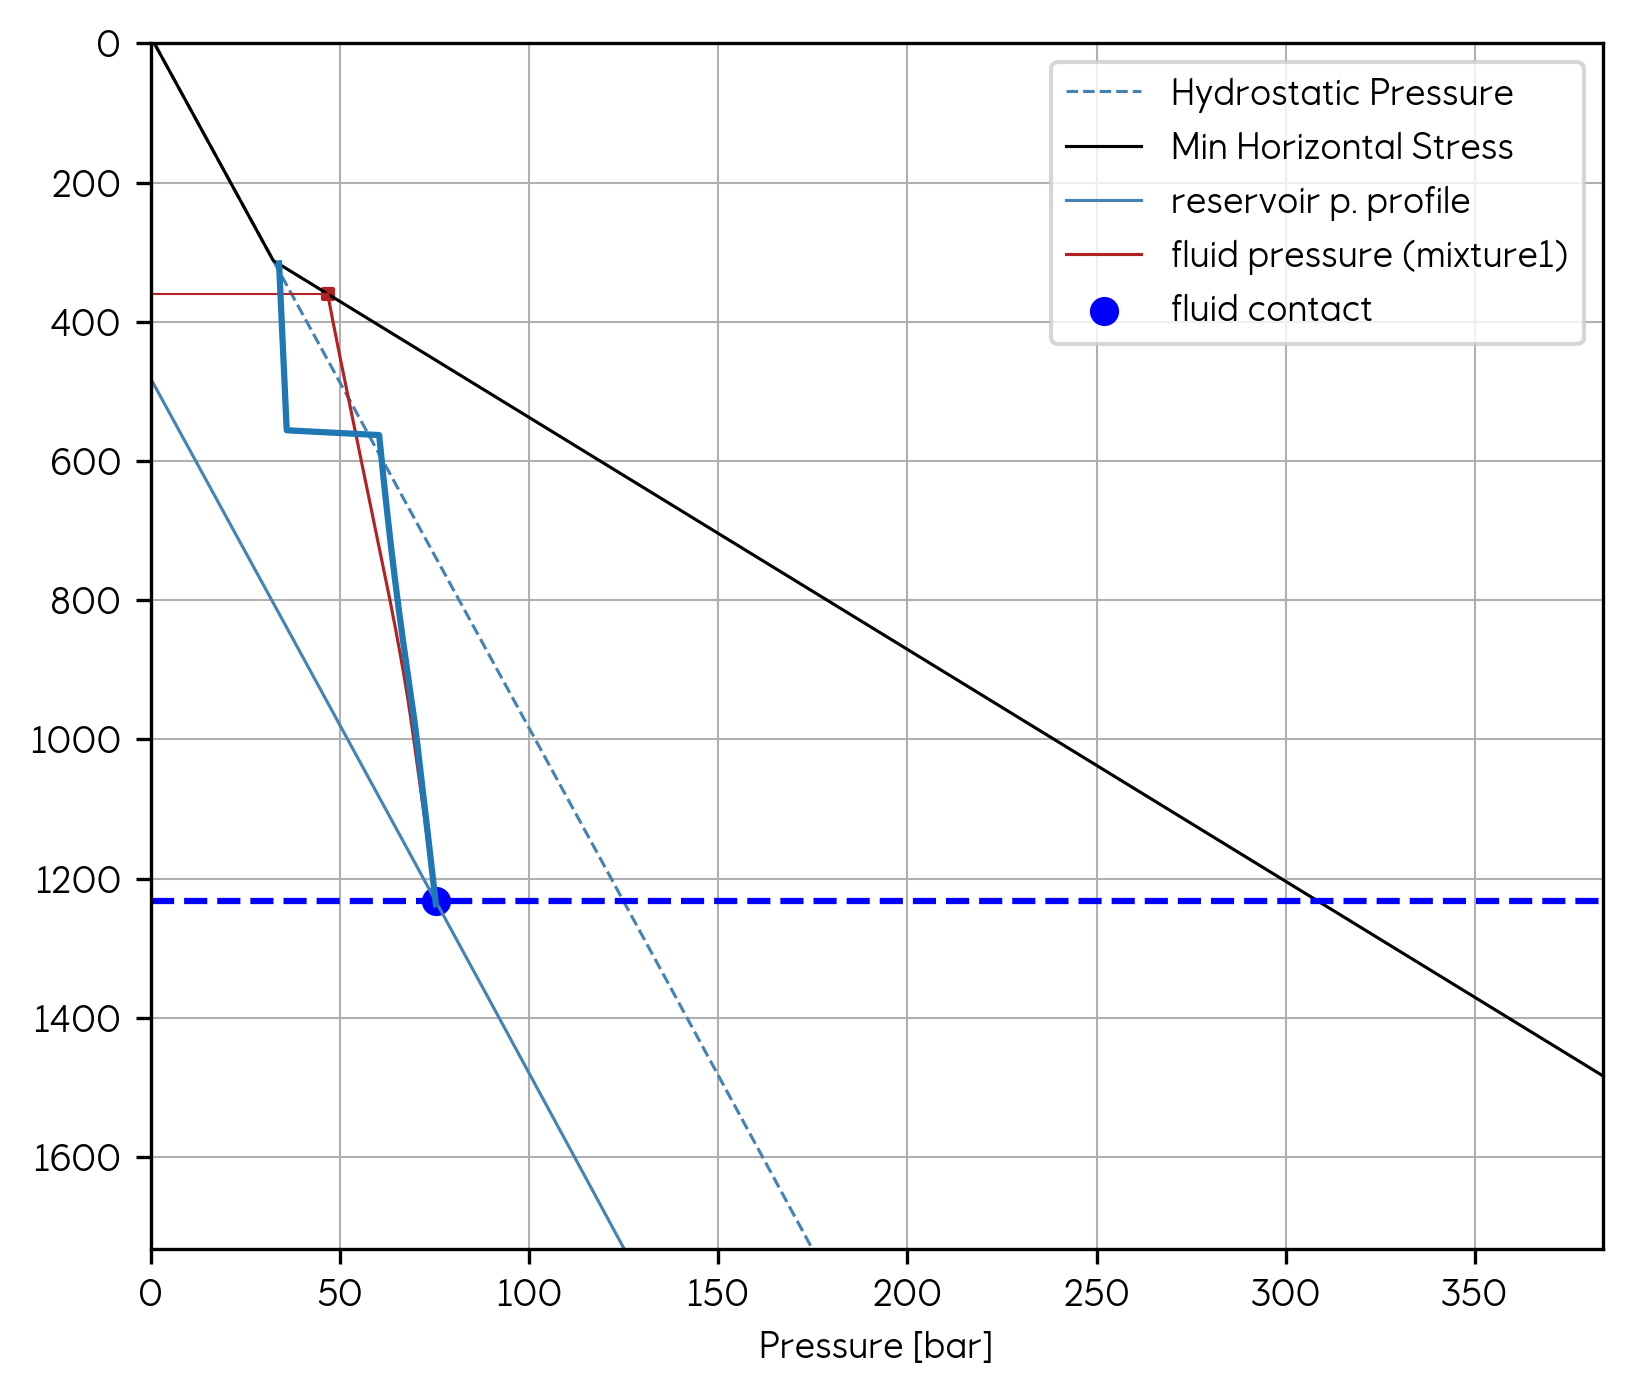

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[2]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

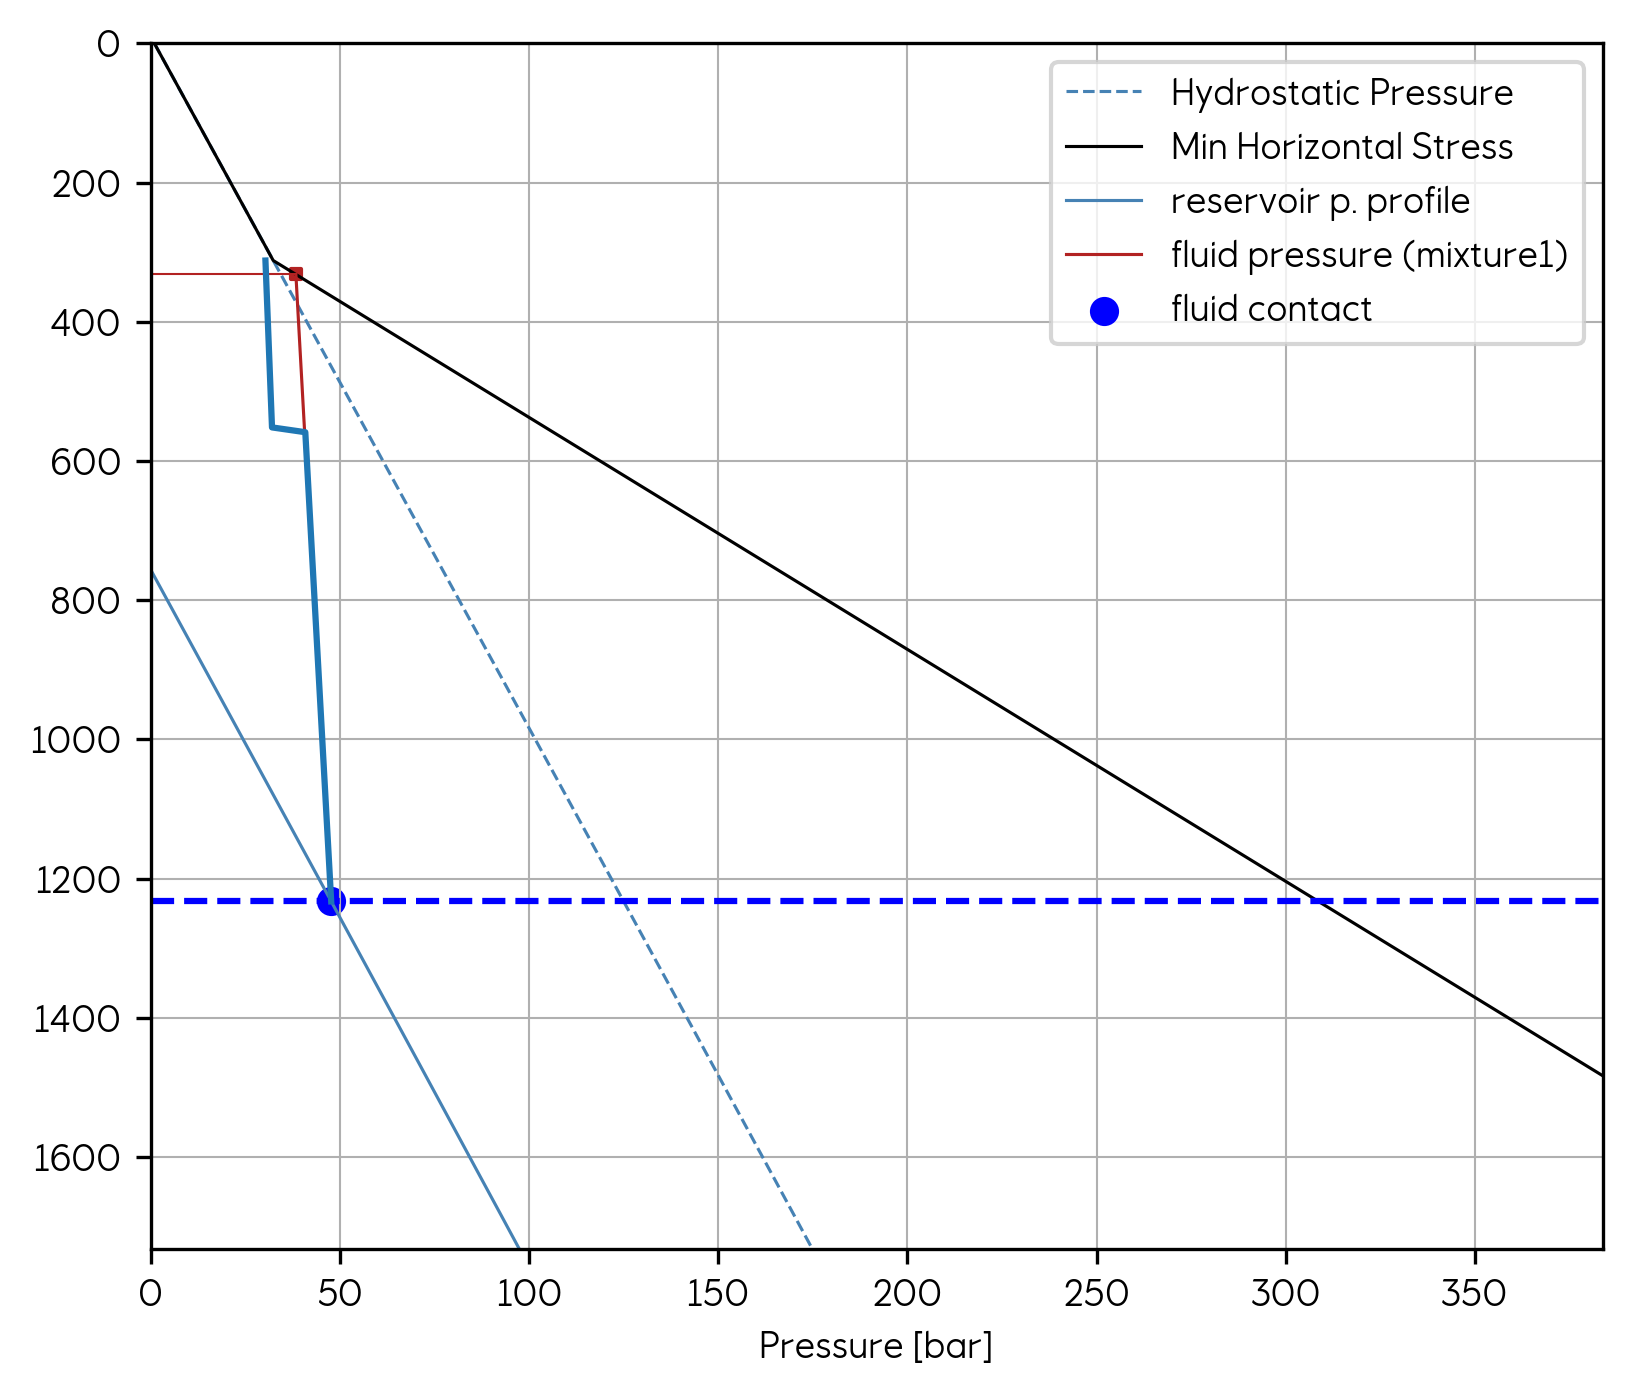

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[3]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

In [46]:
mix1_mixture_info

{'name': 'mixture1',
 'composition': '96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4'}

In [ ]:
mix1_table = olga_mix1_122

P_vals = mix1_table.iloc[:, 3].values * 1e5
T_vals = mix1_table.iloc[:, 5].values + 273.15
rho_vals = []
for P, T in zip(P_vals, T_vals):
    state.update(CP.PT_INPUTS, P, T)
    rho = state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

mix1_table['HEOS_RHO'] = rho_vals

In [47]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)

In [49]:
P_vals = mix1_table.iloc[:, 3].values
T_vals = mix1_table.iloc[:, 5].values

interpolator((P_vals, T_vals))

array([349.72780114, 341.15433728, 332.49135189, 323.79474085,
       314.83662999, 305.83750974, 296.4451213 , 287.0371935 ,
       277.01198686, 267.11982453, 256.47097479, 246.38786367,
       235.73340373, 226.23272677, 216.33448997, 207.82815047,
       199.24399428, 191.95929113, 185.42667151, 179.98502446,
       173.68019623, 168.13028853, 166.09550281, 164.77499451,
       162.65075833, 159.22440081, 155.86967774, 154.43941671,
       155.89021415, 156.77418309, 830.08822354, 829.27804619,
       828.44984096, 827.6225735 , 826.80725276, 825.99273374,
       825.19909647, 824.34688563, 823.52870516, 822.71618327,
       821.89820274, 821.06893546, 820.22608122, 819.41193708,
       818.59505357, 817.78310426, 816.93369999, 816.09577703,
       815.27774627, 814.44134011, 813.63033258, 812.78546184,
       811.93116657, 811.11693556, 810.28464211, 809.45285801,
       808.60965197, 807.75638489, 806.92612308, 806.1131327 ,
       805.24803421, 804.4068352 , 803.55533481, 802.74

In [45]:
mix1_table

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                             0.000070                             
1                                             0.001209                             
2                                             0.000128                             
3                                             0.001992                             
4                                             0.000177                             
..                                                 ...                             
147                                           1.000000                             
148                                           1.000000                             
149                                           1.000000                             
150                                           1.000000                             
151                                           1.000000                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              45.046581   
1                12.400000                              45.148140   
2                20.666666                              45.250332   
3                28.933332                              45.353180   
4                37.200001                              45.456680   
..                     ...                                    ...   
147             900.625000                             121.299896   
148             906.625000                             121.644600   
149             912.625000                             121.988899   
150             918.625000                             122.332298   
151             924.812500                             122.685600   

     Pipeline length [m].2  TM [C] (CHANNEL  PACTH) "Fluid temperature"  \
0                 4.133333                                     4.007951   
1                12.400000                                     4.335018   
2                20.666666                                     4.664342   
3                28.933332                                     4.994618   
4                37.200001                                     5.329660   
..                     ...                                          ...   
147             900.625000                                    39.301880   
148             906.625000                                    39.438061   
149             912.625000                                    39.673229   
150             918.625000                                    39.908340   
151             924.812500                                    40.150391   

     Pipeline length [m].3  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                           124.890800                                                                                          
1                                           126.471100                                                                                          
2                                           126.505302                                                                               

/tmp/ipykernel_2543/1189628890.py:429: UserWarning: Adding colorbar to a different Figure <Figure size 1920x1440 with 3 Axes> than <Figure size 2303.15x1651.18 with 1 Axes> which fig.colorbar is called on.
  fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


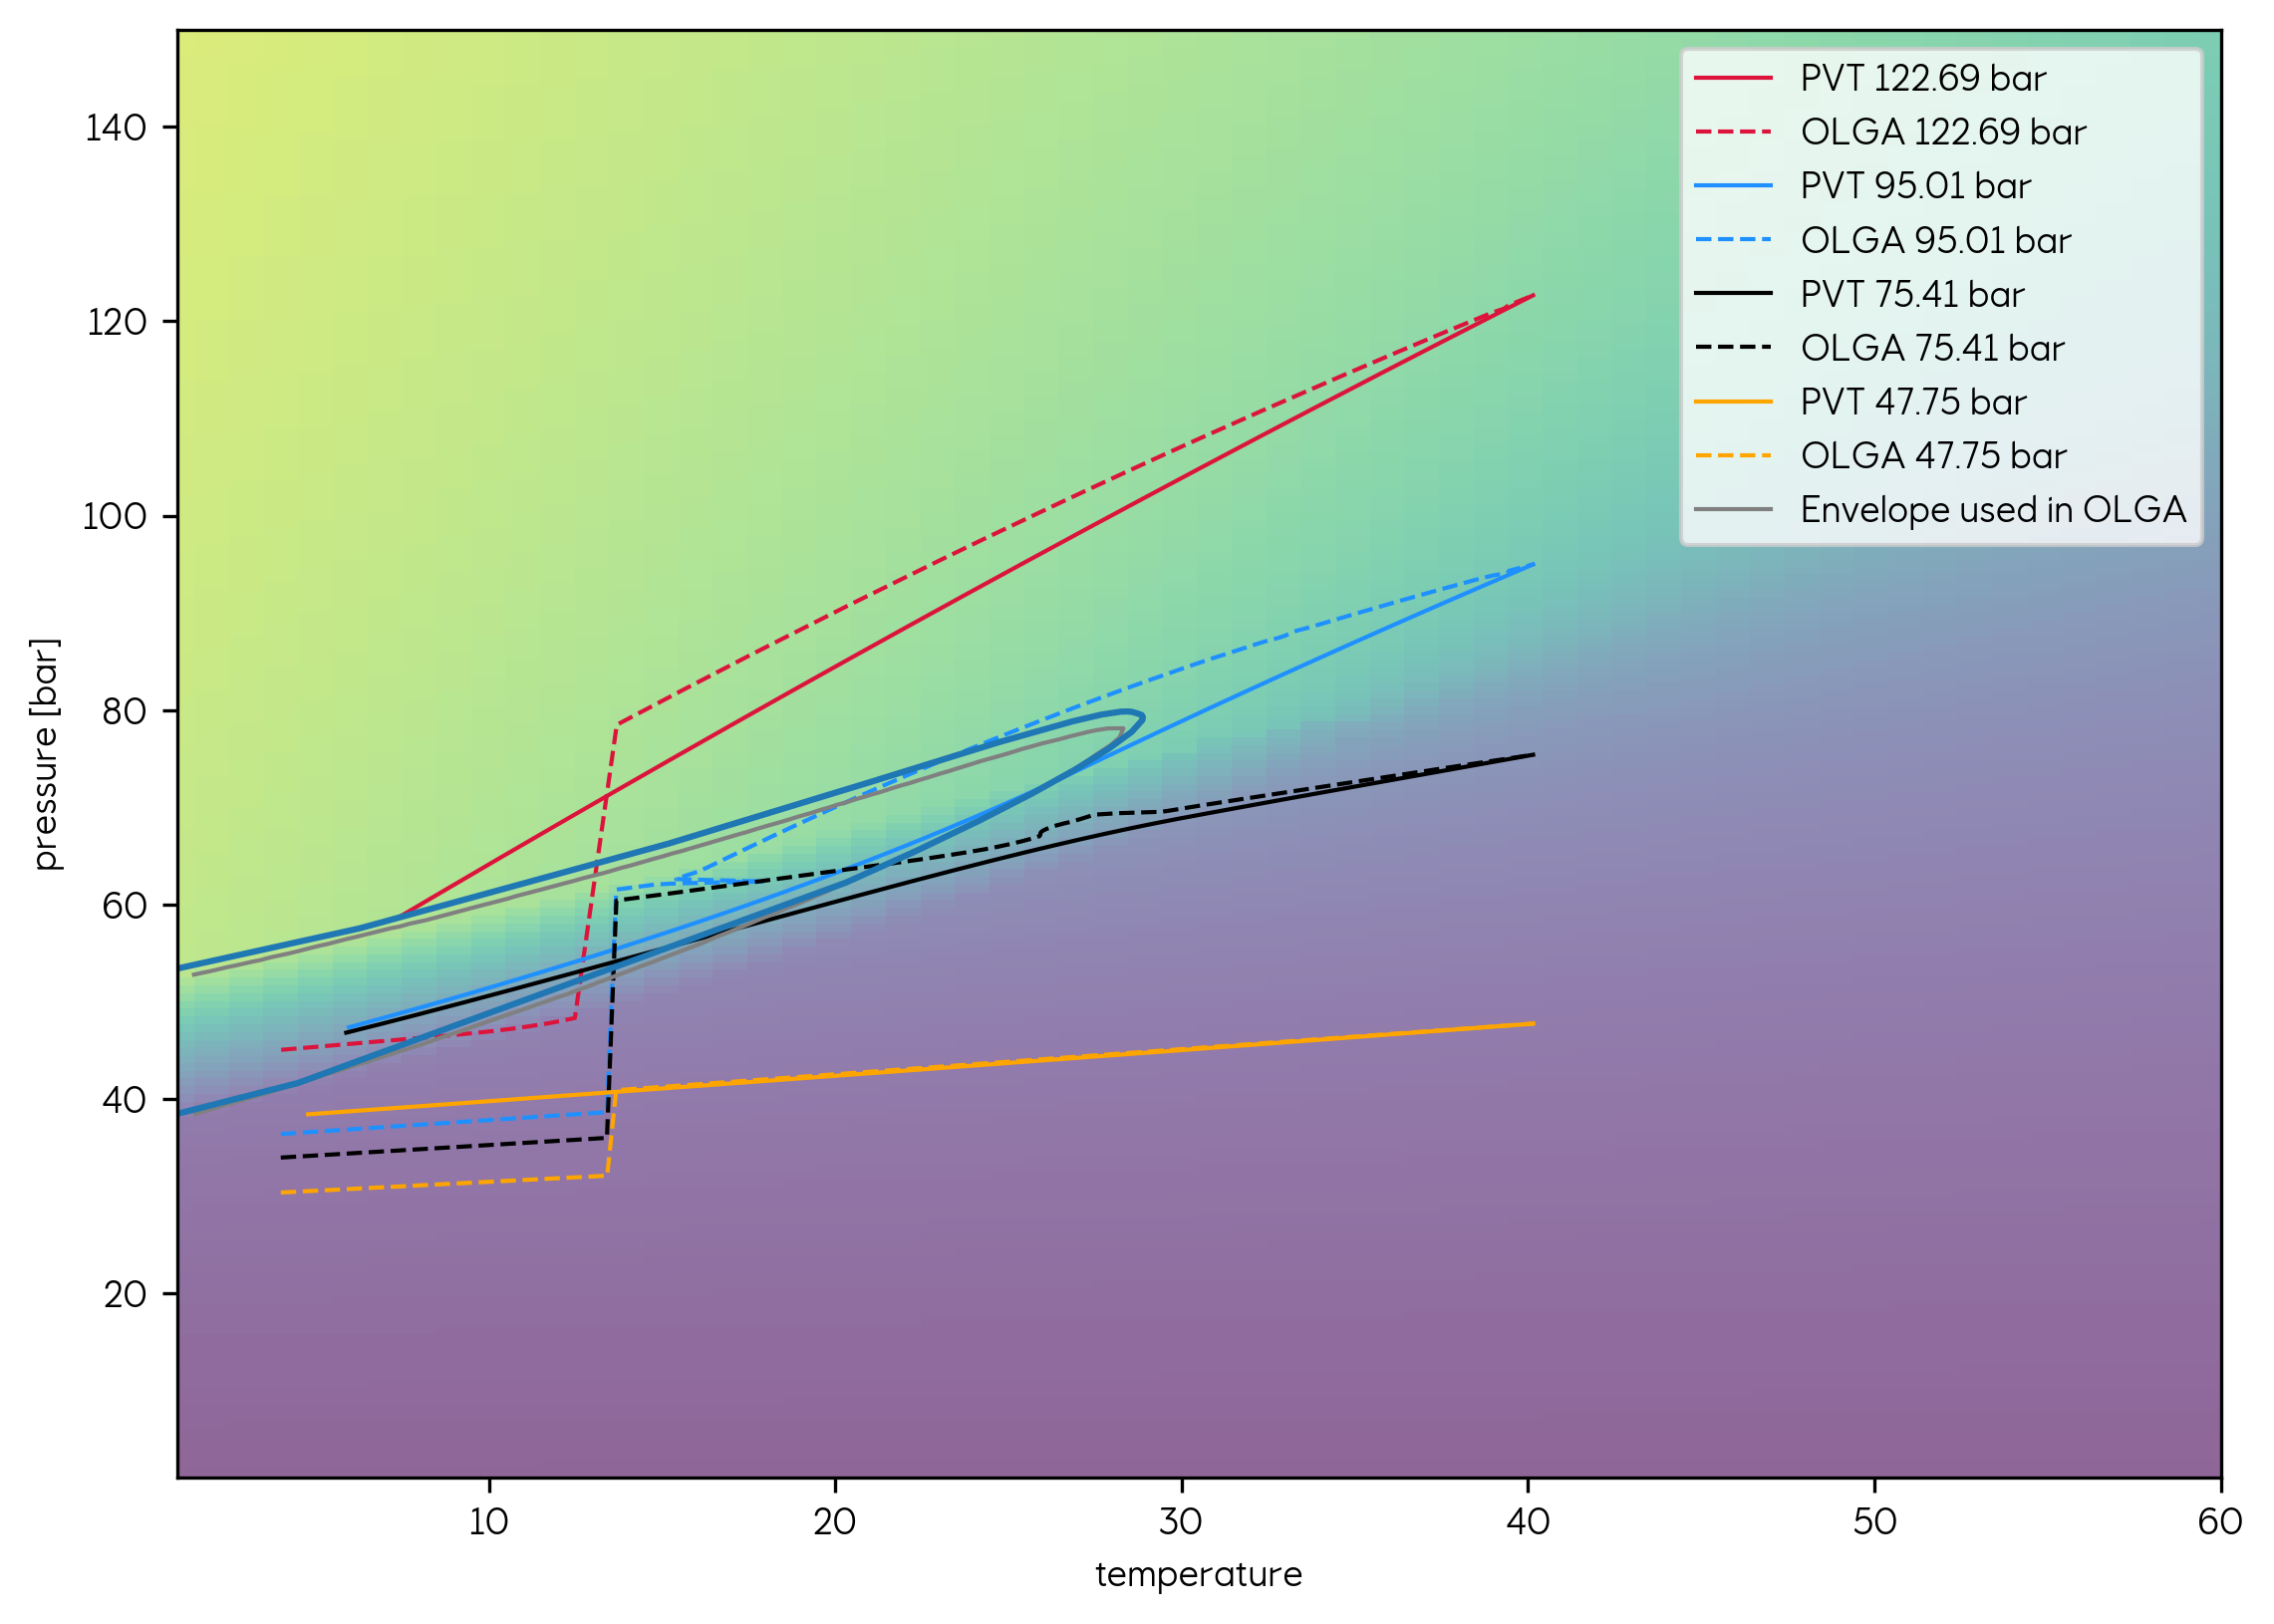

In [37]:
# Plot tables
from itertools import cycle
import numpy as np

height = 13.98 / (const.inch * 100)
width = 19.5 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_mix1 = ax.pcolormesh(mix1_pvt_data["temperature"], mix1_pvt_data["pressure"], mix1_pvt_data[mix1_path_name]["rho"], alpha=0.6)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")

color_cycle = cycle(["#DC143C", "#1E90FF", "k", "#FFA500"])


# ax.plot(olga_pure_co2_122.iloc[:,7], olga_pure_co2_122.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_94.iloc[:,7], olga_pure_co2_94.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_75.iloc[:,7], olga_pure_co2_75.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_47.iloc[:,7], olga_pure_co2_47.iloc[:,3], color=next(color_cycle))

for scenario, color in zip(p_models, color_cycle):
    p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
        "temperature", "fluid_pressure", ax=ax, color=color, label=f"PVT {scenario} bar", lw=1
    )

    ax.plot(olga_dict[scenario].iloc[:, 5], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)


# First column
envelope_T = [
    1.539,
    1.94,
    2.146,
    2.438,
    2.691,
    3.021,
    3.336,
    3.694,
    3.993,
    4.219,
    4.512,
    4.791,
    5.04,
    5.309,
    5.615,
    5.967,
    6.226,
    6.478,
    6.731,
    7.083,
    7.402,
    7.721,
    8.06,
    8.478,
    8.817,
    9.096,
    9.356,
    9.655,
    9.934,
    10.233,
    10.556,
    10.831,
    11.11,
    11.409,
    11.712,
    11.954,
    12.286,
    12.545,
    12.824,
    13.097,
    13.362,
    13.621,
    13.881,
    14.16,
    14.419,
    14.698,
    14.957,
    15.249,
    15.495,
    15.754,
    16.153,
    16.392,
    16.632,
    16.887,
    17.15,
    17.389,
    17.628,
    17.894,
    18.127,
    18.359,
    18.625,
    18.851,
    19.09,
    19.449,
    19.701,
    19.967,
    20.259,
    20.472,
    20.764,
    20.964,
    21.23,
    21.495,
    21.735,
    22.12,
    22.319,
    22.552,
    22.871,
    23.19,
    23.595,
    23.907,
    24.14,
    24.426,
    24.814,
    25.173,
    25.402,
    25.801,
    26.16,
    26.412,
    26.692,
    27.177,
    27.515,
    27.954,
    28.209,
    28.319,
    27.872,
    27.496,
    27.276,
    27.017,
    26.758,
    26.479,
    26.24,
    25.961,
    25.682,
    25.402,
    25.099,
    24.785,
    24.459,
    24.206,
    23.878,
    23.588,
    23.27,
    22.98,
    22.731,
    22.432,
    22.147,
    21.894,
    21.595,
    21.309,
    21.057,
    20.831,
    20.598,
    20.313,
    20.076,
    19.808,
    19.582,
    19.25,
    18.924,
    18.638,
    18.386,
    18.087,
    17.728,
    17.442,
    17.19,
    16.891,
    16.565,
    16.313,
    16.053,
    15.794,
    15.528,
    15.296,
    15.007,
    14.758,
    14.419,
    14.093,
    13.841,
    13.442,
    13.283,
    13.004,
    12.74,
    12.445,
    12.166,
    11.827,
    11.568,
    11.302,
    11.07,
    10.771,
    10.545,
    10.312,
    10.053,
    9.754,
    9.455,
    9.136,
    8.797,
    8.459,
    8.199,
    7.94,
    7.701,
    7.422,
    7.183,
    6.904,
    6.625,
    6.385,
    6.146,
    5.867,
    5.588,
    5.349,
    5.11,
    4.831,
    4.512,
    4.233,
    3.993,
    3.694,
    3.435,
    3.196,
    2.937,
    2.678,
    2.438,
    2.139,
    1.96,
    1.491,
]

# Second column
envelope_P = [
    38.436,
    38.913,
    39.103,
    39.428,
    39.676,
    40.012,
    40.344,
    40.702,
    41.031,
    41.279,
    41.604,
    41.919,
    42.205,
    42.52,
    42.845,
    43.236,
    43.551,
    43.799,
    44.105,
    44.496,
    44.869,
    45.212,
    45.594,
    46.129,
    46.53,
    46.855,
    47.175,
    47.561,
    47.905,
    48.278,
    48.673,
    48.994,
    49.352,
    49.724,
    50.094,
    50.407,
    50.799,
    51.171,
    51.515,
    51.897,
    52.246,
    52.604,
    52.948,
    53.321,
    53.693,
    54.037,
    54.395,
    54.802,
    55.126,
    55.485,
    56.015,
    56.388,
    56.746,
    57.098,
    57.477,
    57.821,
    58.179,
    58.585,
    58.91,
    59.235,
    59.656,
    59.961,
    60.305,
    60.879,
    61.261,
    61.682,
    62.164,
    62.485,
    62.943,
    63.288,
    63.708,
    64.129,
    64.501,
    65.123,
    65.429,
    65.849,
    66.394,
    66.939,
    67.647,
    68.201,
    68.603,
    69.09,
    69.779,
    70.467,
    70.936,
    71.701,
    72.39,
    72.887,
    73.423,
    74.513,
    75.374,
    76.408,
    77.191,
    78.131,
    78.115,
    77.906,
    77.734,
    77.505,
    77.277,
    77.005,
    76.8,
    76.561,
    76.275,
    76.003,
    75.662,
    75.33,
    75.006,
    74.758,
    74.386,
    74.071,
    73.713,
    73.412,
    73.126,
    72.811,
    72.486,
    72.238,
    71.909,
    71.57,
    71.322,
    71.074,
    70.835,
    70.501,
    70.28,
    69.966,
    69.737,
    69.355,
    69.031,
    68.707,
    68.444,
    68.144,
    67.771,
    67.447,
    67.199,
    66.884,
    66.531,
    66.283,
    65.996,
    65.739,
    65.462,
    65.252,
    64.937,
    64.699,
    64.35,
    64.012,
    63.783,
    63.363,
    63.21,
    62.962,
    62.722,
    62.418,
    62.161,
    61.832,
    61.589,
    61.341,
    61.116,
    60.845,
    60.597,
    60.387,
    60.144,
    59.872,
    59.586,
    59.271,
    58.956,
    58.641,
    58.398,
    58.193,
    58.012,
    57.726,
    57.564,
    57.316,
    57.068,
    56.854,
    56.649,
    56.42,
    56.153,
    55.938,
    55.753,
    55.505,
    55.209,
    54.971,
    54.78,
    54.551,
    54.303,
    54.132,
    53.922,
    53.713,
    53.541,
    53.293,
    53.141,
    52.784,
]

ax.plot(envelope_T, envelope_P, color="grey", label="Envelope used in OLGA", lw=1)

ax.plot(np.array(PE.T) - 273.15, np.array(PE.p) / 1e5, "-")


ax.set_xlim(1, 60)

ax.set_ylim(1, 150)
ax.legend()

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()

In [ ]:
PE.p

[100.80379887920823,
 105.23553318088041,
 109.89977612958852,
 116.5938165136514,
 121.82743114728038,
 135.64179194244116,
 164.2650666892317,
 233.97681334955286,
 434.47664847608286,
 807.9048554270216,
 1504.5424043792414,
 2806.3188704365025,
 5243.122322789677,
 9812.359001944336,
 18393.188492749516,
 34525.41139703835,
 64863.10249003617,
 121845.59709073718,
 228465.99366368097,
 426323.22765067726,
 787738.9236674437,
 1429208.3473887066,
 2510091.8636376644,
 4162610.358810369,
 6228971.032754598,
 6553708.099991646,
 6860068.228065761,
 7141051.646664768,
 7390038.229843589,
 7602266.32077926,
 7774796.727996472,
 7897718.587854961,
 7925940.704255763,
 7934713.5020513125,
 7949242.258162174,
 7965558.717267497,
 7980940.216740813,
 7984147.935387788,
 7985919.676557342,
 7984110.926163372,
 7953642.919041591,
 7883341.770454213,
 7665301.343240684,
 7263332.186578328,
 6627004.776198212,
 5754720.366189559,
 4730251.1656927625,
 3798316.2703169053,
 3517186.3460436603,
 3

In [ ]:
scenario = list(p_models.keys())[2]
df = p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves

df[~df["fluid_pressure"].isna()]

depth  temperature  hydrostatic_pressure  \
360.000000    360.000000     5.884794             37.261071   
361.000000    361.000000     5.924060             37.361816   
362.000000    362.000000     5.963327             37.462562   
363.000000    363.000000     6.002593             37.563307   
364.000000    364.000000     6.041860             37.664052   
...                  ...          ...                   ...   
1229.000000  1229.000000    40.007410            124.664341   
1230.000000  1230.000000    40.046677            124.764558   
1231.000000  1231.000000    40.085943            124.864773   
1232.000000  1232.000000    40.125210            124.964988   
1232.679167  1232.679167    40.144843            125.015094   

             min_horizontal_stress  fluid_pressure  brine_pressure  
360.000000               46.825442       46.811409      -12.180651  
361.000000               47.125442       46.846054      -12.080063  
362.000000               47.425442       46.880735      -11.979475  
363.000000               47.725442       46.915452      -11.878888  
364.000000               48.025442       46.950205      -11.778300  
...                            ...             ...             ...  
1229.000000             307.525442       75.316653       75.040225  
1230.000000             307.825442       75.341524       75.140229  
1231.000000             308.125442       75.366394       75.240231  
1232.000000             308.425442       75.391261       75.340233  
1232.679167             308.575442       75.403694       75.390233  

[874 rows x 6 columns]

In [ ]:
olga_dict[scenario]

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                                  0.0                             
1                                                  0.0                             
2                                                  0.0                             
3                                                  0.0                             
4                                                  0.0                             
..                                                 ...                             
147                                                0.0                             
148                                                0.0                             
149                                                0.0                             
150                                                0.0                             
151                                                0.0                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              30.364889   
1                12.400000                              30.424570   
2                20.666666                              30.484261   
3                28.933332                              30.543961   
4                37.200001                              30.603661   
..                     ...                                    ...   
147             900.625000                              47.500000   
148             906.625000                              47.560909   
149             912.625000                              47.621819   
150             918.625000                              47.682732   
151             924.812500                              47.745541   

     Pipeline length [m].2  TM [C] (CHANNEL  PACTH) "Fluid temperature"  \
0                 4.133333                                     3.996246   
1                12.400000                                     4.319206   
2                20.666666                                     4.643922   
3                28.933332                                     4.977626   
4                37.200001                                     5.292980   
..                     ...                                          ...   
147             900.625000                                    39.197189   
148             906.625000                                    39.437618   
149             912.625000                                    39.672321   
150             918.625000                                    39.902111   
151             924.812500                                    40.155231   

     Pipeline length [m].3  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  
0                                            73.585258                                                                                         
1                                            73.596771                                                                                         
2                                            73.608841                                                                                  

In [ ]:
mix1_path_name

'mixture1'

In [ ]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np


x = mix1_pvt_data["pressure"]
y = mix1_pvt_data["temperature"]
z = mix1_pvt_data[mix1_path_name]["rho"]

X, Y = np.meshgrid(x, y)

points = np.column_stack((X.ravel(), Y.ravel()))
values = z.ravel()

interpolator = RegularGridInterpolator((x, y), z)

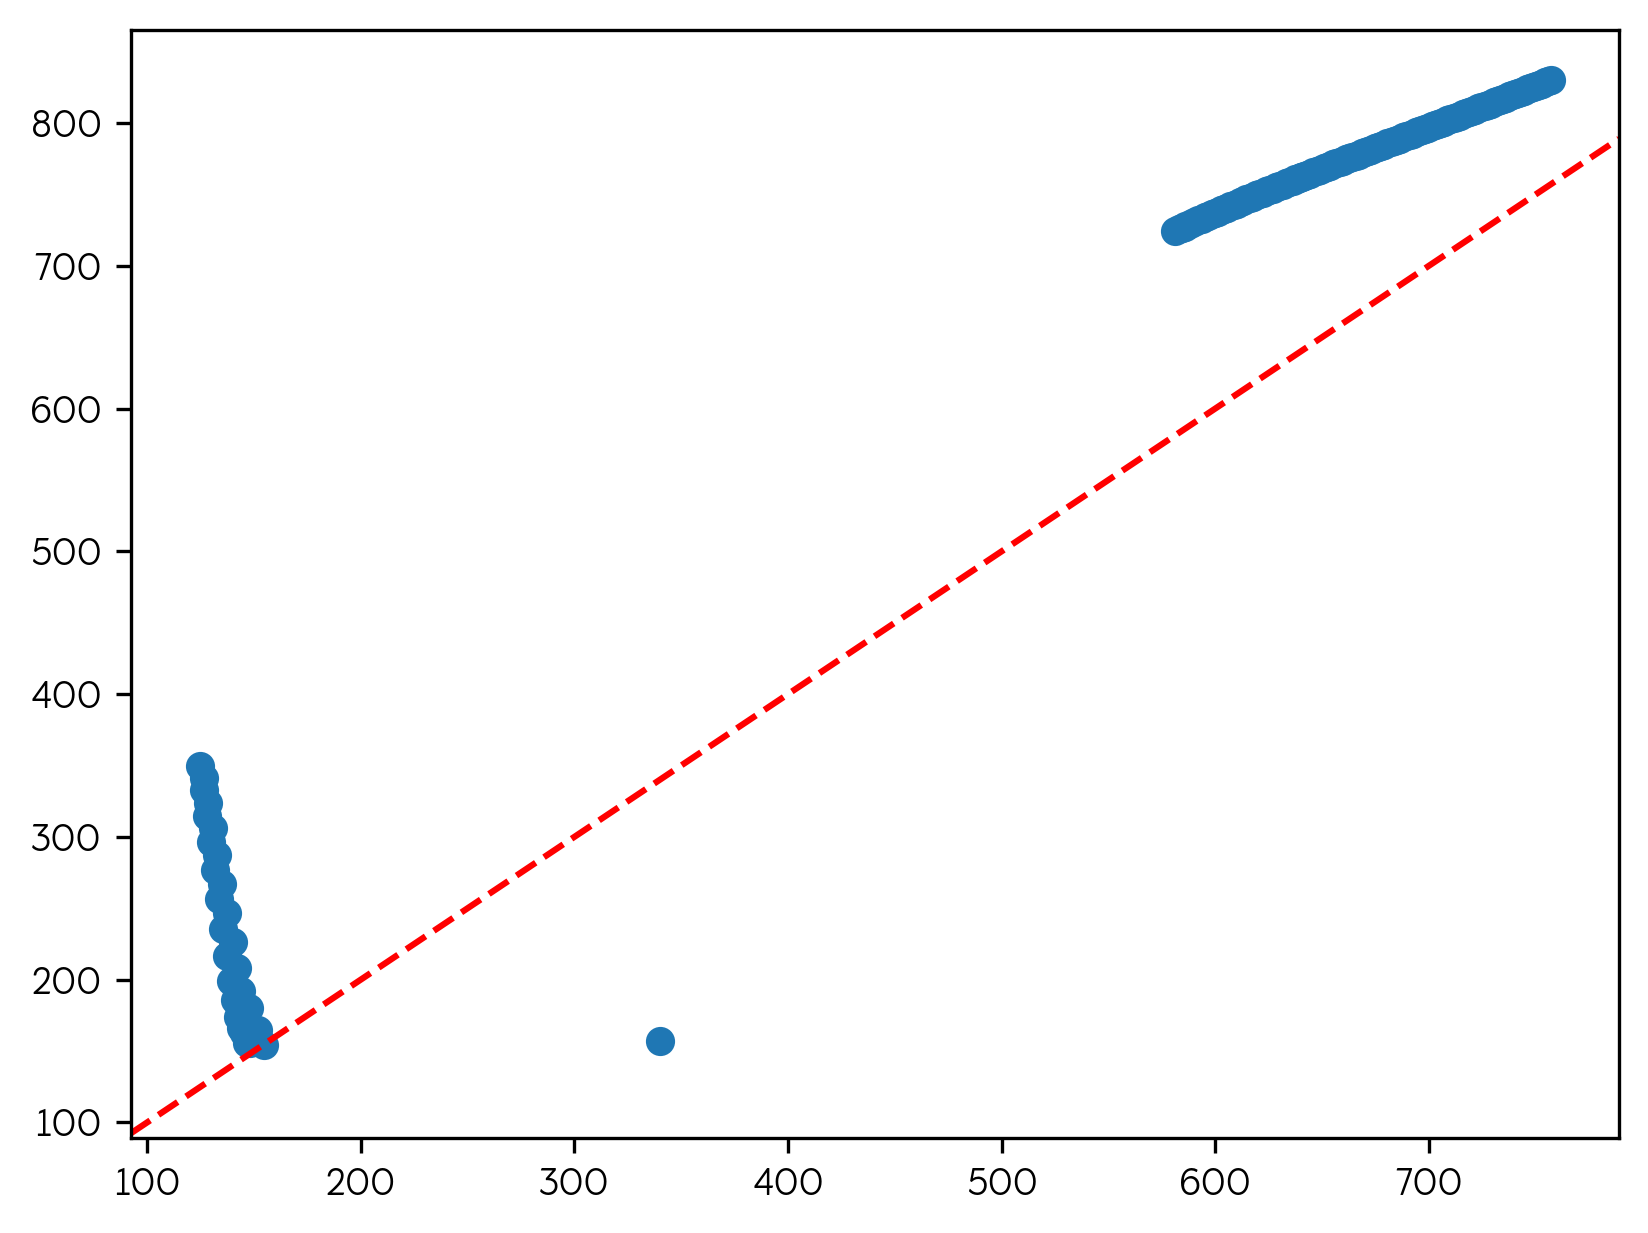

In [ ]:
scenario = list(p_models.keys())[0]

olga_T = olga_dict[scenario].iloc[:, 5].values
olga_P = olga_dict[scenario].iloc[:, 3].values
olga_rho_interp = interpolator((olga_P, olga_T))

olga_dict[scenario]["interpolated_rho"] = olga_rho_interp

olga_rho = olga_dict[scenario].iloc[:, 7].values

# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, olga_rho_interp)

lowest_value = int(min(min(olga_rho), min(olga_rho_interp)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

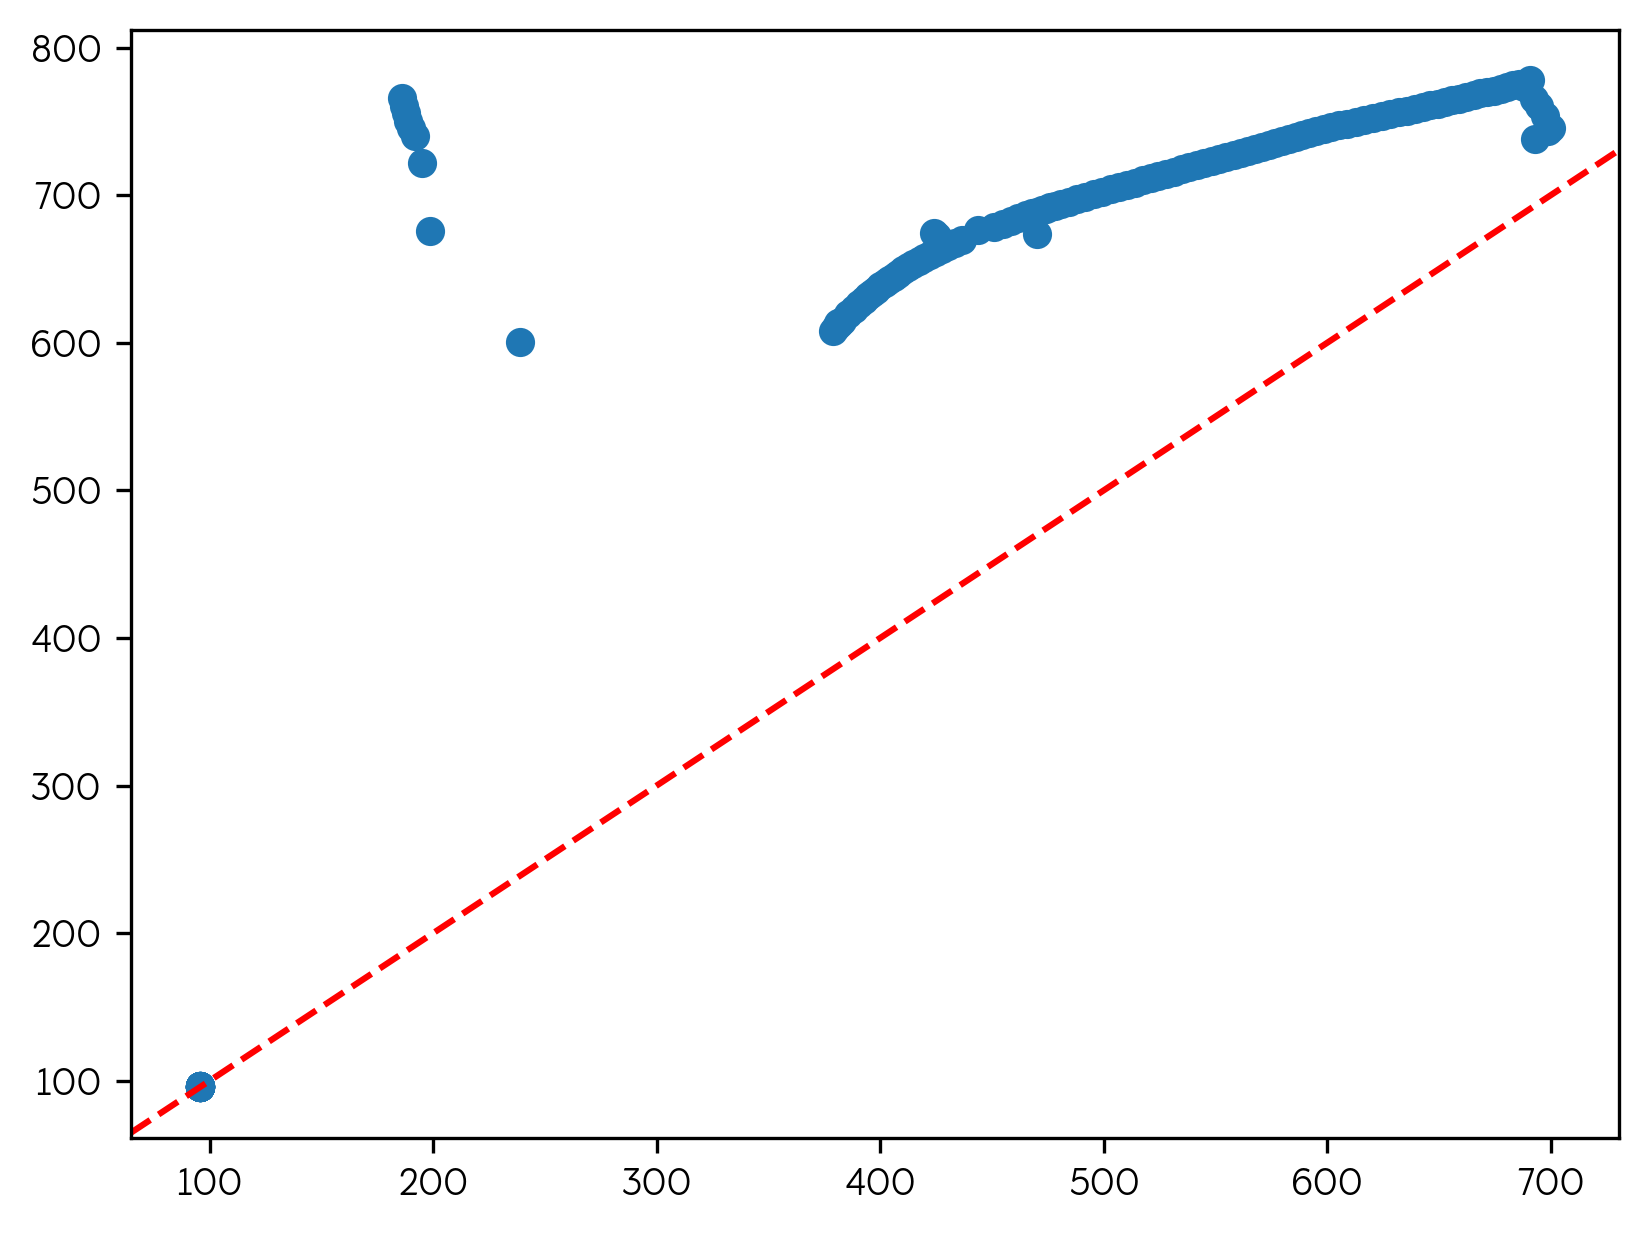

In [ ]:
scenario = list(p_models.keys())[1]

olga_T = olga_dict[scenario].iloc[:, 5].values
olga_P = olga_dict[scenario].iloc[:, 3].values
olga_rho_interp = interpolator((olga_P, olga_T))

olga_dict[scenario]["interpolated_rho"] = olga_rho_interp

olga_rho = olga_dict[scenario].iloc[:, 7].values

# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, olga_rho_interp)

lowest_value = int(min(min(olga_rho), min(olga_rho_interp)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

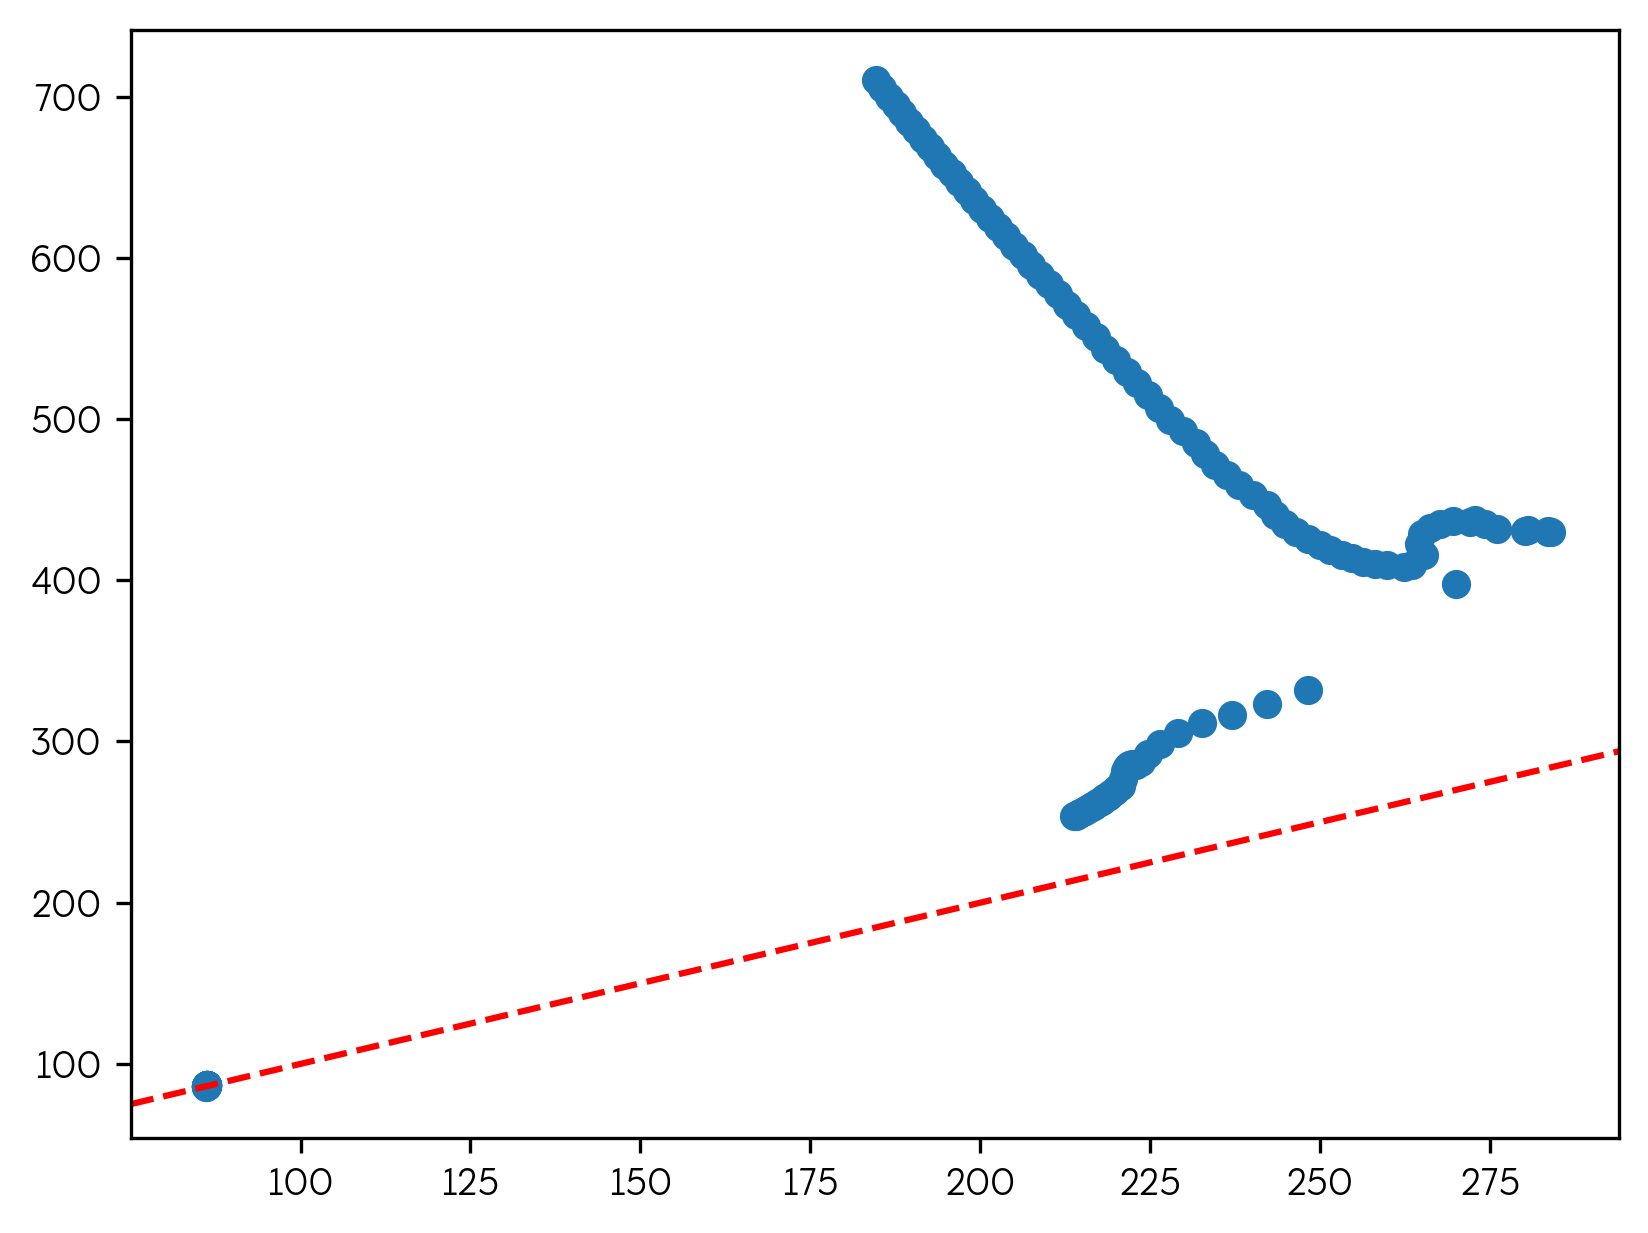

In [ ]:
scenario = list(p_models.keys())[2]

olga_T = olga_dict[scenario].iloc[:, 5].values
olga_P = olga_dict[scenario].iloc[:, 3].values
olga_rho_interp = interpolator((olga_P, olga_T))

olga_dict[scenario]["interpolated_rho"] = olga_rho_interp

olga_rho = olga_dict[scenario].iloc[:, 7].values

# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, olga_rho_interp)

lowest_value = int(min(min(olga_rho), min(olga_rho_interp)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

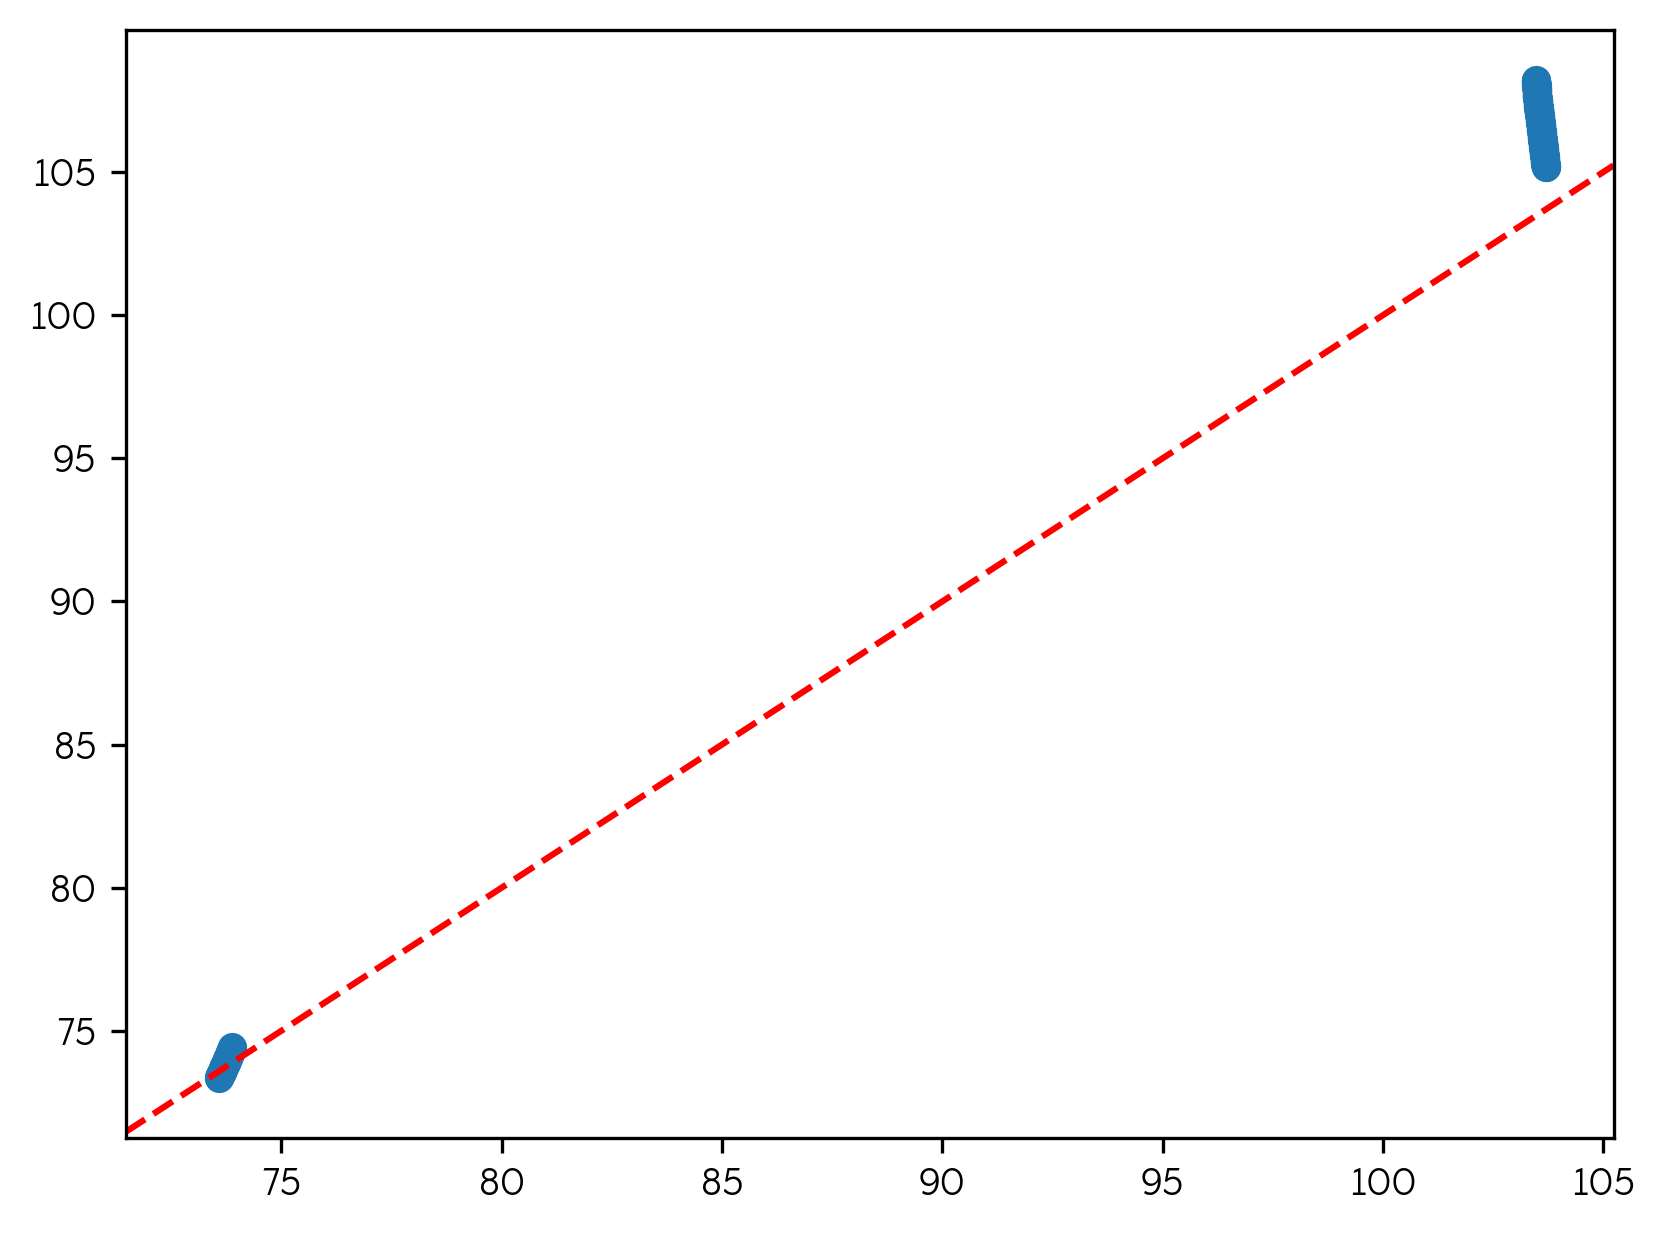

In [ ]:
scenario = list(p_models.keys())[3]

olga_T = olga_dict[scenario].iloc[:, 5].values
olga_P = olga_dict[scenario].iloc[:, 3].values
olga_rho_interp = interpolator((olga_P, olga_T))

olga_dict[scenario]["interpolated_rho"] = olga_rho_interp

olga_rho = olga_dict[scenario].iloc[:, 7].values

# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, olga_rho_interp)

lowest_value = int(min(min(olga_rho), min(olga_rho_interp)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

In [ ]:
olga_dict[scenario]

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                                  0.0                             
1                                                  0.0                             
2                                                  0.0                             
3                                                  0.0                             
4                                                  0.0                             
..                                                 ...                             
147                                                0.0                             
148                                                0.0                             
149                                                0.0                             
150                                                0.0                             
151                                                0.0                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              30.364889   
1                12.400000                              30.424570   
2                20.666666                              30.484261   
3                28.933332                              30.543961   
4                37.200001                              30.603661   
..                     ...                                    ...   
147             900.625000                              47.500000   
148             906.625000                              47.560909   
149             912.625000                              47.621819   
150             918.625000                              47.682732   
151             924.812500                              47.745541   

     Pipeline length [m].2  TM [C] (CHANNEL  PACTH) "Fluid temperature"  \
0                 4.133333                                     3.996246   
1                12.400000                                     4.319206   
2                20.666666                                     4.643922   
3                28.933332                                     4.977626   
4                37.200001                                     5.292980   
..                     ...                                          ...   
147             900.625000                                    39.197189   
148             906.625000                                    39.437618   
149             912.625000                                    39.672321   
150             918.625000                                    39.902111   
151             924.812500                                    40.155231   

     Pipeline length [m].3  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                            73.585258                                                                                          
1                                            73.596771                                                                                          
2                                            73.608841                                                                               

In [ ]:
! uv add CoolProp

Resolved 183 packages in 666ms                                       
   Building winc-onepager @ file:///workspaces/WINC_OnePager           ⠋ Preparing packages... (0/0)                                                   
   Building winc-onepager @ file:///workspaces/WINC_OnePager   
⠙ Preparing packages... (0/2)
   Building winc-onepager @ file:///workspaces/WINC_OnePager           
⠙ Preparing packages... (0/2)
   Building winc-onepager @ file:///workspaces/WINC_OnePagerB          
⠙ Preparing packages... (0/2)
   Building winc-onepager @ file:///workspaces/WINC_OnePageriB         
⠙ Preparing packages... (0/2)
   Building winc-onepager @ file:///workspaces/WINC_OnePageriB         
⠙ Preparing packages... (0/2)
   Building winc-onepager @ file:///workspaces/WINC_OnePageriB         
⠙ Preparing packages... (0/2)
   Building winc-onepager @ file:///workspaces/WINC_OnePageriB         
⠙ Preparing packages... (0/2)
   Building winc-onepager @ file:///workspaces/WINC_OnePageriB         


In [ ]:
import CoolProp


CoolProp.AbstractState.

CoolProp.CoolProp.AbstractState

TypeError: 'CoolProp.CoolProp.AbstractState' object is not callable

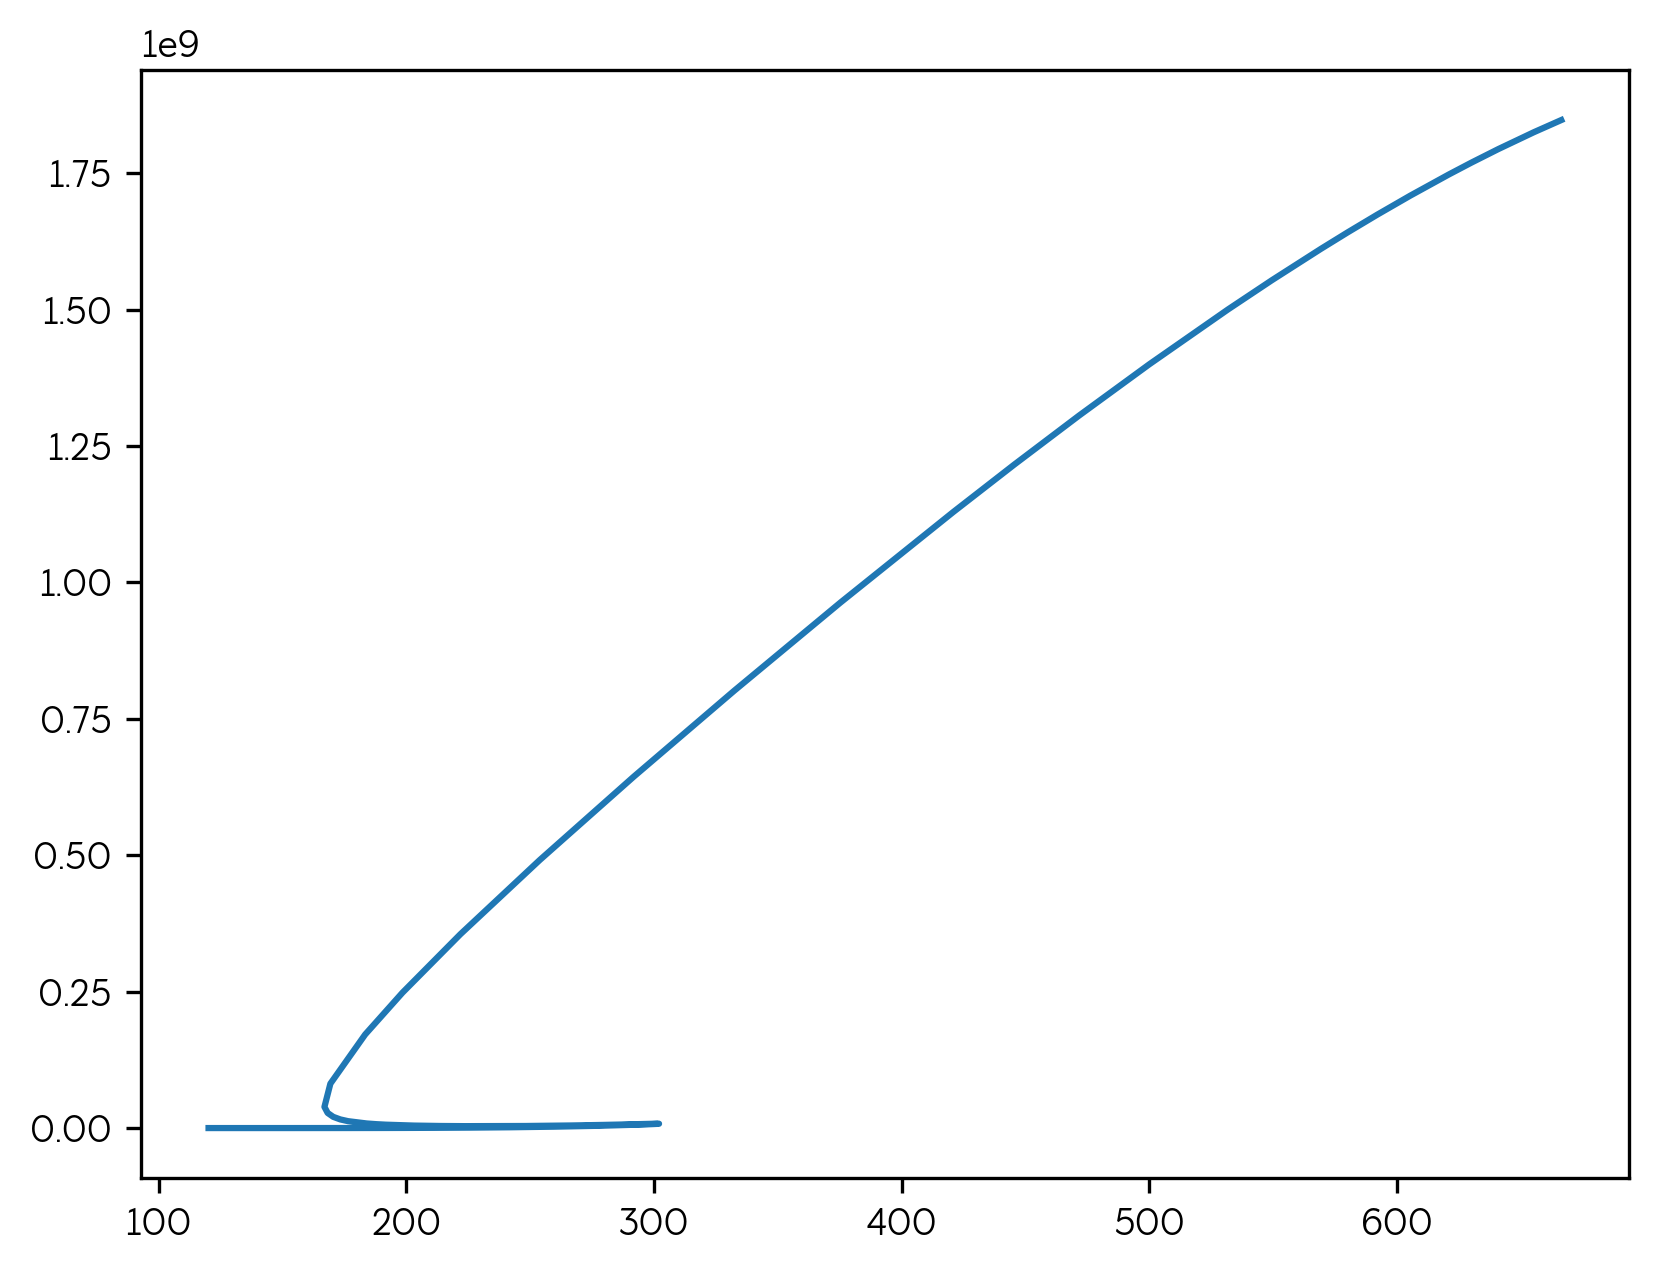

In [ ]:
def get_rho(state P, T):
    state.update(CP.PT_INPUTS, 47.745541e5, 40.155231+273.15)
    state
    state.keyed_output(CP.iDmass)

101.80020121123202

In [ ]:
scenario = list(p_models.keys())[0]
scenario

'122.69'

In [ ]:
P_vals = olga_dict[scenario].iloc[:, 3].values * 1e5
T_vals = olga_dict[scenario].iloc[:, 5].values + 273.15
rho_vals = []
for P, T in zip(P_vals, T_vals):
    state.update(CP.PT_INPUTS, P, T)
    rho = state.keyed_output(CP.iDmass)
    rho_vals.append(rho)

In [ ]:
olga_dict[scenario]["rho_coolprop"] = rho_vals

olga_dict[scenario]

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                             0.000070                             
1                                             0.001209                             
2                                             0.000128                             
3                                             0.001992                             
4                                             0.000177                             
..                                                 ...                             
147                                           1.000000                             
148                                           1.000000                             
149                                           1.000000                             
150                                           1.000000                             
151                                           1.000000                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              45.046581   
1                12.400000                              45.148140   
2                20.666666                              45.250332   
3                28.933332                              45.353180   
4                37.200001                              45.456680   
..                     ...                                    ...   
147             900.625000                             121.299896   
148             906.625000                             121.644600   
149             912.625000                             121.988899   
150             918.625000                             122.332298   
151             924.812500                             122.685600   

     Pipeline length [m].2  TM [C] (CHANNEL  PACTH) "Fluid temperature"  \
0                 4.133333                                     4.007951   
1                12.400000                                     4.335018   
2                20.666666                                     4.664342   
3                28.933332                                     4.994618   
4                37.200001                                     5.329660   
..                     ...                                          ...   
147             900.625000                                    39.301880   
148             906.625000                                    39.438061   
149             912.625000                                    39.673229   
150             918.625000                                    39.908340   
151             924.812500                                    40.150391   

     Pipeline length [m].3  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                           124.890800                                                                                          
1                                           126.471100                                                                                          
2                                           126.505302                                                                               

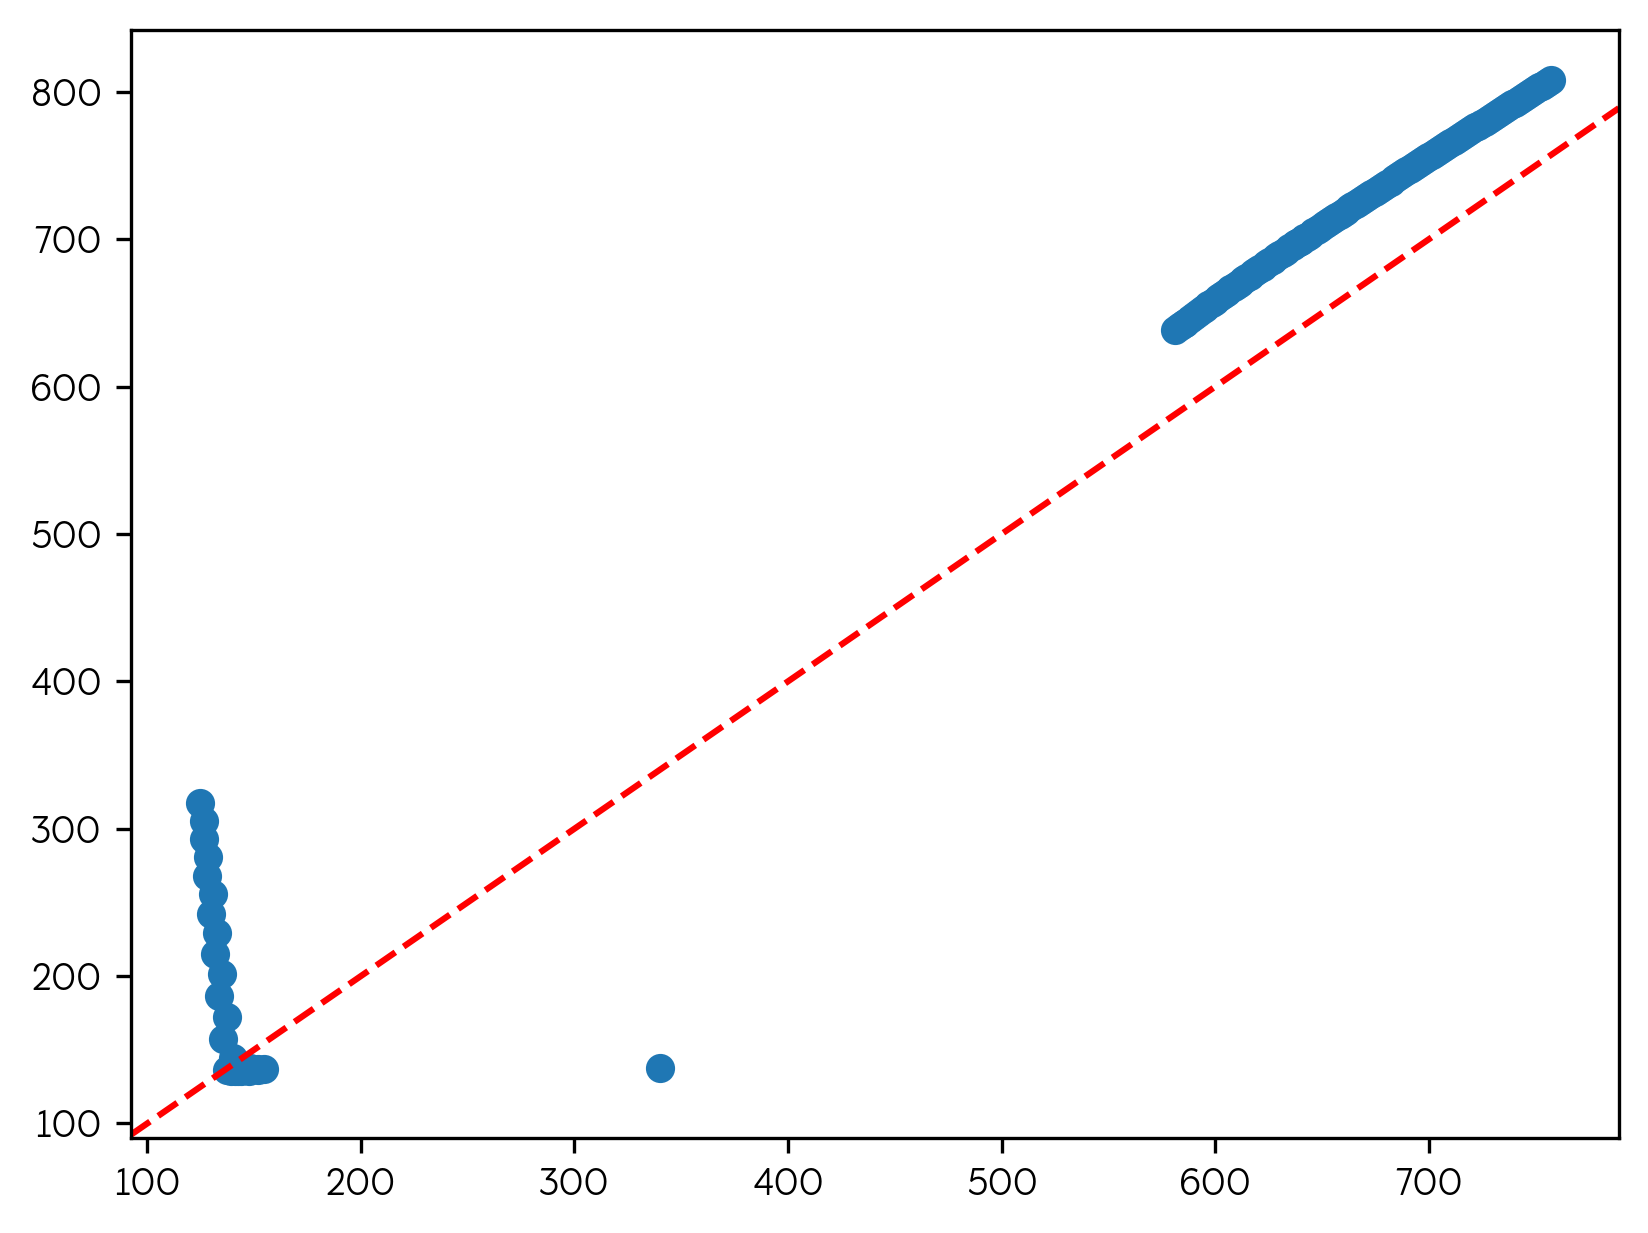

In [ ]:
olga_rho = olga_dict[scenario].iloc[:, 7].values


# olga_dict[scenario]

fig, ax = plt.subplots()

ax.scatter(olga_rho, rho_vals)

lowest_value = int(min(min(olga_rho), min(rho_vals)))
ax.axline((lowest_value, lowest_value), slope=1, color="r", linestyle="--")

# Mixture 2

In [ ]:
mix2_pvt_data = load_pvt_data(pvt_root_path=pvt_path.as_posix(), fluid_type=mix2_path_name)

In [ ]:
mix2_path_name

'mixture2'

In [ ]:
mix2_mixture_info

{'name': 'mixture2', 'composition': '95% CO2, 5% CH4'}

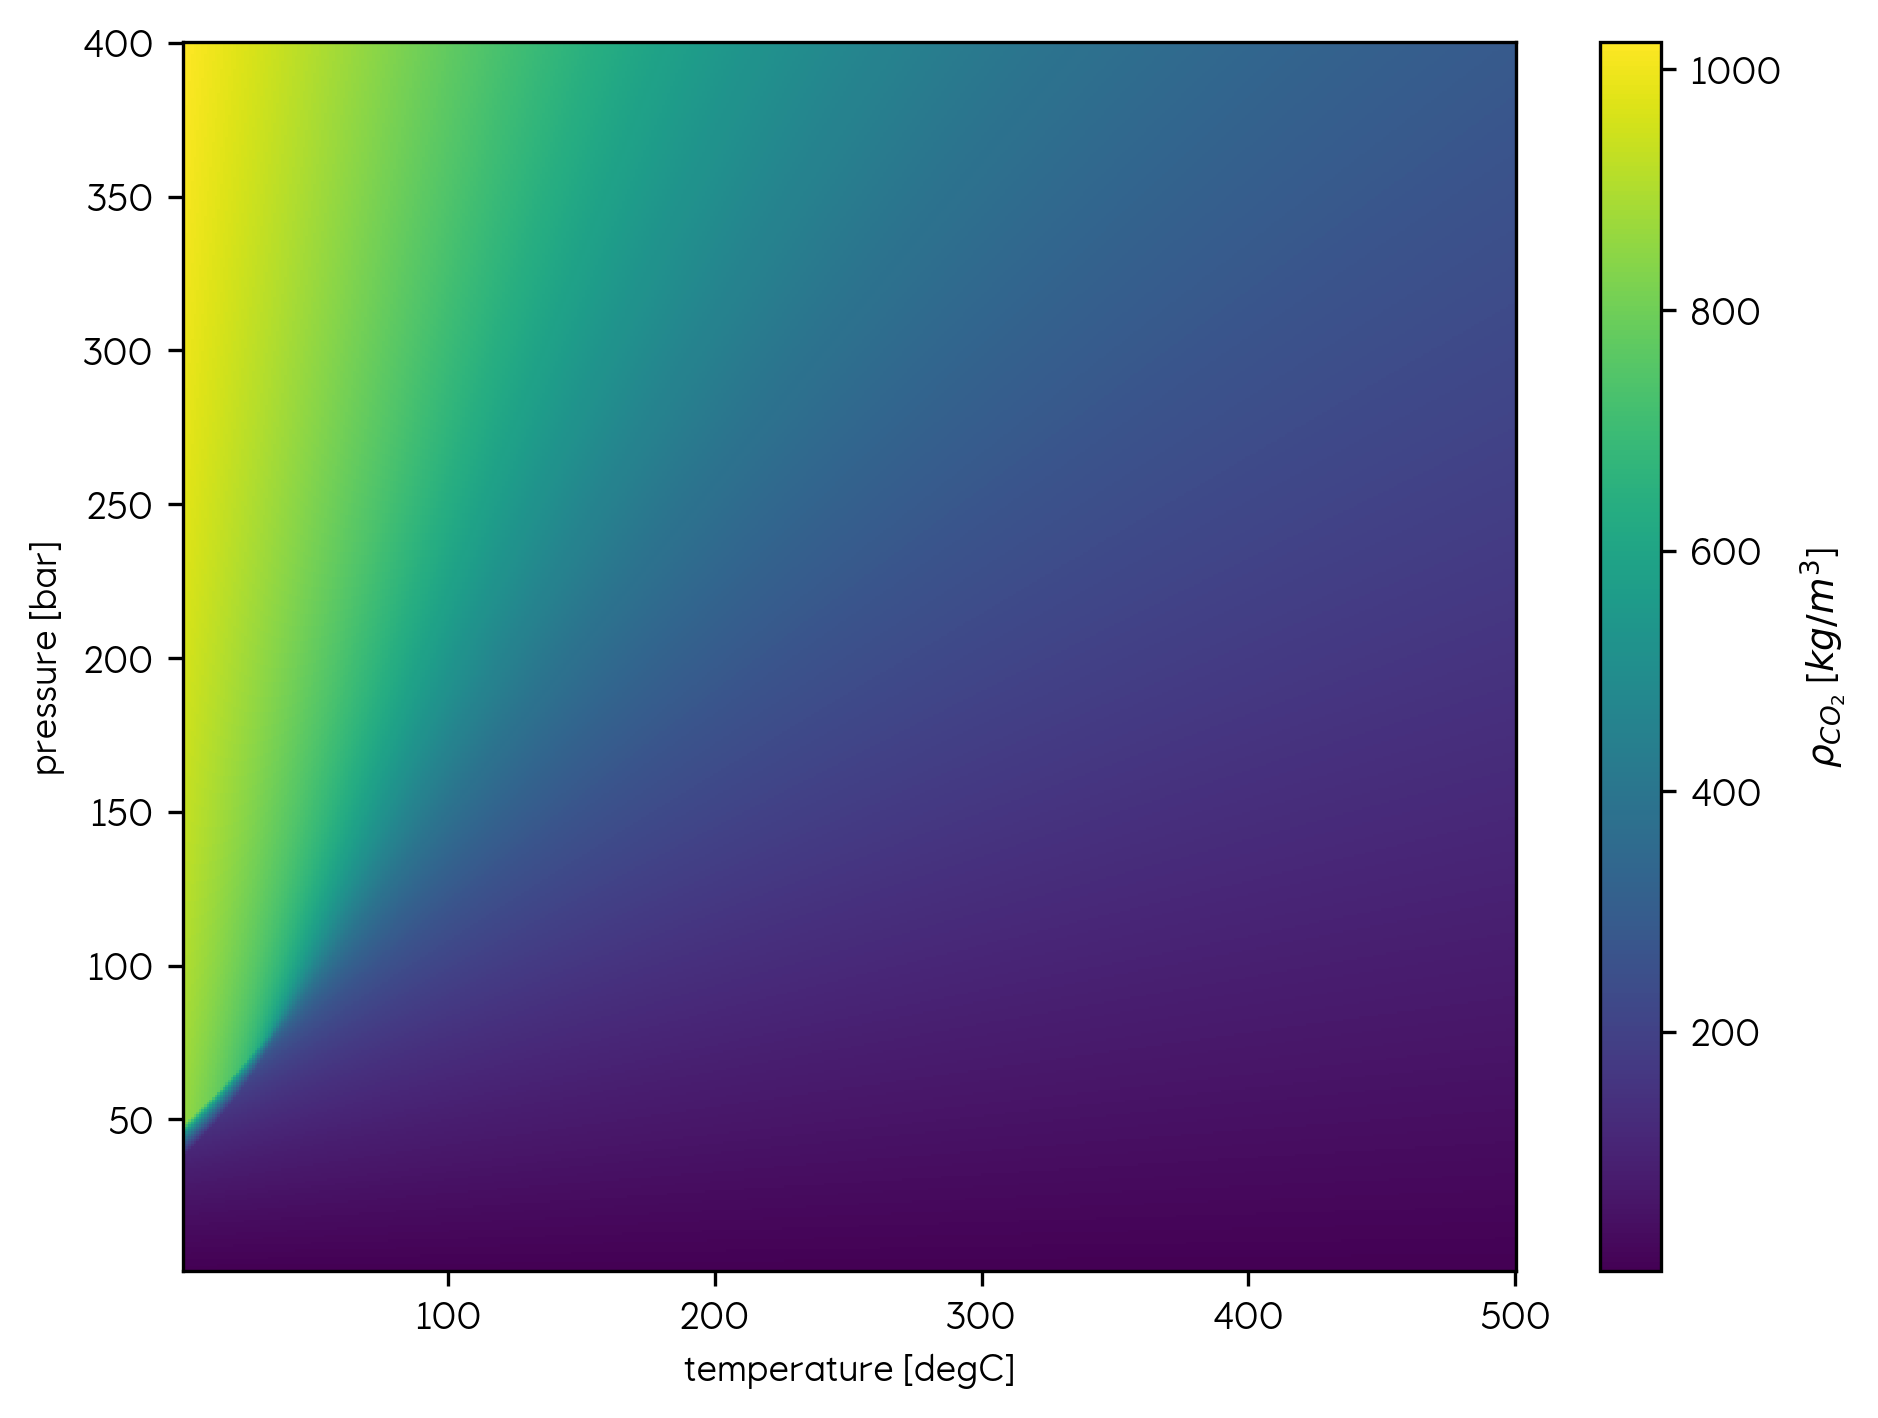

In [ ]:
# Plot tables
fig, ax = plt.subplots()
# Plot density colormap
rho_pcm_co2 = ax.pcolormesh(mix2_pvt_data["temperature"], mix2_pvt_data["pressure"], mix2_pvt_data[mix2_path_name]["rho"])


ax.set_xlabel("temperature [degC]")

ax.set_ylabel("pressure [bar]")

fig.colorbar(rho_pcm_co2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()

In [ ]:
olga_mix1_122 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=0, usecols=range(8))
olga_mix1_94 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=1, usecols=range(8))
olga_mix1_75 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=2, usecols=range(8))
olga_mix1_47 = pd.read_excel(r"./olga_ref_runs/Mixture_2.xlsx", sheet_name=3, usecols=range(8))


olga_tables = [olga_mix1_122, olga_mix1_94, olga_mix1_75, olga_mix1_47]

In [ ]:
olga_mix1_122

Pipeline length [m]  \
0               4.133333   
1              12.400000   
2              20.666666   
3              28.933332   
4              37.200001   
..                   ...   
147           900.625000   
148           906.625000   
149           912.625000   
150           918.625000   
151           924.812500   

     HOL [-] (CHANNEL  PACTH) "Holdup (liquid volume fraction including solids)"  \
0                                             0.000082                             
1                                             0.001615                             
2                                             0.000169                             
3                                             0.002341                             
4                                             0.000244                             
..                                                 ...                             
147                                           1.000000                             
148                                           1.000000                             
149                                           1.000000                             
150                                           1.000000                             
151                                           1.000000                             

     Pipeline length [m].1  PT [bara] (CHANNEL  PACTH) "Pressure"  \
0                 4.133333                              45.499271   
1                12.400000                              45.601871   
2                20.666666                              45.705109   
3                28.933332                              45.809010   
4                37.200001                              45.913582   
..                     ...                                    ...   
147             900.625000                             121.299698   
148             906.625000                             121.637398   
149             912.625000                             121.974899   
150             918.625000                             122.311600   
151             924.812500                             122.657898   

     Pipeline length [m].2  \
0                 4.133333   
1                12.400000   
2                20.666666   
3                28.933332   
4                37.200001   
..                     ...   
147             900.625000   
148             906.625000   
149             912.625000   
150             918.625000   
151             924.812500   

     ROF [kg/m3] (CHANNEL  PACTH) "Fluid mixture density including all phases (also any solids, drilling fluids and deposits) in all layers."  \
0                                           126.179802                                                                                          
1                                           128.014801                                                                                          
2                                           127.828903                                                                                          
3                                           130.115906                                                                                          
4                                           129.524796                                                                                          
..                                                 ...                                                                                          
147                                         573.506104                                                                                          
148                                         574.052612                                                                                          
149                                         572.676880                                                                                          
150                

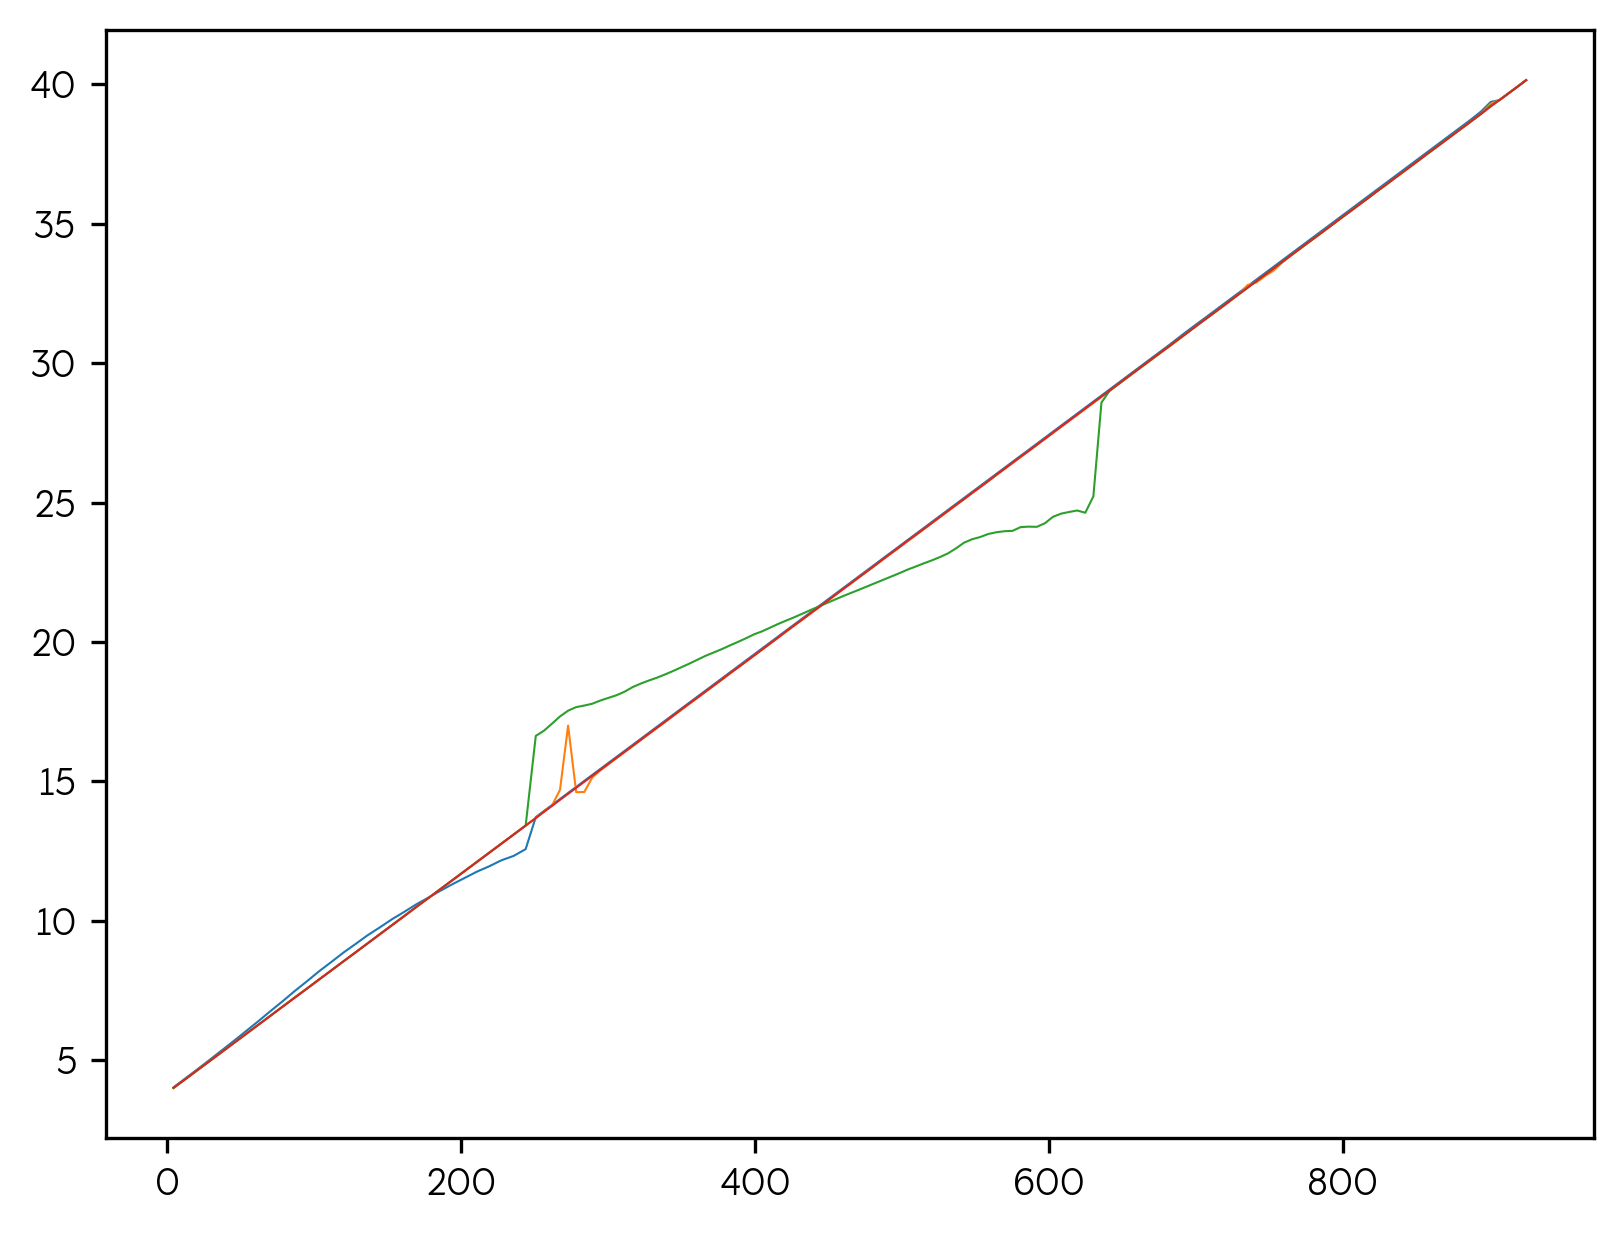

In [ ]:
fig, ax = plt.subplots()

for table in olga_tables:
    ax.plot(table.iloc[:, 0], table.iloc[:, 7], lw=0.5)

# plt.plot(olga_pure_co2_122.iloc[:, 0], olga_pure_co2_122.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_94.iloc[:, 0], olga_pure_co2_94.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_75.iloc[:, 0], olga_pure_co2_75.iloc[:, 7], lw=0.5)
# plt.plot(olga_pure_co2_47.iloc[:, 0], olga_pure_co2_47.iloc[:, 7], lw=0.5)

In [ ]:
sf_depth_msl = 312  # Water depth [meters]
sf_temp_degc = 4  # temperature at sea floor [degC]
field_fluid_type = "mixture1"

p_models = {}
olga_dict = {}

delta_z_cases = dict()

for olga_case in olga_tables:
    geo_tgrad = 1e3 * ((olga_case.iloc[-1, 7] - 4.000000) / (924.812500 - 4.133333))

    z_eq = ((olga_case.iloc[-1, 7] - sf_temp_degc) / (geo_tgrad / 1e3)) + sf_depth_msl

    delta_z = z_eq - olga_case.iloc[-1, 0]

    CO2_contact = z_eq  # CO2 water contact mTVDMSL
    press = olga_case.iloc[-1, 3]
    press_label = f"{press:.2f}"
    print(f"{press_label=}")
    delta_z_cases[press_label] = delta_z

    print(f"{geo_tgrad=} {sf_temp_degc:.2f} {CO2_contact=} {field_fluid_type=} {press=}")

    olga_dict[press_label] = olga_case
    # '''Constants'''

    # geo_tgrad = 40 #geothermal gradient [degc/km]
    p_models[press_label] = Pressure(
        # wellbore seafloor depth mTVD MSL.
        sf_depth_msl=sf_depth_msl,  # wellbore.water_depth,
        # wellbore total depth in mTVD RKB
        well_td_rkb=5e3,  # total_depth_rkb,
        # wellbore rkb in mTVD RKB
        well_rkb=0,
        # seafloor temperature in degC
        sf_temp=sf_temp_degc,  # DEFAULT_SEAFLOOR_TEMPERATURE,
        # geothermal gradient in degC/km
        geo_tgrad=geo_tgrad,  # DEFAULT_GEOTHERMAL_GRADIENT,
        fluid_type=field_fluid_type,  # type: ignore
        # path to the pvt constants folder
        pvt_path=pvt_path,
        z_fluid_contact=CO2_contact,  # wellbore_settings.pressure_datum_tvd_msl,  # type: ignore
        p_fluid_contact=press,  # wellbore_settings.reservoir_pressure_bar,  # type: ignore
        # specific_gravity=None,  # type: ignore
        # ip_shmin_data=shmin_data,
        shmin_gradient=0.3,
    )

press_label='122.66'
geo_tgrad=np.float64(39.26561259329613) 4.00 CO2_contact=np.float64(1232.6791670000002) field_fluid_type='mixture1' press=np.float64(122.657897949219)
Computing pressure profile for scenario: hydrostatic
press_label='94.99'
geo_tgrad=np.float64(39.26661942767323) 4.00 CO2_contact=np.float64(1232.6791669999998) field_fluid_type='mixture1' press=np.float64(94.9892807006836)
Computing pressure profile for scenario: hydrostatic
press_label='75.00'
geo_tgrad=np.float64(39.26327574313713) 4.00 CO2_contact=np.float64(1232.679167) field_fluid_type='mixture1' press=np.float64(74.9971694946289)
Computing pressure profile for scenario: hydrostatic
press_label='47.74'
geo_tgrad=np.float64(39.26988853188507) 4.00 CO2_contact=np.float64(1232.6791669999998) field_fluid_type='mixture1' press=np.float64(47.7425003051758)
Computing pressure profile for scenario: hydrostatic


In [ ]:
p_models[press_label].fluid_type

'mixture1'

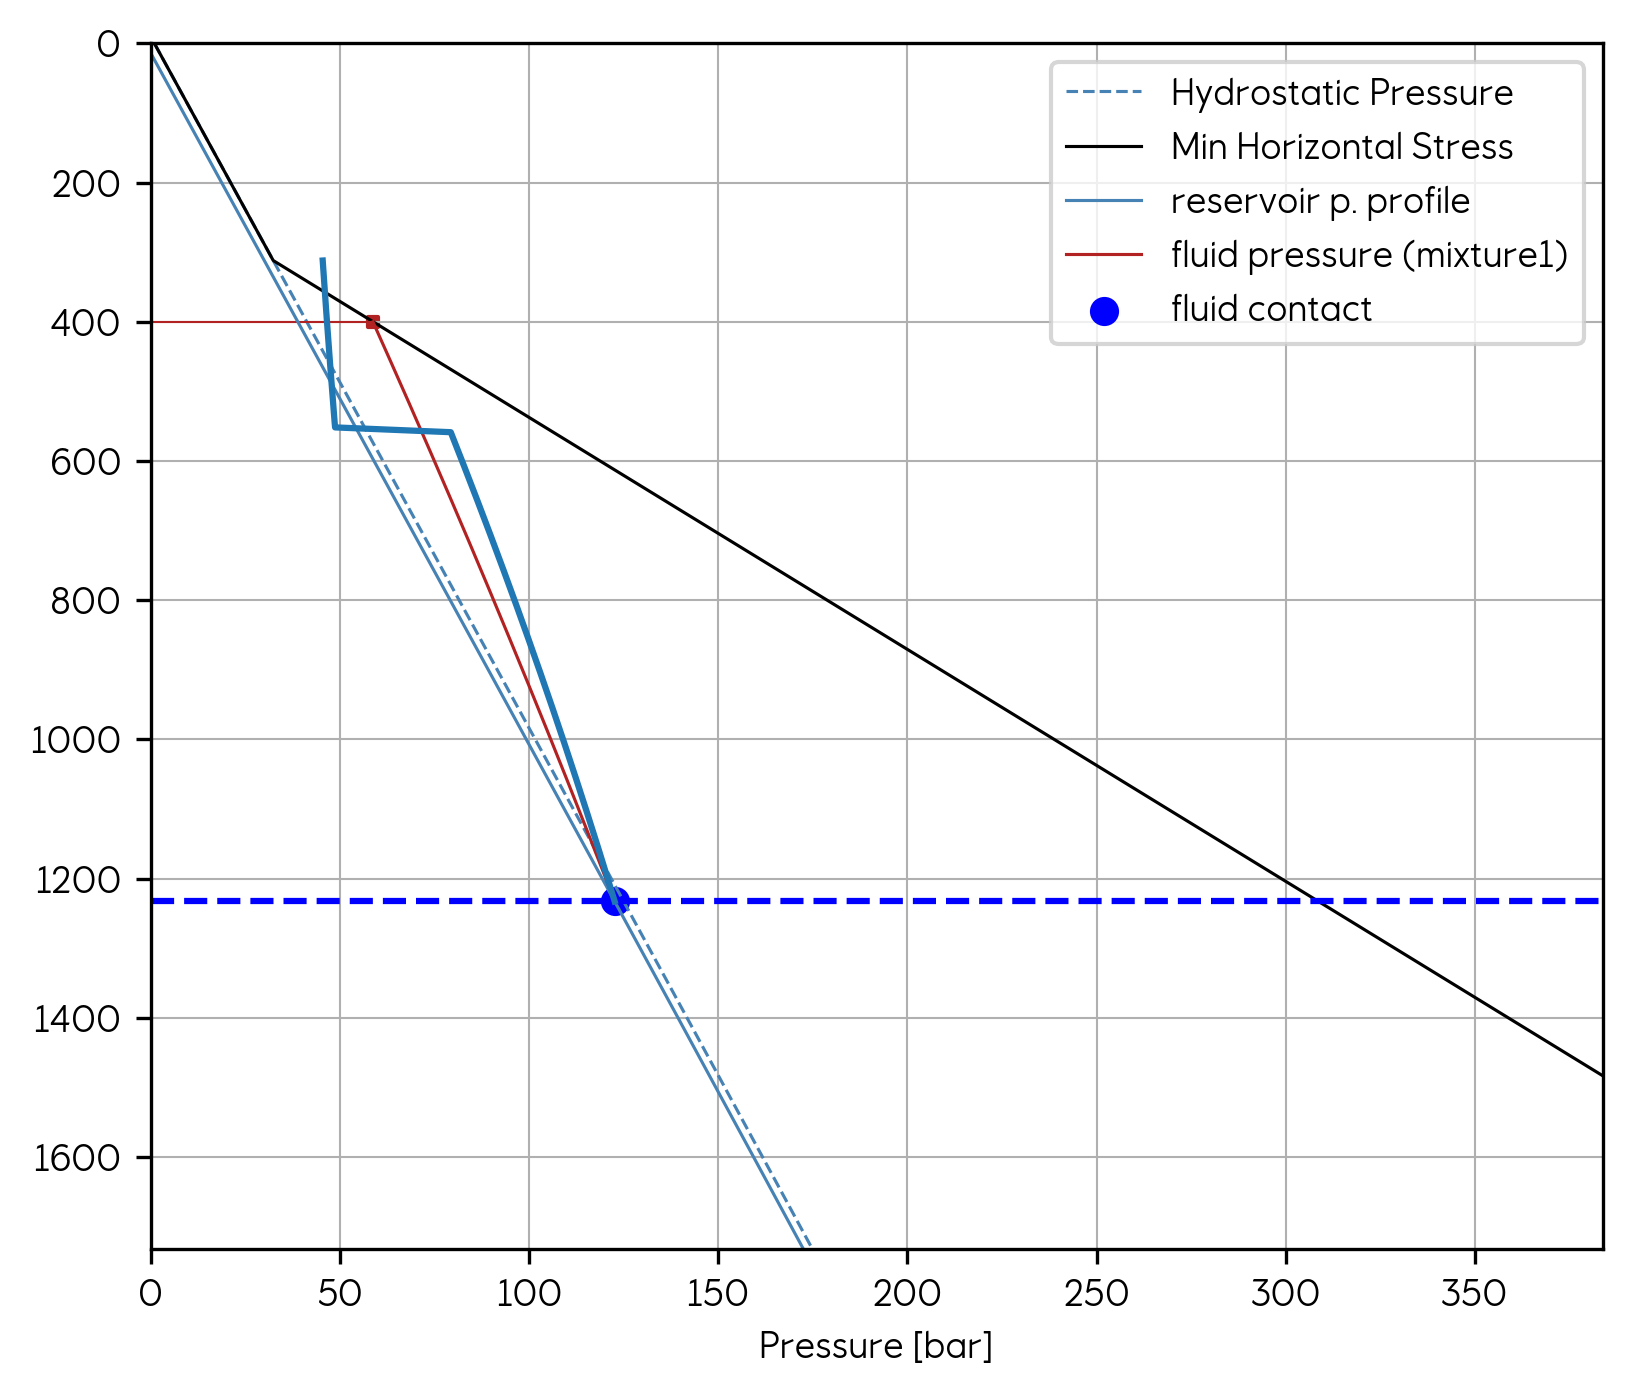

In [ ]:
rcParams["figure.dpi"] = 300

width_cm = 14  # cm
height_cm = 12  # cm

width = width_cm / 2.54
height = height_cm / 2.54

fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(olga_dict.keys())[0]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

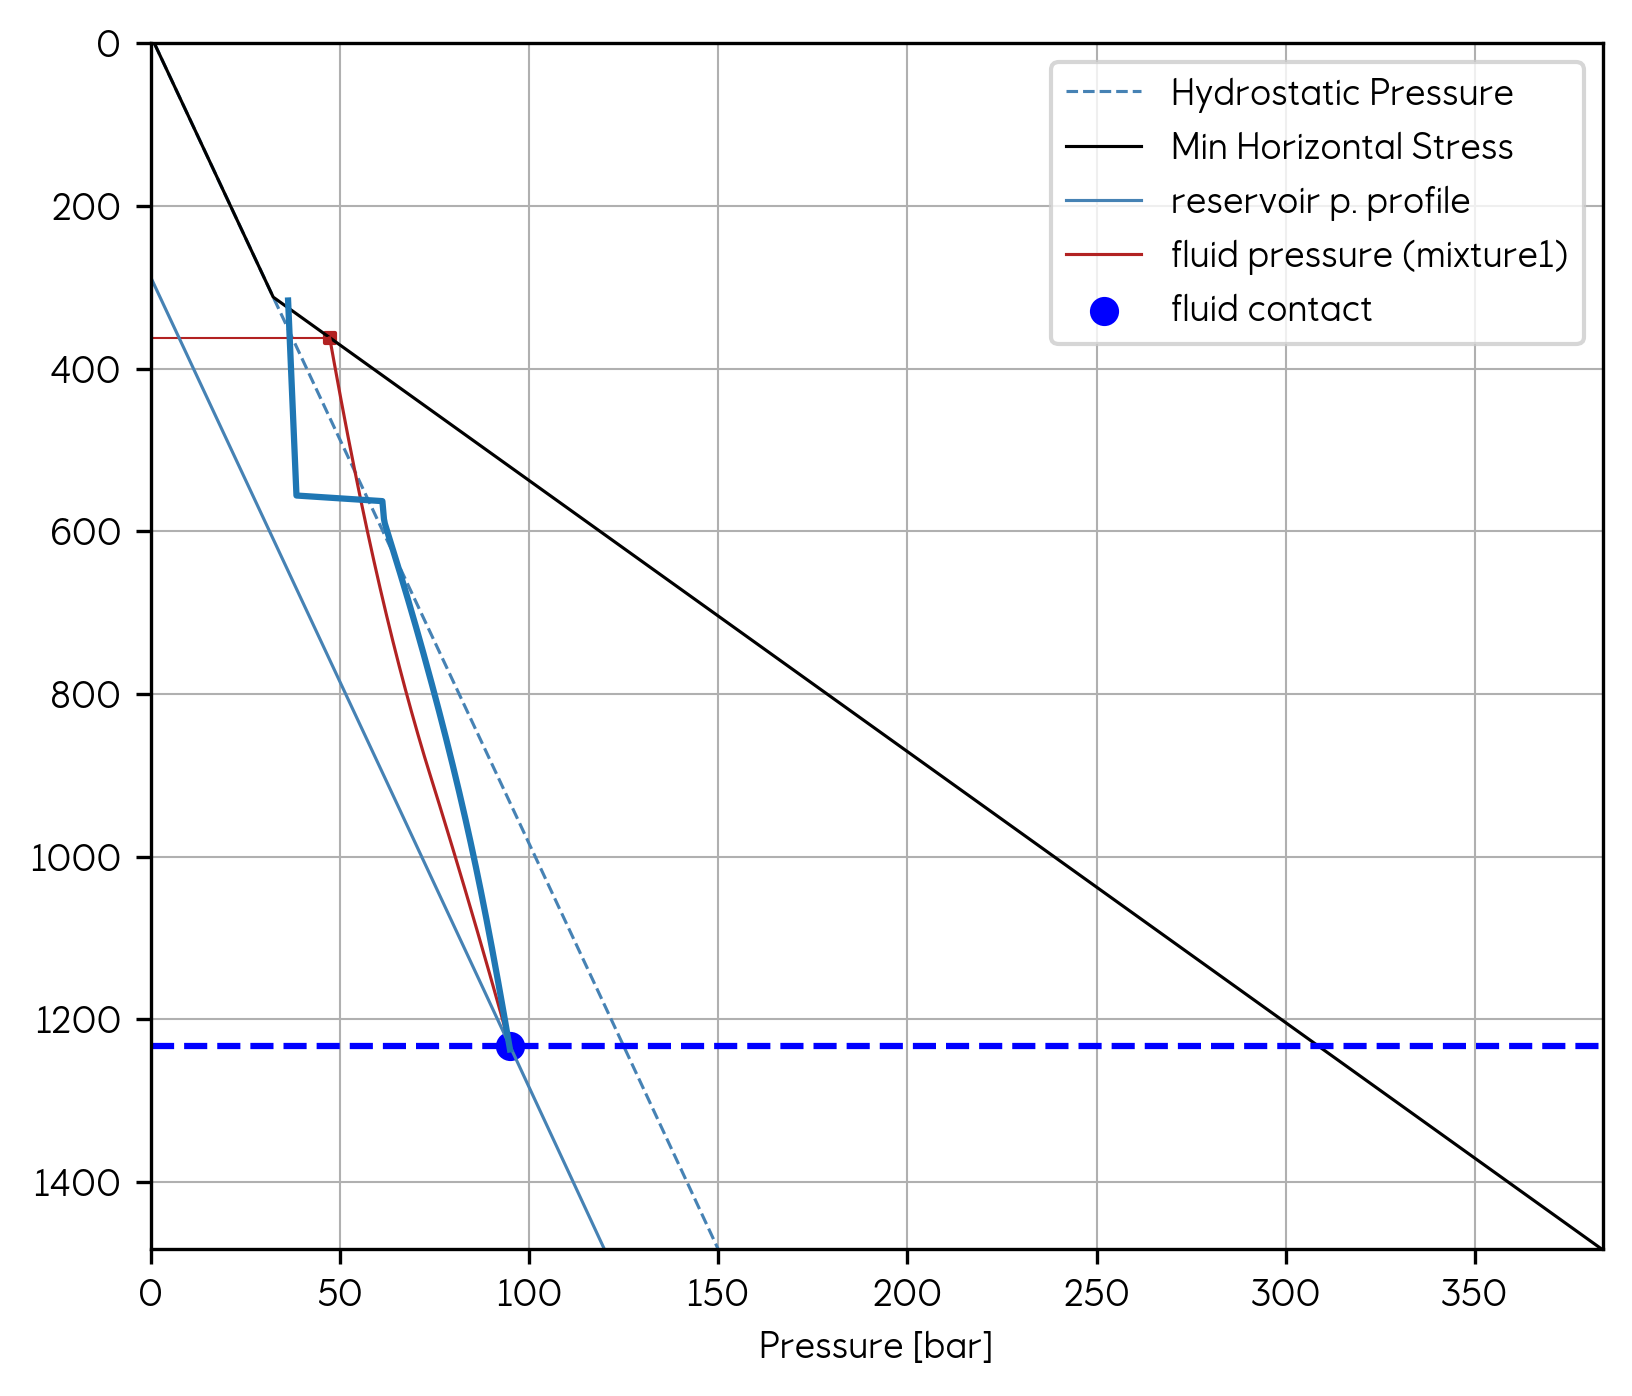

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[1]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 250)
fig.tight_layout()

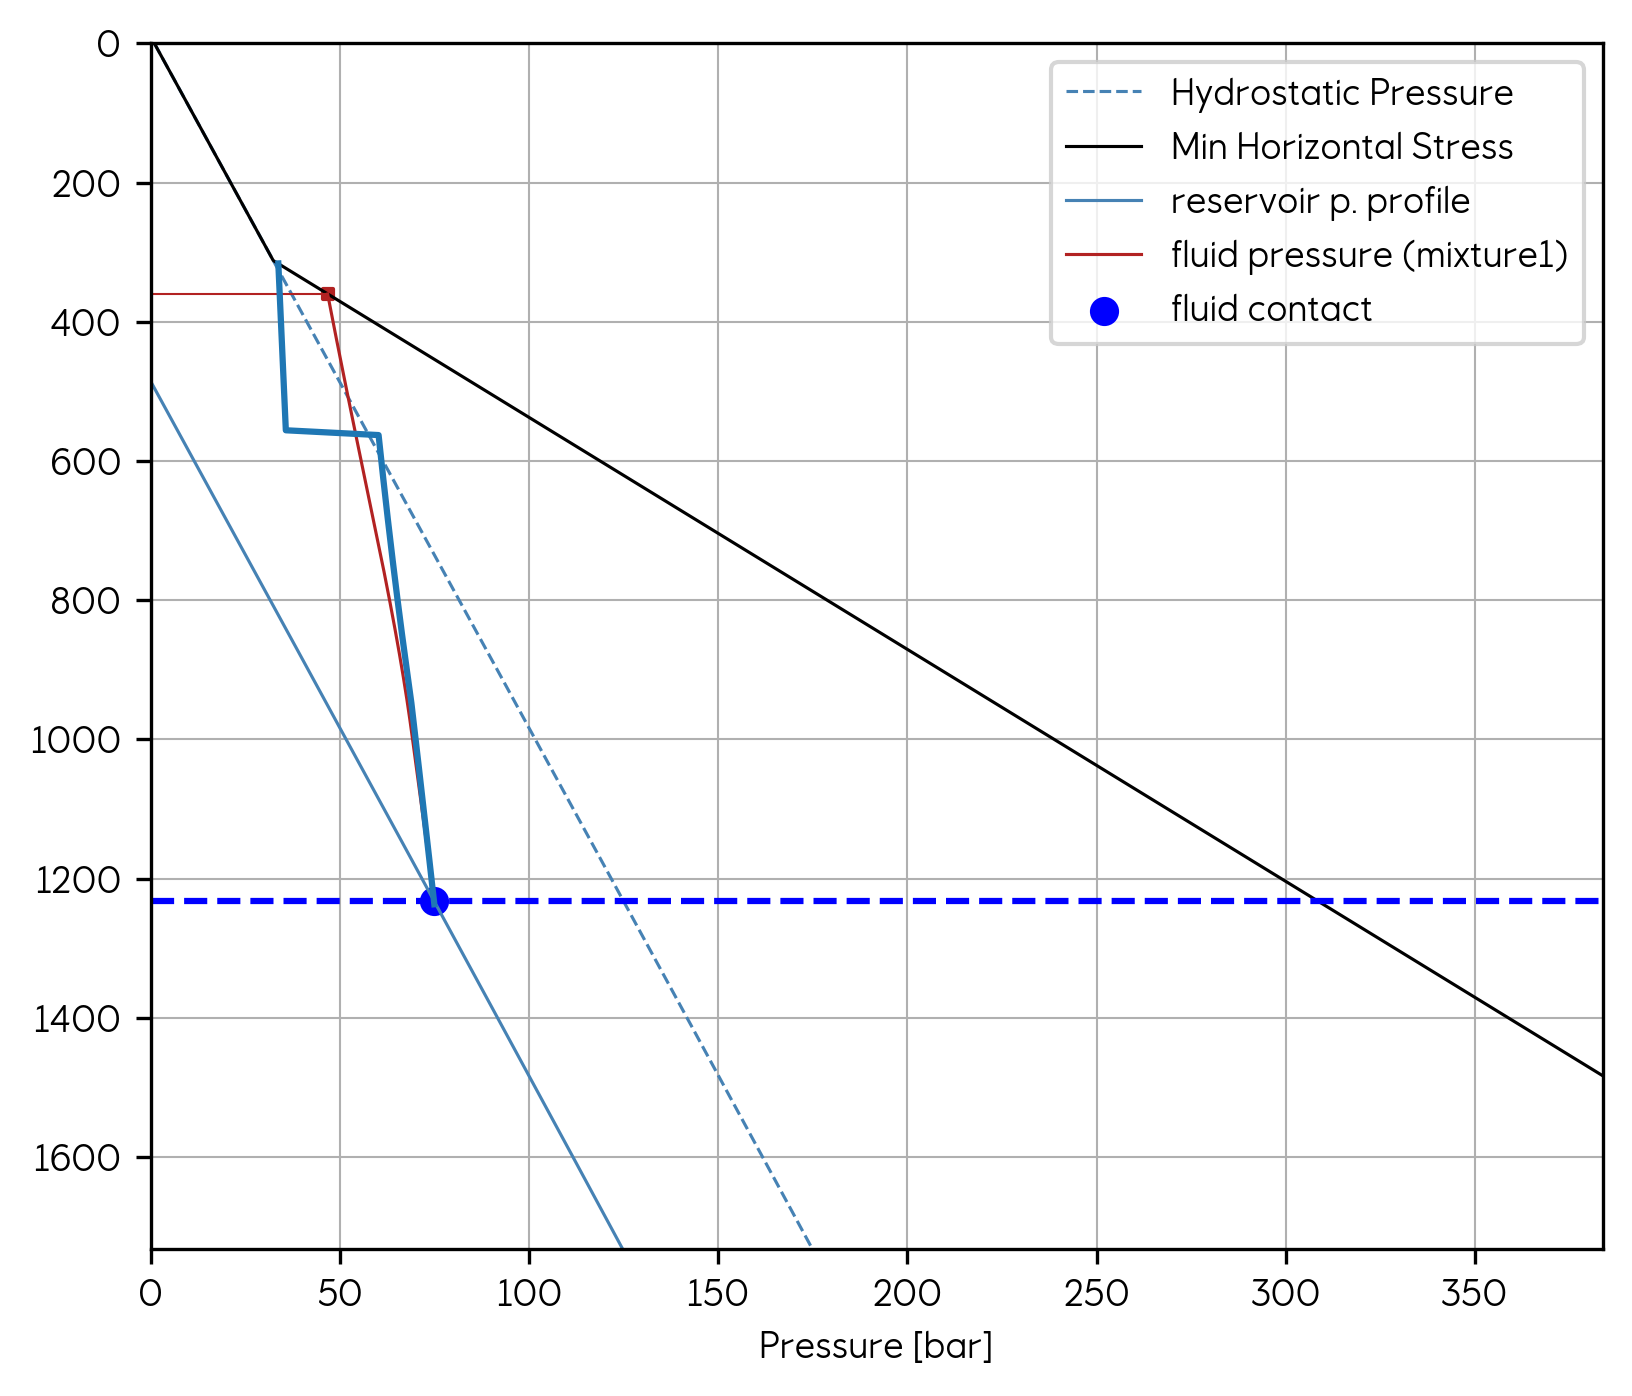

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[2]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], sf_depth_msl + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

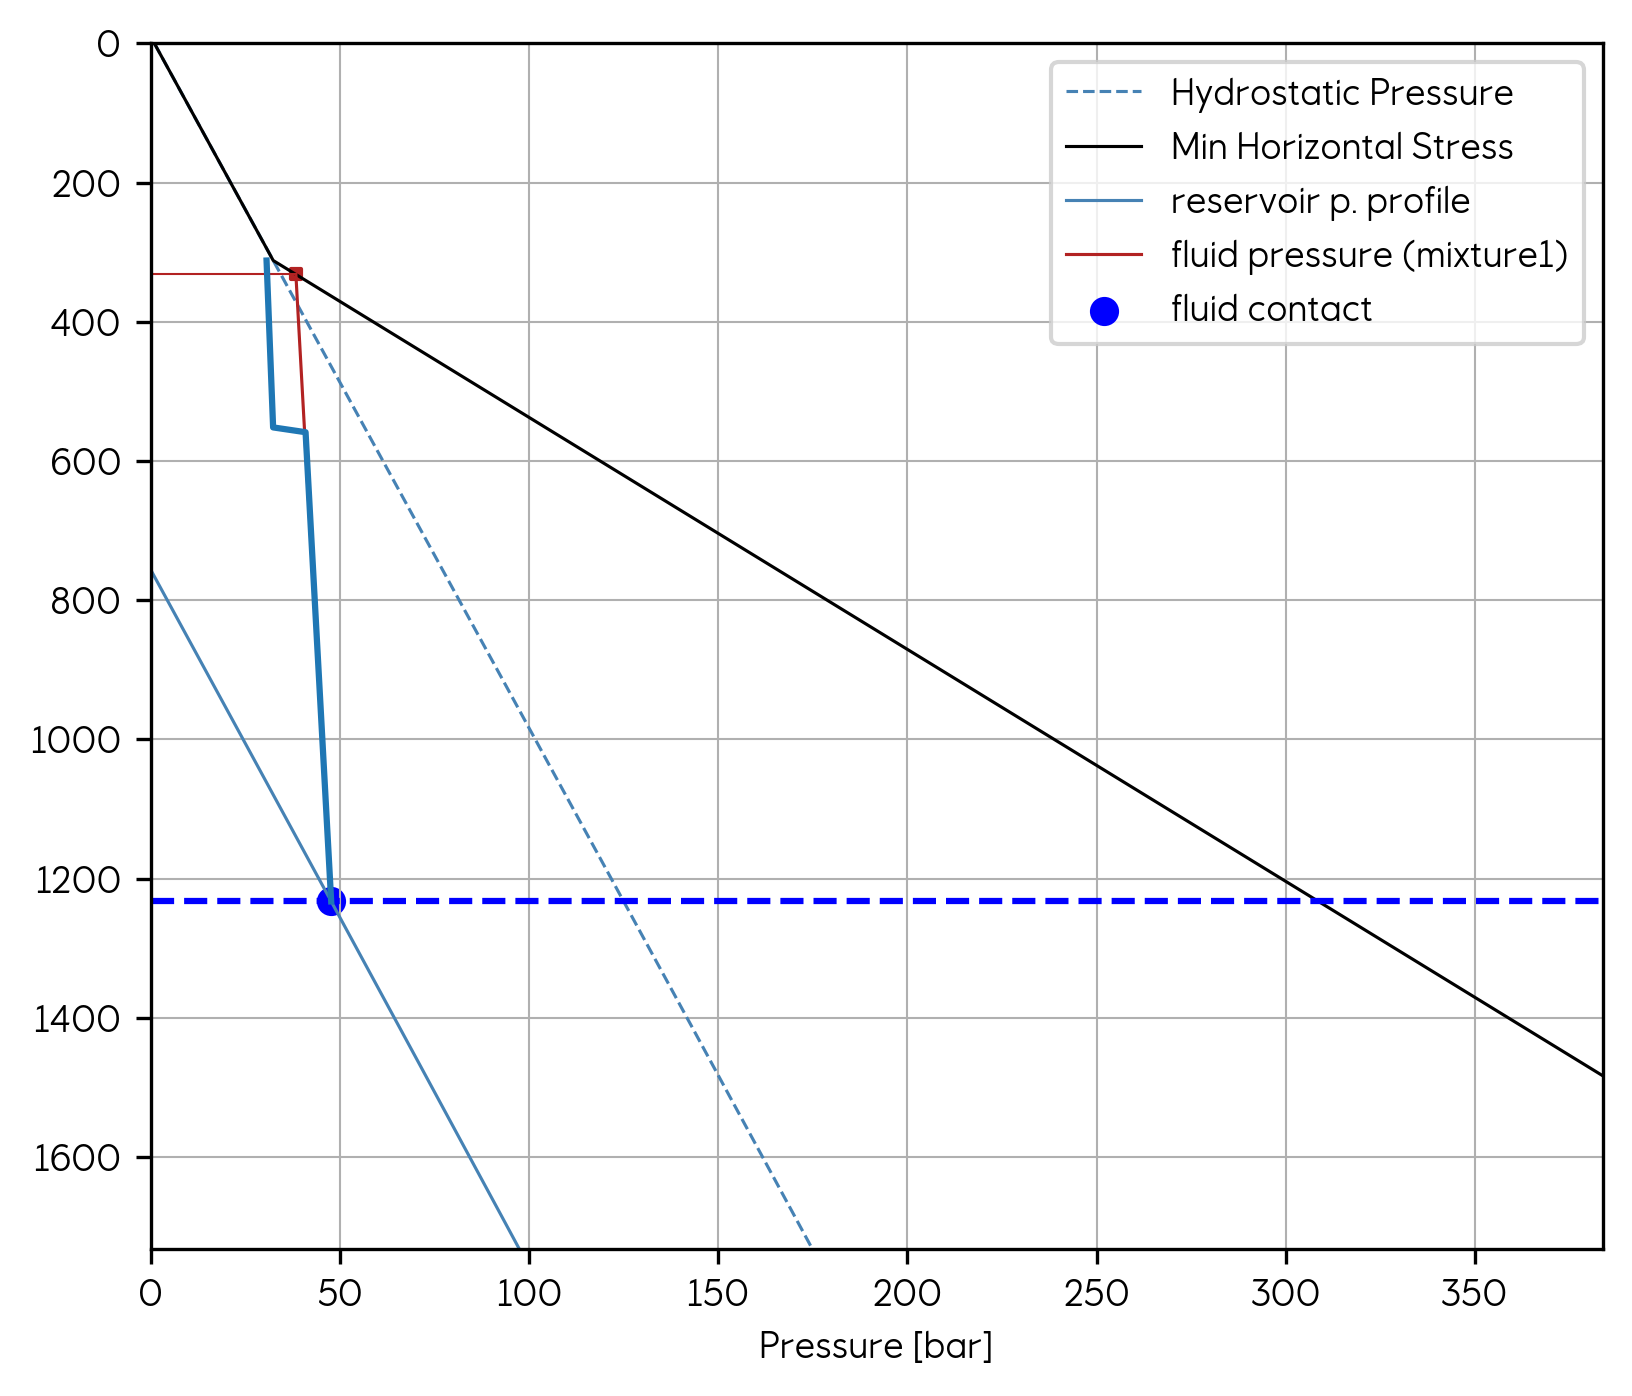

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

case = list(p_models.keys())[3]

my_pressure = p_models[case]

plot_pressure(
    my_pressure,
    ax=ax,
    plot_HSP=True,  # plot brine hydrostatic gradient
    plot_MSAD=True,  # plot minimum safety abandonment depth,
    plot_fluid_contact=True,  # plot fluid contact
    plot_resrv=False,  # plot reservoir
    plot_delta_p=False,  # plot delta p
    plot_fluid_pressure=True,
)

ax.axhline(y=my_pressure.z_fluid_contact, color="blue", linestyle="--", label="Fluid contact")


ax.plot(olga_dict[case].iloc[:, 3], delta_z + olga_dict[case].iloc[:, 0])

ax.set_ylim(bottom=my_pressure.z_fluid_contact + 500)
fig.tight_layout()

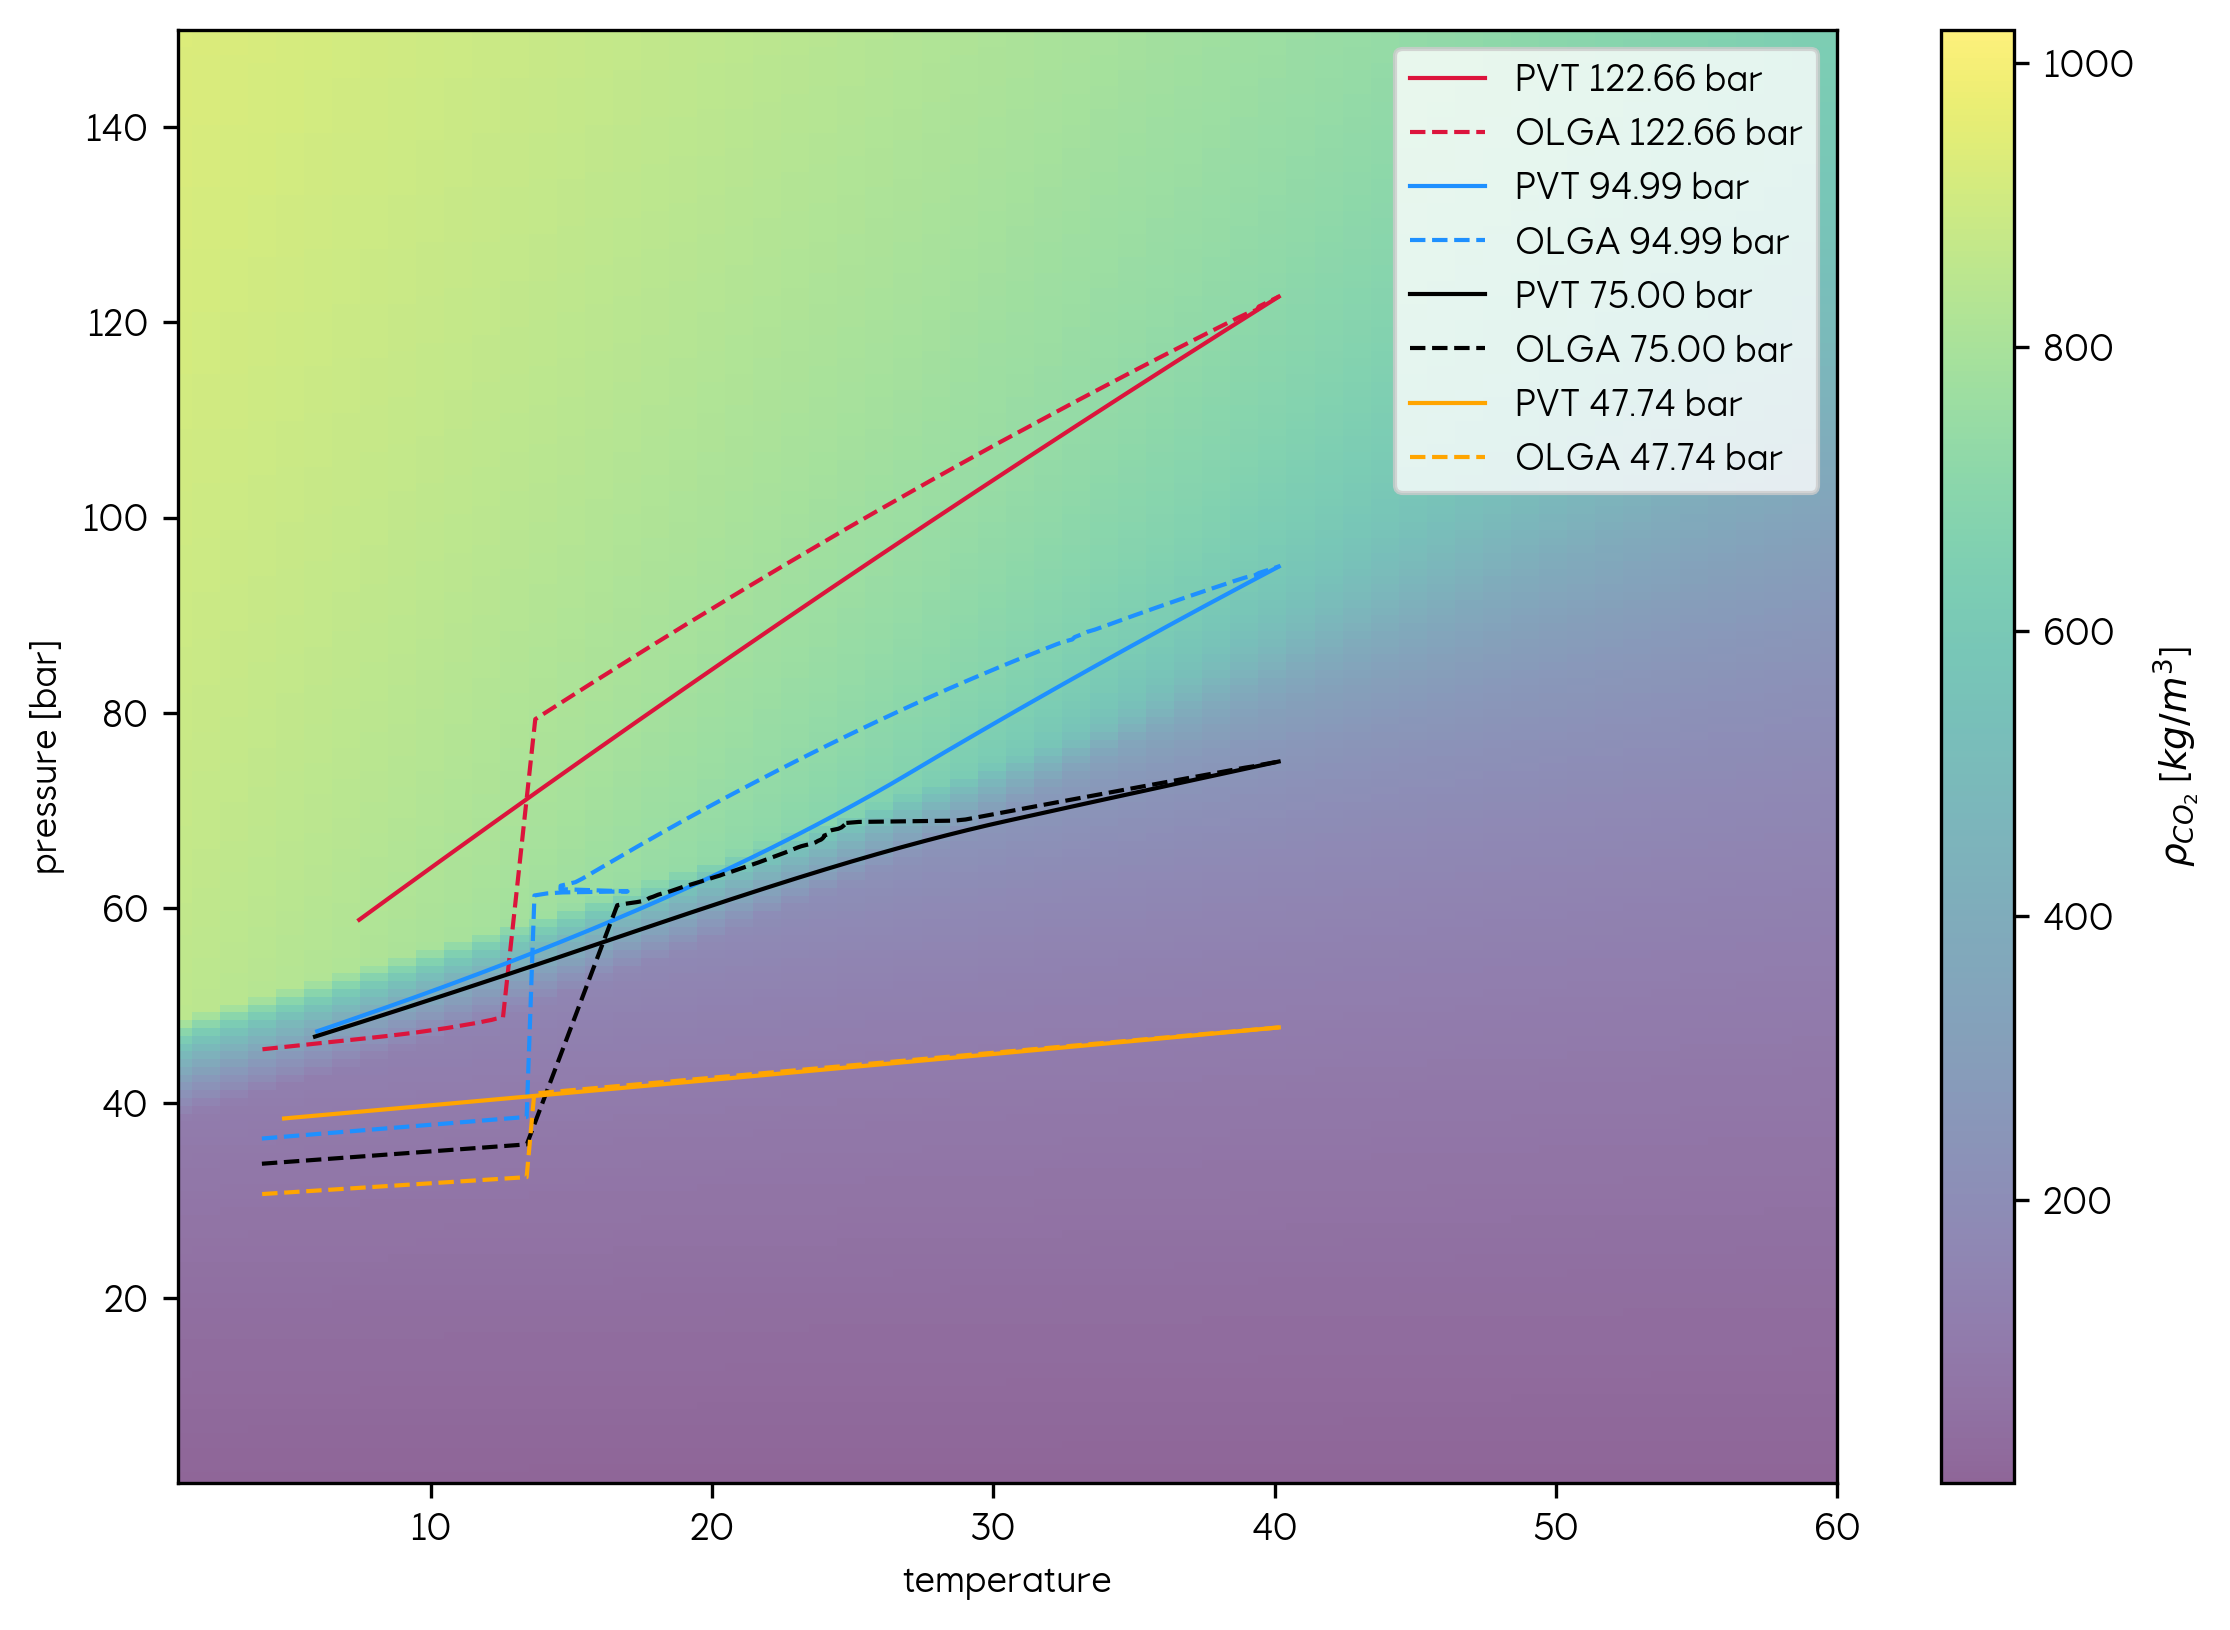

In [ ]:
# Plot tables
from itertools import cycle

height = 13.98 / (const.inch * 100)
width = 19.5 / (const.inch * 100)

fig, ax = plt.subplots(1, 1, figsize=(width, height))
# Plot density colormap
rho_pcm_mix2 = ax.pcolormesh(mix2_pvt_data["temperature"], mix2_pvt_data["pressure"], mix2_pvt_data[mix2_path_name]["rho"], alpha=0.6)

ax.set_xlabel("temperature [degC]")
ax.set_ylabel("pressure [bar]")

color_cycle = cycle(["#DC143C", "#1E90FF", "k", "#FFA500"])


# ax.plot(olga_pure_co2_122.iloc[:,7], olga_pure_co2_122.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_94.iloc[:,7], olga_pure_co2_94.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_75.iloc[:,7], olga_pure_co2_75.iloc[:,3], color=next(color_cycle))
# ax.plot(olga_pure_co2_47.iloc[:,7], olga_pure_co2_47.iloc[:,3], color=next(color_cycle))

for scenario, color in zip(p_models, color_cycle):
    p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves.plot(
        "temperature", "fluid_pressure", ax=ax, color=color, label=f"PVT {scenario} bar", lw=1
    )

    ax.plot(olga_dict[scenario].iloc[:, 7], olga_dict[scenario].iloc[:, 3], color=color, ls="--", label=f"OLGA {scenario} bar", lw=1)

ax.set_xlim(1, 60)

ax.set_ylim(1, 150)
ax.legend()

fig.colorbar(rho_pcm_mix2, label=r"$\rho_{CO_2}$ [$kg/m^3$]")


fig.tight_layout()

In [ ]:
scenario = list(p_models.keys())[2]
df = p_models[scenario].scenario_manager.scenarios["hydrostatic"].init_curves

df[~df["fluid_pressure"].isna()]

depth  temperature  hydrostatic_pressure  \
360.000000    360.000000     5.884794             37.261071   
361.000000    361.000000     5.924060             37.361816   
362.000000    362.000000     5.963327             37.462562   
363.000000    363.000000     6.002593             37.563307   
364.000000    364.000000     6.041860             37.664052   
...                  ...          ...                   ...   
1229.000000  1229.000000    40.007410            124.664341   
1230.000000  1230.000000    40.046677            124.764558   
1231.000000  1231.000000    40.085943            124.864773   
1232.000000  1232.000000    40.125210            124.964988   
1232.679167  1232.679167    40.144843            125.015094   

             min_horizontal_stress  fluid_pressure  brine_pressure  
360.000000               46.825442       46.811409      -12.180651  
361.000000               47.125442       46.846054      -12.080063  
362.000000               47.425442       46.880735      -11.979475  
363.000000               47.725442       46.915452      -11.878888  
364.000000               48.025442       46.950205      -11.778300  
...                            ...             ...             ...  
1229.000000             307.525442       75.316653       75.040225  
1230.000000             307.825442       75.341524       75.140229  
1231.000000             308.125442       75.366394       75.240231  
1232.000000             308.425442       75.391261       75.340233  
1232.679167             308.575442       75.403694       75.390233  

[874 rows x 6 columns]